### Inverse Modelling: Demonstration of parameterisation of structure and history matching
#### Showcasing LoopStructural-Flopy to address Model Structure Uncertainty

This notebook uses a simple example to show how the pinchout of a formation at an unconformity can be included in uncertainty analysis using parameterisation and estimation of parameters and forecasting.


### 1. Project parameters

In [1]:
import sys
sys.path.insert(1, '../../MODFLOW_Tools/loop2flopy/')
#print(sys.path)
%run ./loop_showcase_functions.ipynb
#load from MODFLOW_tools (clone repo https://github.com/JimMcCallum/MODFLOW_Tools)
%run ../../MODFLOW_Tools/modelling_routines/modelling_routines.ipynb
%run ../../MODFLOW_Tools/meshing_routines/meshing_routines.ipynb
%run ../../MODFLOW_Tools/geomodel_routines/geomodel_routines.ipynb
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy.ipynb
%run ../../MODFLOW_Tools/plotting_routines_USG/plotting_routines.ipynb



C:\Users\00098687\Anaconda3\envs\loop3denv\lib\site-packages\geopandas\_compat.py:18: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_GE_10 = str(pd.__version__) >= LooseVersion("1.0.0")
C:\Users\00098687\Anaconda3\envs\loop3denv\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\00098687\Anaconda3\envs\loop3denv\lib\site-packages\geopandas\_compat.py:19: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_GE_11 = str(pd.__version__) >= LooseVersion("1.1.0")
C:\Users\00098687\Anaconda3\envs\loop3denv\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\00098687\Anaconda3\envs\loop3denv\lib\site-packages\geopandas\_co

Modelling routines loaded!
Meshing routines loaded!
Geomodel routines loaded!
loop2flopy routines loaded!
Plotting routines loaded!


In [2]:
P = Project('showcase', boundingbox = [0, 6000, 0, 6000, -500, 0]) # (x0, x1, y0, y1, z0, z1)

# ------------- DISCRETISATION PARAMETERS -----------------------#
P.triExeName = '../exe/triangle.exe'
P.workspace = '../modelfiles/'
P.crs = "epsg:28350" # Put in coordinate reference
P.xypumpbores = [(2000, 2000), (2500, 2000), (2000, 2500), (2500, 2500),] 
P.idpumpbores = ['P0','P1','P2','P3'] 
P.xyobsbores = [(1500,1000), (2500, 5000), (4000, 3000), (1500, 3500), (4500,4500)] 
P.idobsbores = ['OB1', 'OB2', 'OB3', 'OB4', 'OB5'] 
P.nobs = len(P.xyobsbores)
P.nzobs = 3
P.npump = len(P.xypumpbores)

P.r = 40        # refining factor for model boundary. High r has refined edges
P.w = 100      # Interior boundary
P.boundmaxtri = 30000 
P.modelmaxtri = 30000 # 10000 for ref
P.angle = 34   # minimum triangle angles

P.radius1 = 100 # radius of inner circle around pumping bores
P.radius2 = 200 # radius of outer circle around pumping bores
P.boremaxtri = 100000

# ------------- FLOW MODEL PARAMETERS -----------------------#
P.mfexe_name = '../exe/mf6.exe'

P.nlg = 4    # number of geological layers
P.nls = 2    # Number sublayers for conformable
P.geo_pl = 2 # Which geological layer pumping from (zero-based)
P.res = 2    # vertical resolution upon which voxel grid created to pick lithology bottoms

P.hk = [1.7, 0.07, 8.2, 0.05] 
P.vk = [0.12,0.007,0.51,0.005] 
P.ss = [0.00009, 0.00007, 0.00002, 0.00008]
P.sy = [0.12, 0.1, 0.1, 0.1]
reference = [P.hk, P.vk, P.ss, P.sy]
pickle.dump(reference, open('../results/reference.pkl','wb'))

P.rch = 0.4/365 # 0.0027 m/d
P.strt = 0.

P.chfunc = lambda x,z: -(0.005*x) - (z * 0.02)-20 # horizontal gradient of 0.01 and vertical gradient of 0.02
P.xt3d = True

past_years = 2
P.nts_past = past_years * 6
P.tdis_past = [(past_years * 365, P.nts_past, 1.1)] # period length, number of timesteps, tsmult
P.qwell_past = -2000 #m3/d 

future_years = 5
P.nts_future = future_years * 6
P.tdis_future = [(future_years * 365, P.nts_future, 1.1)] # period length, number of timesteps, tsmult
P.qwell_future = -5000 #m3/d 

#P.zobs = [-50, -100, -200]
   
vtk_workspace = '../vtk_files'
if not os.path.isdir(vtk_workspace):
    os.makedirs(vtk_workspace, exist_ok=True)
    
if not os.path.isdir('../results'):
    os.makedirs(workspace, exist_ok=True)
    

In [3]:
for i in P.hk: print(logfunc(i))
for i in P.vk: print(logfunc(i))
for i in P.ss: print(logfunc(i))

0.2304489213782739
-1.154901959985743
0.9138138523837167
-1.3010299956639813
-0.9208187539523752
-2.154901959985743
-0.2924298239020636
-2.3010299956639813
-4.045757490560675
-4.154901959985743
-4.698970004336019
-4.096910013008056


### 2. Meshing

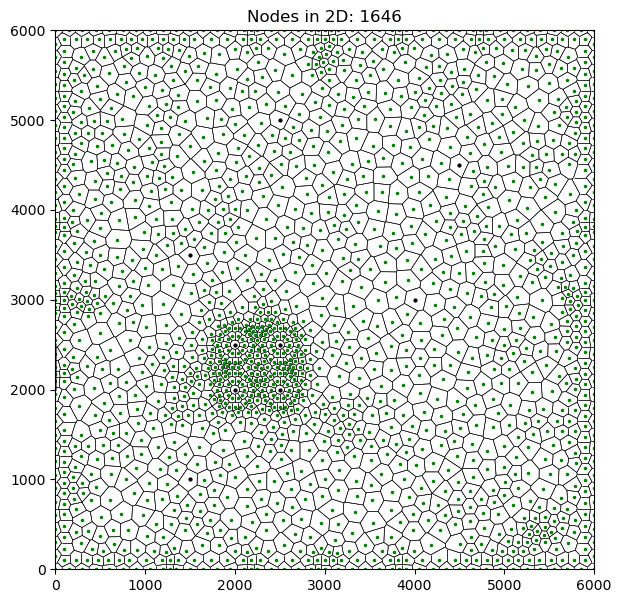

In [4]:
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = False)      
plot_cell2d_vor(P, xlim = [P.x0, P.x1], ylim = [P.y0, P.y1]) #xlim = [0, 3500], ylim = [0, 3500]

P.nlv  = 30  
P.delx, P.dely = 40, 40
P.ncol, P.nrow = int((P.x1 - P.x0) / P.delx), int((P.y1 - P.y0) / P.dely)
P.cell2dcar, P.xcyccar, P.verticescar, P.sg = createcell2d(P, grid = 'car', fault = False)    

### 3. Geological model (Reference)

In [5]:
P.control_points = ([])
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "inverse_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")
P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)     # Prepare geomodel inputs
P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel

C:\Users\00098687\Anaconda3\envs\loop3denv\lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


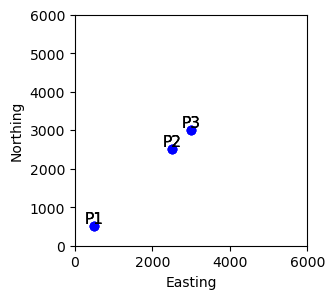

In [6]:
P.data
P.geomodel.feature_names()
plot_bores(P)

### 4. Flow model (Reference)

In [7]:
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy.ipynb

# Initiate REFERENCE
R = Model('ref', P, plan = 'vor', transect = 'con') 
R.create_lith_dis_arrays(P)     # Create lithology and discretisation arrays (DIS)

loop2flopy routines loaded!
   Creating lithology and discretisation arrays for  ref  ...


<decorator-gen-3>:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
<decorator-gen-3>:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``


In [8]:
P.wel_screens = []
for n in range(len(P.xypumpbores)):
    wel_icpl, wel_coords = find_cell_disv(P.xypumpbores[n][0], P.xypumpbores[n][1], R.xcyc)
    if P.geo_pl == 0:
        wel_top = R.top[wel_icpl]  
    else:   
        wel_top = R.botm[(P.geo_pl)* P.nls-1, wel_icpl]
    wel_bot = R.botm[(P.geo_pl + 1) * P.nls-1, wel_icpl]   
    print('Well coords ', wel_coords, ' Well screen top and bottom ', wel_top, wel_bot)
    P.wel_screens.append((wel_top, wel_bot))
    
P.zobs = np.zeros((P.nobs,P.nzobs))
for n in range(len(P.xyobsbores)):
    obs_icpl, obs_coords = find_cell_disv(P.xyobsbores[n][0], P.xyobsbores[n][1], R.xcyc) # Cell id in plan
    for m in range(3): # For the top three geological layers
        if m == 0:
            lay_top = R.top[obs_icpl]  
        else:   
            lay_top = R.botm[(m)* P.nls-1, obs_icpl]
        lay_bot = R.botm[(m + 1) * P.nls-1, obs_icpl]   
        obsz = lay_bot + (lay_top-lay_bot)/2
        P.zobs[n][m] = obsz
print('\nobservation depths')
print(P.zobs)

Well coords  (2000.0, 2000.0)  Well screen top and bottom  -186.0 -288.0
Well coords  (2500.0, 2000.0)  Well screen top and bottom  -164.0 -266.0
Well coords  (2000.0, 2500.0)  Well screen top and bottom  -164.0 -266.0
Well coords  (2500.0, 2500.0)  Well screen top and bottom  -148.0 -250.0

observation depths
[[ -25. -162. -326.]
 [ -25.  -50. -101.]
 [ -25.  -60. -121.]
 [ -25.  -99. -199.]
 [ -25.  -50.  -73.]]


In [9]:
R.create_prop_arrays(P)         # Create property arrays (NPF)
R.create_flow_package_arrays(P) # Create flow packages (CHD, RCH, IC, WEL, OBS)
print(R.modelname, ' has ', R.nnodes_div, ' nodes.')

   Creating property arrays for  ref  ...
   Adding flow packages to  ref  ...
   Time taken =  1.901583
ref  has  13168  nodes.


In [10]:
results = R.write_run_model(P, period = 'Steady', ic_array = P.strt)
R.gwf, R.head_ss, R.obs_ss, R.runtime_ss = results[0], results[1], results[2], results[-1]

   Writing simulation and gwf for  ref  ...
Period =  Steady 
   Model success =  True
   run_time =  27.271333


In [11]:
results = R.write_run_model(P, period = 'Past', ic_array = R.head_ss)
R.gwf, R.head_present, R.obs_present, R.runtime_past = results[0], results[1], results[2], results[-1]

   Writing simulation and gwf for  ref  ...
Period =  Past 
   Model success =  True
   run_time =  68.885129


In [12]:
results = R.write_run_model(P, period = 'Future', ic_array = R.head_present)
R.gwf, R.head_future, R.obs_future, R.runtime_future = results[0], results[1], results[2], results[-1]

   Writing simulation and gwf for  ref  ...
Period =  Future 
   Model success =  True
   run_time =  149.877101


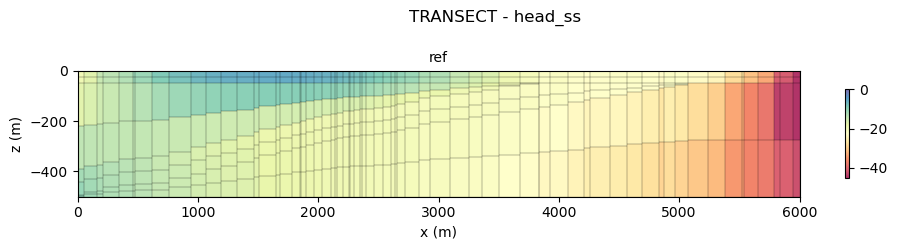

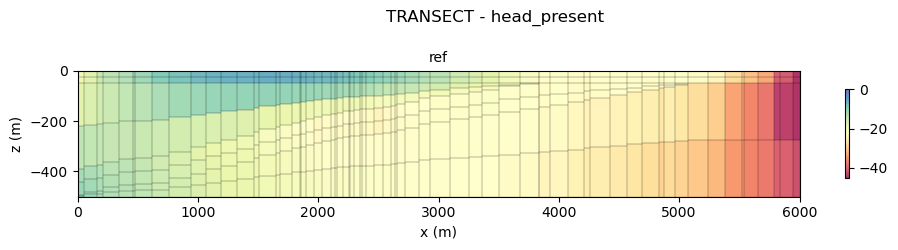

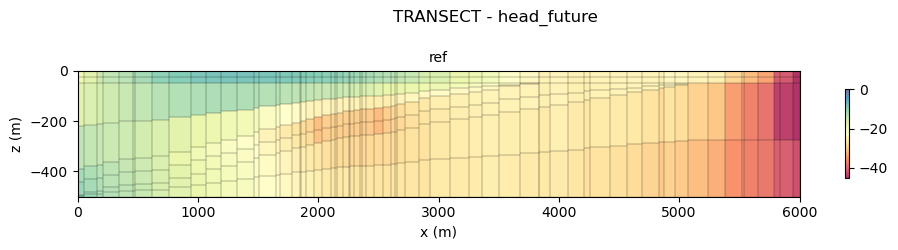

In [13]:
multiplot_prop_transect(P, models = [R], array = 'head_ss', 
                        X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,
                        vmin = -45, vmax = 0)
multiplot_prop_transect(P, models = [R], array = 'head_present', 
                        X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,
                        vmin = -45, vmax = 0)
multiplot_prop_transect(P, models = [R], array = 'head_future', 
                        X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1, 
                        vmin = -45, vmax = 0)

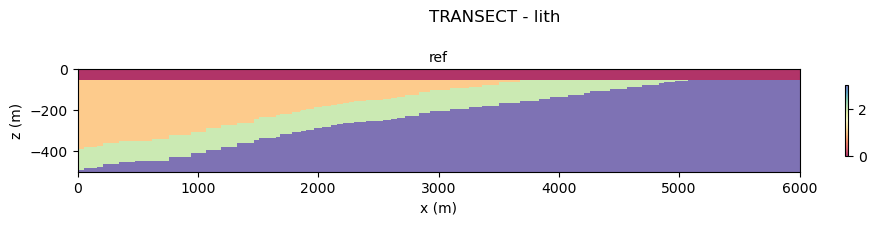

In [14]:
multiplot_vgrid_transect(P, models = [R], array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1) 

In [15]:
#f = os.path.join(vtk_workspace, "test", R.modelname)
#R.gwf.export(f, fmt="vtk")

In [16]:
#plot_flow_features(P, [R])
#multiplot_prop_transect(P, models = [R], array = 'logk11', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1)

In [17]:
#y_ = [1000,1500,2000,2500,3000,4000,5000]
#for y in y_:
#    multiplot_prop_transect(P, models=[R], array ='head_future',X0=P.x0, Y0=y, X1=P.x1, Y1=y, vmin = -45, vmax = 0)

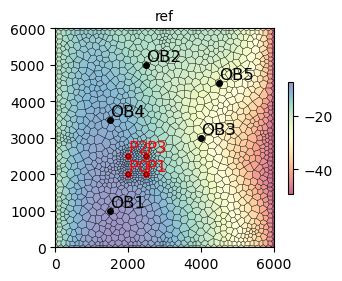

In [18]:
plot_bylayer(P, models = [R], layer = 1)#, vmin = -20, vmax = 5) 

In [19]:
#multiplot_prop_plan(P, models = [R], array = 'k11', layer = 3)#, vmin = None, vmax = None):   # array needs to be a string of a property eg. 'k11', 'logk11'  


### Testing convergence

In [20]:
#loghk0, loghk1, loghk2, loghk3 = 0.27972511989404736, -1.9442518204215036, 0.38322898929495725, -1.2905279279633497
#logvk0, logvk1, logvk2, logvk3 =  -0.5824396583949223, -2.4754872268614063, -0.3344909931386087, -2.640047841390039
#logss1, logss2, logss3 = -4.517405710106817, -4.610738280002378, -4.712335701038782
#sy0 =  0.11386417979259696
#cp =  -160.4664408080099
#
#P.hk = [10**loghk0, 10**loghk1, 10**loghk2, 10**loghk3]
#P.vk = [10**logvk0, 10**logvk1, 10**logvk2, 10**logvk3]
#P.ss = [0.00009, 10**logss1, 10**logss2, 10**logss3]
#P.sy = [sy0, 0.1, 0.1, 0.1]
#
## Initiate TEST
#P.control_points = (['CP1', 'control', 3000, 3000, cp, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
#P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
#P.geomodel = create_geomodel_loopshowcase(P, include_fault = False)
#T = Model('test', P, plan = 'vor', transect = 'con') 
#T.create_lith_dis_arrays(P)     # Create lithology and discretisation arrays (DIS)
#T.create_prop_arrays(P)         # Create property arrays (NPF)
#T.create_flow_package_arrays(P) # Create flow packages (CHD, RCH, IC, WEL, OBS)
#print(T.modelname, ' has ', T.ncell_disu, ' nodes.')
#
#T.gwf, T.head_ss, T.obs_ss, T.runtime_ss = T.write_run_model(P, period = 'Steady', ic_array = P.strt) 
#T.gwf, T.head_present, T.obs_present, T.runtime_past = T.write_run_model(P, period = 'Past', ic_array = T.head_ss)
#T.gwf, T.head_future, T.obs_future, T.runtime_future = T.write_run_model(P, period = 'Future', ic_array = T.head_present)
#
#T.angle2_disu = T.gwf.npf.angle2.array
#multiplot_prop_transect(P, models = [T], array = 'angle2_disu', X0=P.x0, Y0=P.y0, X1=P.x1, Y1=P.y1)

In [21]:
def plot_problem_cell(P, gwf, X, Y, Z, vmin = None, vmax = None): # array needs to be a string of a property eg. 'k11', 'angle2'
    a = gwf.npf.k.get_data()
    fig = plt.figure(figsize = (10,3))
    ax = plt.subplot(121)
    ax.set_title("West-East Transect\nY = %i" %(Y))
    xsect = flopy.plot.PlotCrossSection(modelgrid=gwf.modelgrid, line={"line": [(P.x0, Y),(P.x1, Y)]},
                                        geographic_coords=True)
    csa = xsect.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    ax.plot(X, Z, 'o', color = 'red')
    ax.set_xlabel('x (m)', size = 10)
    ax.set_ylabel('z (m)', size = 10)
    linecollection = xsect.plot_grid(lw = 0.1, color = 'black') 
    
    ax = plt.subplot(122)
    ax.set_title("South-North Transect\nX = %i" %(X))
    xsect = flopy.plot.PlotCrossSection(modelgrid=gwf.modelgrid, line={"line": [(X, P.y0),(X, P.y1)]},
                                        geographic_coords=True)
    csa = xsect.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    ax.plot(Y, Z, 'o', color = 'red')
    ax.set_xlabel('y (m)', size = 10)
    ax.set_ylabel('z (m)', size = 10)
    #ax.set_xlim([1000, 3000])
    #ax.set_ylim([-68, -48])
    linecollection = xsect.plot_grid(lw = 0.1, color = 'black') 
    
    fig = plt.figure(figsize = (6,6))
    ax = plt.subplot(111)
    ax.set_title("Plan")
    mapview = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid, layer = 0)#, geographic_coords=True)
    plan = mapview.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    ax.plot(X, Y, 'o', color = 'red')
    ax.set_xlabel('x (m)', size = 10)
    ax.set_ylabel('y (m)', size = 10)
    linecollection = mapview.plot_grid(lw = 0.1, color = 'black') 
    
    #plt.colorbar(csa, shrink = 0.7)
    plt.tight_layout()  
    plt.show()  

In [22]:
#node = 2731-1
#sim = flopy.mf6.MFSimulation.load(sim_name = 'sim', sim_ws = '../modelfiles')
#gwf = sim.get_model('test')
#
#print("minimum cell thickness = %f at node %i" %(T.gwf.modelgrid.thick.min(), T.gwf.modelgrid.thick[node]))
#
#X = T.gwf.modelgrid.xyzcellcenters[0][node]
#Y = T.gwf.modelgrid.xyzcellcenters[1][node]
#Z = T.gwf.modelgrid.xyzcellcenters[2][0][node]
#print("XYZ problem = ", X,Y,Z)
#
#xv = T.gwf.modelgrid.xyzvertices[0][node]
#yv = T.gwf.modelgrid.xyzvertices[1][node]
#zv_top = T.gwf.modelgrid.xyzvertices[2][0][node]
#zv_bot = T.gwf.modelgrid.xyzvertices[2][1][node]
#xv, yv, zv_top, zv_bot
#print('cell width approx ', max(xv) - min(xv))
#print('cell length approx ', max(yv) - min(yv))
#print('cell thickness', zv_top - zv_bot)
#
#plot_problem_cell(P, T.gwf, X=X, Y=Y, Z=Z)

### 14. Create "truth" observations and plot observations

In [23]:
R.ref_steady  = process_obs_steady(P, R)
R.ref_past    = process_obs_past(P, R)
R.ref_future  = process_obs_future(P, R)

In [24]:
if not os.path.isdir('../results'):
    os.makedirs(workspace, exist_ok=True)
    
fname = '../results/ref_ss.pkl'
pickle.dump(R.ref_steady, open(os.path.join(P.workspace, fname),'wb'))
fname = '../results/ref_past.pkl'
pickle.dump(R.ref_past, open(os.path.join(P.workspace, fname),'wb'))
fname = '../results/ref_future.pkl'
pickle.dump(R.ref_future, open(os.path.join(P.workspace, fname),'wb'))

In [25]:
# Get times
csv_file = os.path.join(P.workspace, R.modelname + "_past.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365

csv_file = os.path.join(P.workspace, R.modelname + "_future.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365+2

Text(0, 0.5, 'Head (m)')

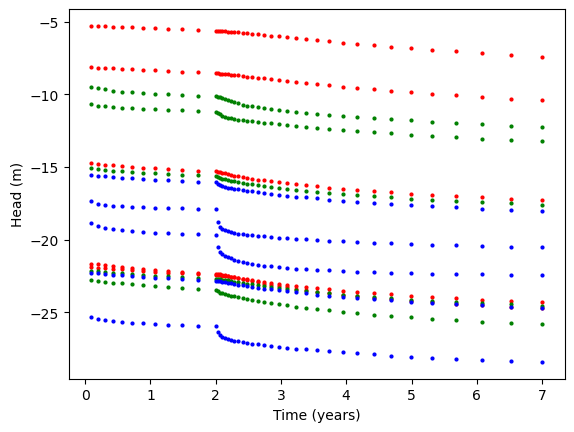

In [26]:
colors = ['red','green','blue']
R.ref_future.shape
for j in range(P.nobs):
    for i in range(P.nzobs):
        plt.plot(times_past, R.ref_past[j][i],'o', ms = 2, color = colors[i])
        plt.plot(times_future, R.ref_future[j][i],'o', ms = 2, color = colors[i])
plt.xlabel('Time (years)')
plt.ylabel('Head (m)')

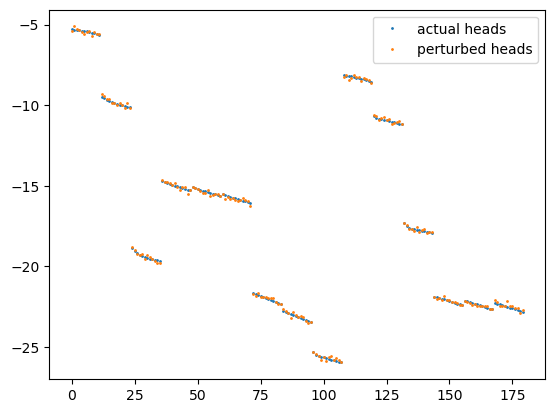

In [27]:
# CREATE SYNTHETIC OBSERVATIONS BY PERTURBING ACTUAL HEADS
err = 0.1
hobs_ref = np.copy(R.ref_past)    
for i in range(P.nobs):
    for j in range(P.nzobs):
        for k in range(hobs_ref.shape[2]):
            hobs_ref[i][j][k] += np.random.normal(0.,err) # Perturb samples either side of measurement
plt.plot(R.ref_past.flatten(), 'o', ms = 1, label = 'actual heads')
plt.plot(hobs_ref.flatten(),'o', ms = 1, label = 'perturbed heads')
plt.legend()

### 15. Set up Markov Chain Monte Carlo (MCMC)

#### Define statistics of parameters

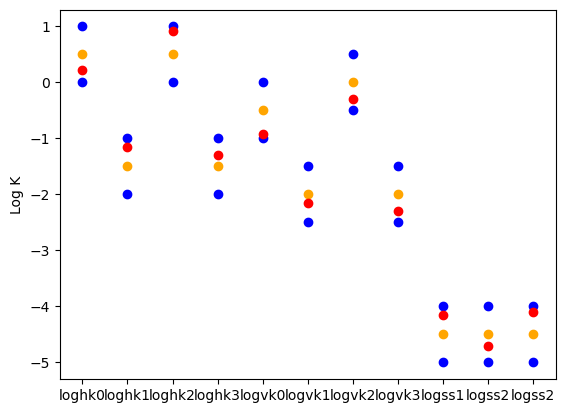

In [28]:
k_min = [0, -2, 0, -2, -1, -2.5, -0.5, -2.5, -5, -5, -5]
k_max = [1, -1, 1, -1, 0, -1.5, 0.5, -1.5, -4, -4, -4]

k_mean = [(k_max[i] - k_min[i])/2 + k_min[i] for i in range(len(k_min))]
plt.plot(np.linspace(0,10,11), k_min, 'o', color = 'blue')
plt.plot(np.linspace(0,10,11), k_max, 'o', color = 'blue')
plt.plot(np.linspace(0,10,11), k_mean, 'o', color = 'orange')
plt.plot(np.linspace(0,10,11), logfunc(reference[0] + reference[1] + reference[2][1:]), 'o', color = 'red')
plt.ylabel('Log K')
plt.xticks(np.linspace(0,10,11), ['loghk0', 'loghk1', 'loghk2', 'loghk3', 
                                'logvk0', 'logvk1', 'logvk2', 'logvk3',
                                'logss1', 'logss2', 'logss2'])#, logss1, logss2, logss3, sy0, cp])
plt.show()

In [88]:
def Likelihood(obs, mod, err):
    return(np.sum(-(obs-mod)**2/(2*err**2)))

#from DREAM import *
%run ../../Lab_tools/Uncertainty_tools/DREAM.py

Unif = [] # True = Uniform, False = Normal
Log = []  # ?? Just put False
Mean = []
Width = []  # for uniform distributon the range,  for normal, the standard deviation
Min = []
Max = []

###K values
for i in range(len(P.hk)):
    Unif.append(True) # True if uniform, False if normal
    Log.append(False) # Ignore
    Mean.append(10**k_mean[i])
    Width.append((10**k_max[i] - 10**k_min[i])/2.)
    Min.append(10**k_min[i]) 
    Max.append(10**k_max[i]) 

#make this anisotropy
for i in range(len(P.vk)):
    Unif.append(True) # True if uniform, False if normal
    Log.append(False) # Ignore
    Mean.append(10**k_mean[i+4])
    Width.append((10**k_max[i+4] - 10**k_min[i+4])/2.)
    Min.append(10**k_min[i+4]) 
    Max.append(10**k_max[i+4]) # Changed 18/8
    
for i in range(3): # 1e-4 to 1e-6 # Botom 3 layers
    Unif.append(True) # True if uniform, False if normal
    Log.append(True) # Ignore
    Mean.append(5e-5)
    Width.append(2.5e-5)
    Min.append(1e-5) 
    Max.append(1e-4)
    
#Sy top geo layer #0.05 - 0.2
Unif.append(True)
Log.append(False)
Mean.append(0.125)
Width.append(0.075)
Min.append(0.05)
Max.append(0.2)

#Control points z value
Unif.append(True)
Log.append(False)
Mean.append(-125)
Width.append(125)
Min.append(-250)
Max.append(0)

In [89]:
MCMC = [Min, Mean, Max]
pickle.dump(MCMC, open('../results/MCMC.pkl','wb'))

#### Set up DREAM and define "run model" function

In [99]:
## DREAM for Steady State
nchains = 5     #number of parallel chains 
npars = len(Mean)  #number of parameters
nburn = 200
minsamp = 169 # minimum number of samples

D = DREAM(nchains, npars, nburn = nburn, npairs = 1) #nburn is burn in perion, npairs defines how you sample
D.par_set(Log,Unif,Mean,Width,Min,Max) #initialise the class
D.set_CR(ncr=3)  #crossover testing thingy. Use 3
D.k = 1 # Number of things to try each chain. Numbers other than 1 can give weird results for some models

In [100]:
'''# Load DREAM results
pickleoff = open('../results/dream_pars_chain_0_.pkl','rb') # dream_pars (122, 13)
dream_pars_0 = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open('../results/dream_pars_chain_1_.pkl','rb') # dream_pars (122, 13)
dream_pars_1 = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open('../results/dream_pars_chain_2_.pkl','rb') # dream_pars (122, 13)
dream_pars_2 = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open('../results/dream_pars_chain_3_.pkl','rb') # dream_pars (122, 13)
dream_pars_3 = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open('../results/dream_pars_chain_4_.pkl','rb') # dream_pars (122, 13)
dream_pars_4 = pickle.load(pickleoff)
pickleoff.close()

D.chains[0].current = dream_pars_0[-1,:]
D.chains[1].current = dream_pars_1[-1,:]
D.chains[2].current = dream_pars_2[-1,:]
D.chains[3].current = dream_pars_3[-1,:]
D.chains[4].current = dream_pars_4[-1,:]'''


"# Load DREAM results\npickleoff = open('../results/dream_pars_chain_0_.pkl','rb') # dream_pars (122, 13)\ndream_pars_0 = pickle.load(pickleoff)\npickleoff.close()\n\npickleoff = open('../results/dream_pars_chain_1_.pkl','rb') # dream_pars (122, 13)\ndream_pars_1 = pickle.load(pickleoff)\npickleoff.close()\n\npickleoff = open('../results/dream_pars_chain_2_.pkl','rb') # dream_pars (122, 13)\ndream_pars_2 = pickle.load(pickleoff)\npickleoff.close()\n\npickleoff = open('../results/dream_pars_chain_3_.pkl','rb') # dream_pars (122, 13)\ndream_pars_3 = pickle.load(pickleoff)\npickleoff.close()\n\npickleoff = open('../results/dream_pars_chain_4_.pkl','rb') # dream_pars (122, 13)\ndream_pars_4 = pickle.load(pickleoff)\npickleoff.close()\n\nD.chains[0].current = dream_pars_0[-1,:]\nD.chains[1].current = dream_pars_1[-1,:]\nD.chains[2].current = dream_pars_2[-1,:]\nD.chains[3].current = dream_pars_3[-1,:]\nD.chains[4].current = dream_pars_4[-1,:]"

In [101]:
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "pinchout_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")
    
# Include this here when ignoring structural parameters
#P.control_points = (['CP1', 'control', 3000, 3000, -100, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
#P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
#P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel

In [102]:
def update_model(P, loghk0, loghk1, loghk2, loghk3, logvk0, logvk1, logvk2, logvk3, 
                 logss1, logss2, logss3, sy0, cp):
    print(loghk0, loghk1, loghk2, loghk3, logvk0, logvk1, logvk2, logvk3, 
                 logss1, logss2, logss3, sy0, cp)
    del P.hk
    del P.vk
    del P.ss
    del P.sy
    #P.hk = [10**loghk0, 10**loghk1, 10**loghk2, 10**loghk3] #[1, 0.1, 10, 0.1] 
    P.hk = [loghk0, loghk1, loghk2, loghk3]
    #P.vk = [10**logvk0, 10**logvk1, 10**logvk2, 10**logvk3] #[i/10 for i in P.hk]
    P.vk = [logvk0, logvk1, logvk2, logvk3]
    #P.ss = [0.00009, 10**logss1, 10**logss2, 10**logss3]
    P.ss = [0.00009, logss1, logss2, logss3]
    P.sy = [sy0, 0.1, 0.1,0.1]#[sy0, 0.1, 0.1, 0.1]
    P.control_points = (['CP1', 'control', 3000, 3000, cp, -200, 'c', 'lower', 0., 0., 1.],) 
    P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
    P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel
    M = Model('run', P, plan = 'vor', transect = 'con') # Create flow model 
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    
    results = M.write_run_model(P, period = 'Steady', ic_array = P.strt)   
    M.gwf, M.head_ss, M.obs_ss = results[0], results[1], results[2]
    
    results = M.write_run_model(P, period = 'Past', ic_array = M.head_ss)   
    M.gwf, M.head_past, M.obs_past = results[0], results[1], results[2]
     
    #hobs_steady = process_obs_steady(P, M)
    hobs_past = process_obs_past(P, M)
    return(hobs_past, M)


In [103]:
#this function and argument statement are for the labtools dream implementation.

def L_func(Prop, P, hobs_ref, err):
    hmod, M = update_model(P,
                        Prop[0],
                        Prop[1],
                        Prop[2],
                        Prop[3],
                        Prop[4],
                        Prop[5],
                        Prop[6],
                        Prop[7],
                        Prop[8],
                        Prop[9],
                        Prop[10],
                        Prop[11],
                        Prop[12],
                        ) 
    a = np.array(hobs_ref) 
    b = np.array(hmod)
    P.hmod = hmod
    P.M = M
    return(Likelihood(a,b,err))
    
    
args = (P, hobs_ref, err,) # P - project object, hobs_ref - real observations, err - 
    
def result_func(Prop,P):
    M = P.M
    hpred = run_prediction(M, ic_array = M.head_past)
    overall = np.append(P.hmod,hpred,axis=2)
    #print(overall)
    return(overall)

Rfunc_args = (P,)
    

In [104]:
def run_prediction(M, ic_array):
    results = M.write_run_model(P, period = 'Future', ic_array = ic_array)   
    M.gwf, M.head_future, M.obs_future = results[0], results[1], results[2]
    hpred = process_obs_future(P, M)
    return hpred

In [105]:
"""for i in range(nchains):
    D.chains[i].current = ldum[i]"""


results = Dream_ZS(D,       # DREAM class being used.
                   L_func,  # function that recieves the proposed pars, places in model, runs model & returns Likelihood 
                   args,    # contains all the args for the model outside of the parameters
                   result_func = result_func,      # save the model outputs
                   result_func_args = Rfunc_args,  
                   minsamp = minsamp,         
                   print_freq = 1,
                   Test = False,      # If True, only initial likelihoods obtained
                   lookback = 10,
                   R_overide = False)  # Stops even if R=1.2 not reached

1.7879071027974887 0.07535351720196536 8.050767592382085 0.0222541276056207 0.5873594541786744 0.006704749703262356 1.9963145956402613 0.0038943254455186304 6.515885855271409e-05 2.140780812545712e-05 1.4746019634564407e-05 0.12117205784872813 -200.46762386385458
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.994236
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.332754
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.899705
Initial Likelihood for chain  0  =  -248.90149375255797
1.7512716480072854 0.08089484949084025 8.077692318376348 0.020460620036386674 0.6051188315634587 0.006693465690236298 1.6547915113964502 0.004126016237455627 6.0449219858120584e-05 2.221252212452161e-05 2.1680775849994807e-05 0.10282576442228873 -200.4996209594059
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.77731
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.43895
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.33939


Initial Likelihood for chain  1  =  -244.12695195826515
1.745361962621515 0.07755536880709098 8.102850674191233 0.02066385425034302 0.5287580687289889 0.00680654642652501 1.8184130717296236 0.004675846293948427 6.032583926790316e-05 2.0879989078929298e-05 1.322439715139303e-05 0.11391529604105775 -200.46887346301742
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.83519
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.741516
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.398478
Initial Likelihood for chain  2  =  -241.10907050053083
1.719273495741517 0.08452212387092195 8.27879642183634 0.012823279201623888 0.5220329615304351 0.006746174720943653 1.2186860915525044 0.004897429878112536 5.6104190890197614e-05 2.634072632238807e-05 2.9173143956564348e-05 0.12806128902152522 -200.47049609282266
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.892785
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.387244
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.22999
Initial Likelihood for chain  3  =  -229.7213103170114
1.7190261637858635 0.08495650982976444 8.109685633929253 0.022586285690237264 0.5498350640366815 0.006774500429750927 1.5637031889130497 0.003872695519609324 5.843951946316293e-05 2.2613033067967474e-05 1.4995762280188915e-05 0.11561426476354669 -200.50039130679934
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.795209
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.048005
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.576796
Initial Likelihood for chain  4  =  -227.31640864981466
8.794366073417125 0.07535775818254815 8.050456091815784 0.041101324028111674 0.5873555165113973 0.006703935963780431 1.9960333648888513 0.007962826250924504 7.527836184720162e-05 2.1408276019766077e-05 1.4744178372534713e-05 0.07379241430643789 -210.8957779588794
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.846717
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.118025
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.871541


1.786423629703154 0.07535775818254815 8.842695010017824 0.0435610489396419 0.5873555165113973 0.006703935963780431 1.2387026946649025 0.0038945264231207218 8.885628327066324e-05 2.4528668873996683e-05 1.4744178372534713e-05 0.08554950584940939 -200.49245085332603
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.824786
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.520052
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.869883
1.787344044104852 0.09638039606936656 8.84224271810449 0.04356060772855709 0.6162421482680092 0.006705657255942246 1.2386481463007235 0.010006608217661509 8.885585000782822e-05 2.4522607790255282e-05 1.475064648578016e-05 0.08555166284730069 -200.45836648062496
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.839021
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.504889
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.303933
1.7519779510253042 0.08089881798708679 8.078313795452408 0.02046234715356624 0.6050469320595769 0.006695242969744733 1.6547795241211811 0.00412617313454625 6.045537149650444e-05 2.2211368276814377e-05 2.168171803505267e-05 0.10283856892571672 -200.5203408671412
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.803184
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.559041
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.85845


4.2697523018791355 0.06842347819976387 6.963268897421239 0.019303972681306528 0.5892366569357069 0.01082914409886921 1.7191798408841585 0.003204795645518065 7.272441563755145e-05 1.2270532772325864e-05 2.6996885952611763e-05 0.11217518459395313 -199.06964717363527
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.825323
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.680449
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.40742
1.7017472607893398 0.08101406859673381 8.874311934515513 0.031529192984202 0.7908007456552364 0.003619495332654596 1.9794241607702199 0.0316055635196017 8.209844817184131e-05 8.943768513625759e-05 9.786223931831621e-05 0.061453475338314335 -229.94216622579265
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.004247
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.867195
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.312094
1.7454696684571467 0.07756012002119533 8.103462419366757 0.02183192261859848 0.5287630444782423 0.03113202885825775 1.8187918764534348 0.004679225402761805 6.0325254633913716e-05 3.081663185571622e-05 1.3226468255978234e-05 0.11390998694994207 -201.9429612894806
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.95035
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.163841
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.361887
1.7454696684571467 0.07756012002119533 8.103462419366757 0.02183192261859848 0.5287630444782423 0.03113202885825775 1.8187918764534348 0.004679225402761805 6.0325254633913716e-05 2.0875796419306317e-05 1.3226468255978234e-05 0.11390998694994207 -200.49660873215294
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.848036
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.246598
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  29.55914
1.7454978663865186 0.07757876086437451 8.883806886876764 0.030180182001464603 0.5310541206901025 0.03112999254222708 1.7313420784374876 0.004679996149781918 4.167381610382794e-05 2.087303259014611e-05 9.057396477512291e-05 0.11391418869347507 -200.4871921364079


   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.96695
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.456766
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.116061
4.277058624033414 0.059984974576559644 6.369243624698926 0.09920492406697284 0.5568988771618819 0.03128898860734405 2.0400364842053467 0.0074087891373379455 5.480202078500284e-05 1.3275042475751678e-05 2.8737585750053282e-05 0.12565336655262035 -215.54813296896745
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.924222
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.129173
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.789486
4.065405906743869 0.09045116975597947 7.155708438196836 0.09294128789610201 0.7287698031221044 0.012083921745284809 2.6580113745965726 0.0063267610686534815 6.950710178996109e-05 8.880204035056285e-05 2.155215857977178e-05 0.13080529874394203 -51.61250484180397
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.766223
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.357937
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  19.708367


4.277729590617984 0.059977301400582377 6.368108848457735 0.09921202556384523 0.5569870135077069 0.031288783860138385 2.0399017915847333 0.007407846193379971 5.4804649112279666e-05 1.32677817569115e-05 2.872659152940879e-05 0.12570138952207371 -215.56029726883745
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.966721
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.075389
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.642839
1.718796192536188 0.08076873740856212 8.14404738905309 0.09619079697716902 0.5185566167574367 0.011015108894993067 1.6783739931986357 0.02482959895759191 5.843731759851833e-05 2.2605790447075847e-05 1.4998082413831365e-05 0.17474978566903185 -173.2117160966681
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.463443
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.351296
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.987668
1.718796192536188 0.09336239915644977 1.0550698465061839 0.018419186504998793 0.5498036015158113 0.0038073765865305888 1.9382867052102386 0.003871424086310983 6.78093531402403e-05 9.977037907048133e-05 8.586585640102835e-05 0.12402947752082626 -203.9900586434652
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.780942
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.058009
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.954172
1.7190606738705319 0.08076382815512764 8.145554963388701 0.09619474148935564 0.5186856035230021 0.031425300833773456 2.4352395050506424 0.028269050676224716 5.8442564443180835e-05 2.2607384894093e-05 1.5005219895041986e-05 0.17473692220837606 -173.22161565354847
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.201645
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.232236
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.172723


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  1
sampled =   4.0  tried =  5.0
Currenty sampling at a rate of  80.0 %
Current Likelihood for chain  0  =  -3926.2463900841394
Current Likelihood for chain  1  =  -244.12695195826515
Current Likelihood for chain  2  =  -68932.62425243306
Current Likelihood for chain  3  =  -277466.22447929234
Current Likelihood for chain  4  =  -85681.34828922682
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
1
1.1512729258147274 0.08477848495656243 1.4433661196293688 0.029269662145062336 0.7303450042275239 0.015143279978494687 1.884864837822161 0.02515775668143928 8.837234255993512e-05 9.36393145476382e-05 9.554559745896936e-05 0.10721991443726625 -203.986312625724
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.76198
   Writing simu

Period =  Past 
   Model success =  True
   run_time =  31.589346
1.1512729258147274 0.08477848495656243 1.4433661196293688 0.029269662145062336 0.7303450042275239 0.015143279978494687 1.884864837822161 0.02515775668143928 8.837234255993512e-05 9.36393145476382e-05 9.554559745896936e-05 0.10721991443726625 -203.986312625724
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.788188
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.553283
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  37.973977
1.1499037790563773 0.08477436263214634 1.4426389338214494 0.02928520974252801 0.7303620639830638 0.015142761552421904 1.8846371754505384 0.025155977874484103 8.836799207198221e-05 9.365079431259019e-05 9.555477321902402e-05 0.10722405829224017 -204.020844325805
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.773363
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.137407
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  29.244866


1.7524268294835808 0.08087467059616471 8.079075326088939 0.020467587512602393 0.4036039151417798 0.006698811433011677 1.6546291422154908 0.004181450674361524 6.0447915877615237e-05 3.5038681995621224e-05 4.082622106768787e-05 0.10284279976047843 -170.640885676576
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.896878
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.309246
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.154437
8.163004835354728 0.08087467059616471 8.079075326088939 0.020467587512602393 0.6134567655534849 0.006698811433011677 1.6546291422154908 0.004229681709374108 6.0447915877615237e-05 2.1122194444370763e-05 2.493169627989782e-05 0.10284279976047843 -200.48645833656033
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.126257
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.41786
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  29.007914


9.559374721355935 0.09057866534532266 8.90843732583455 0.019056661728542607 0.3855680182223821 0.02569864060429527 1.4858394121155831 0.012310642871871592 6.215427384031724e-05 3.939744334879149e-05 3.441274550364017e-05 0.12572748011486626 -151.09390239421646
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.824748
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.560548
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.142358
4.3360124147744505 0.06394581182877128 6.53667390360604 0.01973939923551487 0.35457694101090753 0.02693656454281291 1.288107740300846 0.004369671156226698 6.426685776279295e-05 3.5413254740172344e-05 3.3062841626142174e-05 0.15137591650795132 -170.61824144250593
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.93836
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.63739
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.357573
4.304438388636658 0.06647142225529505 6.210778840028795 0.044304458661049415 0.32246479247844767 0.0311307883406306 1.4933381942939303 0.014141252823320611 6.032185298688174e-05 3.45157389161131e-05 1.3222214554114268e-05 0.19301118434136597 -158.14365641749166
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.099383
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.430754
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.951199
3.1411538233792884 0.07364823038004348 7.364121626349691 0.018346408392422294 0.3365840393542959 0.01746930074777528 1.119438629456745 0.012502085695538446 6.597164789264837e-05 3.977078032559493e-05 2.6655269848695108e-05 0.17426580369037004 -150.43791439697694
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.777432
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.257191
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  21.258178
4.289162926466145 0.058490139439409755 6.352712339471128 0.06450614955013118 0.5615944837746311 0.012226268541408163 2.105728679513635 0.02646534077677861 5.568534327865995e-05 1.2481716572904955e-05 2.7903713150123624e-05 0.09724619944625061 -228.33773968085728
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.763128
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.083478
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.75841
5.4700564991565725 0.050286874811031335 5.542959144237884 0.010620842286542758 0.5747263058367609 0.012299530338959214 2.208997445672599 0.027739379590752466 5.310733853612954e-05 9.893401602345781e-05 3.514362653216005e-05 0.10272752265733916 -235.39837895195157
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.317455
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.32814
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.957533
4.290266441222807 0.05848085529536804 6.352097191191379 0.06451838638147889 0.5616190976101818 0.012224838056376724 2.1061334197411337 0.026457324519567543 5.567836410990108e-05 1.247954430839503e-05 2.7914948826253766e-05 0.0972208851792644 -228.34360827889836
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.758996
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.359478
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.368607


1.7196145024227143 0.08076453691689439 7.345126468647071 0.042919015303497225 0.5186430138170826 0.011029864033178167 1.8586189209004949 0.026358575482667596 5.843462454377338e-05 2.2611212236502523e-05 1.82863025966813e-05 0.1747212839593565 -173.20851221205515
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.767198
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.396465
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.558897
1.7196145024227143 0.07186341628923514 8.143341438588411 0.09616505017609225 0.5186430138170826 0.011029864033178167 1.6788082357395429 0.024826318186690646 5.6268916205491246e-05 1.869322175266879e-05 2.5137000612314795e-05 0.1747212839593565 -173.20851221205515
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.795941
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.46026
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.805576
1.7188143750095304 0.07185992097108722 8.144332471917036 0.0961814315281502 0.5186541583144161 0.02042005449356483 1.678858141010391 0.024818124735649205 5.626775598897309e-05 1.867642723180899e-05 2.514126003555432e-05 0.17471472967127014 -173.23066000052953
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.783535
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.369412
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.912628
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  2
sampled =   8.0  tried =  10.0
Currenty sampling at a rate of  80.0 %
Current Likelihood for chain  0  =  -2316946.705169386
Current Likelihood for chain  1  =  -206723.5316351181
Current Likelihood for chain  2  =  -68932.62425243306
Current Likelihood for chain  3  =  -366440.32158285385
Current Likelihood for chain  4  =  -85897.38511022122
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
2
1.1497244849544925 0.08747339503902202 1.4425354611869226 0.029575756164344078 0.830331779636622 0.012059938671240812 1.8847704611319023 0.025153482116732358 9.676392676053882e-05 7.577011480998792e-05 9.552901060006214e-05 0.10722502611682781 -204.00130897154293
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time take

Period =  Past 
   Model success =  True
   run_time =  27.37389
1.1497244849544925 0.08478009819436472 3.0278647864136885 0.02928472495147646 0.9997916390412975 0.01513616744083603 1.8847704611319023 0.025153482116732358 8.838263445002528e-05 6.203718758795768e-05 7.651529579884377e-05 0.10722502611682781 -204.00130897154293
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.77552
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.208981
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.991385
1.2150739249300542 0.08206768450232477 2.5898367952315047 0.028972517367888164 0.8056223320394752 0.018220053681939834 1.366532019829058 0.02603191827003224 8.001450675140363e-05 8.588715190834734e-05 8.70955046483974e-05 0.14053554111820277 -175.0880767349865
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.745254
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.697795
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.711149
2.9331928007363666 0.08087695060048893 7.267538983848084 0.05658183397804766 0.40339517447440754 0.006773128111669147 1.654861868642852 0.0041812185669616855 6.04470902570356e-05 3.503843813740255e-05 4.0836079790865626e-05 0.1083681150732847 -177.78528936132508
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.923465
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.617491
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.655796
2.8938074844750465 0.09294768742169256 8.060024066985893 0.0590415426862814 0.352646781859546 0.01482566491453708 1.654861868642852 0.0041812185669616855 6.04470902570356e-05 3.8158830981301e-05 4.6591709240263736e-05 0.10288687180147804 -161.0091541173175
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.853228
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.350555
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.780361
2.6536260384421184 0.08268640965822849 4.168868077956266 0.060683610578912583 0.46189937179088825 0.010712889229363825 1.7627316484245168 0.014002339359466208 7.347836416771107e-05 6.837752637551334e-05 7.534188296462088e-05 0.11042386632470627 -179.4493852196761
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.760206
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.865034
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.351497
9.282811587621456 0.08982493125889367 5.8148001302581935 0.09541343445621975 0.6075193943170127 0.004027856974693513 1.7156061127105549 0.004066385170126563 7.559034257804976e-05 5.8772234173049406e-05 4.478944691157962e-05 0.11855869943829166 -189.26411366401555
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.771665
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.844973
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.428148
2.235235976454508 0.08563870096385029 5.848500953130839 0.07903060895795498 0.5762711530515505 0.008270880656688327 1.8305130812260093 0.025024561415183534 7.90488204729964e-05 5.2418992667276414e-05 5.542713456174479e-05 0.1777045795156567 -162.4479287870793
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.737353
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.096914
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.253488
9.282474534215599 0.057864241923233486 5.0106005404742415 0.06698067079224544 0.4402972257390819 0.004164899257243958 1.7160181999415771 0.024203140208844596 7.559154579145347e-05 5.8754631881376453e-05 5.112715785583082e-05 0.11857386690109929 -189.30014358043354
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.781948
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.388355
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.993294
2.294298194697336 0.0747393514010749 7.112581494946991 0.06450536905688431 0.5421098325688931 0.01223189093675477 1.2330893866564792 0.030527605292044162 5.567591029097566e-05 2.1971521778589963e-05 2.303022800523747e-05 0.09724954112074431 -238.63231317987328
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.024333
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.165357
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.168961
4.288603221248773 0.0766109134418491 6.355132445953192 0.03326952410687404 0.6409663230717837 0.014158747902771633 2.1054610684878097 0.030680774288970137 5.567591029097566e-05 5.5126873686704615e-05 6.0626295848948345e-05 0.09724954112074431 -228.31839521185654
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.785199
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.869792
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.317543
8.8759439052549 0.06996215076070784 8.684369124918002 0.07531333301848359 0.4938503329837628 0.015224484861999125 0.387827976178286 0.02848241888746904 5.06090352920193e-05 2.502664584880738e-05 1.61482048569584e-05 0.06640216412813855 -167.43157827734802
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.762036
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.004271
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.660641
1.7218804024801493 0.06904731359261183 8.141212042097749 0.09615831592041514 0.5185612237930294 0.011597912026860653 1.678733983796559 0.027478609367768005 5.626335159731274e-05 1.87015782497031e-05 2.512099239704722e-05 0.13855813025110292 -203.20803343202027
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.745906
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.727378
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.567331
1.0736650790863471 0.071861558352775 8.141212042097749 0.09615831592041514 0.5185612237930294 0.011029969375041356 1.678733983796559 0.024819020363093056 5.626335159731274e-05 1.87015782497031e-05 2.512099239704722e-05 0.18860518627144746 -173.18618144941323
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.781883
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.329934
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.050443
4.347237000150739 0.04182472402594733 5.796106730772284 0.09617922762559114 0.5184833336154346 0.010754878515292374 1.9820635267249744 0.030844094228348315 5.626098060513559e-05 1.8698118819298804e-05 2.6331001205353355e-05 0.16945139247474467 -203.12293443348142
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.789526
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.801451
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.083522
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  3
sampled =   11.0  tried =  15.0
Currenty sampling at a rate of  73.3 %
Current Likelihood for chain  0  =  -2316946.705169386
Current Likelihood for chain  1  =  -206723.5316351181
Current Likelihood for chain  2  =  -181879.0740111199
Current Likelihood for chain  3  =  -356832.00136665924
Current Likelihood for chain  4  =  -30852.427091603393
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
3
1.151862730680656 0.08478987997231821 1.4419650193604279 0.029267775292510373 0.7302940291547827 0.015146305230207274 1.8855840141092008 0.02515681797167879 8.836936418511293e-05 8.762269704119275e-05 9.552890576282317e-05 0.10721383209172897 -217.87942110983147
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Addi

Period =  Past 
   Model success =  True
   run_time =  28.556682
1.500100493800587 0.0802744609073038 4.097153182101934 0.029267775292510373 0.7302940291547827 0.014281031242597142 1.8855082065881912 0.0162132210077434 6.695416687059663e-05 7.814110753687976e-05 9.552890576282317e-05 0.10721383209172897 -203.99314702861005
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.758231
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.171731
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.100625
2.9665317351576093 0.06800035504737673 6.388992365077331 0.04570563374107726 0.6515960589125679 0.0129160479219326 1.9884394362295823 0.016815476239152197 5.168792446174032e-05 4.0241813885301774e-05 6.394862499618864e-05 0.10257105844879304 -215.14120579122803
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.80013
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.945474
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.170496


1.7527331718662 0.0808737594491623 8.080504777924439 0.02046279863929937 0.4439537860713618 0.00440912191811655 1.6545969600914636 0.02174303729651001 6.242208761126954e-05 3.5049439190005994e-05 3.922904400317767e-05 0.0861722131834161 -170.61839491019973
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.760365
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.361165
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.887071
1.5442546445879723 0.02288724510288879 8.080504777924439 0.02046279863929937 0.4035543854555191 0.006698294217149012 1.6545969600914636 0.004182567829082337 6.046830678820008e-05 3.5049439190005994e-05 4.492597813531199e-05 0.10285078305953275 -242.0205220292271
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.749714
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.72933
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.880216
1.5452260042415025 0.022912156856707142 8.081475590228099 0.020460223264597167 0.40340090422896446 0.006701043197034161 1.6545420835033997 0.004177318918925712 6.0469858189928944e-05 3.503640398712359e-05 4.496005749056772e-05 0.10287212676023397 -241.98885016667887
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.775081
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.138091
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.049684
9.088010613179357 0.0292999313801385 6.943362167051723 0.09931658612003967 0.806801208986824 0.004022163020481064 2.0623183120045705 0.004057775144051171 1.3618350381320507e-05 4.6031294104259074e-05 4.478249989479762e-05 0.11049492173048996 -22.895925870073597
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.961377
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.289998
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.788568
8.835161623592958 0.08986205820885881 5.813669526933976 0.07876148968062388 0.7421504920758922 0.004022163020481064 1.7151751931519326 0.004057775144051171 1.5845714520818118e-05 5.2130474702857315e-05 5.3088893614479916e-05 0.1131056540098468 -242.00417963274924
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.777122
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.945053
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.234786
8.809498255686849 0.031096480107004724 6.943668515295013 0.09932284277962347 0.8654141787346522 0.00796342710911371 2.169815238032239 0.013876023931905375 2.663950034626972e-05 4.605979115101583e-05 4.476951100328019e-05 0.1125715379751684 -24.557279255561465
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.748955
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.98187
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.446518
2.2934519840322616 0.05792841341098525 7.89182621203214 0.06451528441524662 0.5444113221630502 0.012238341971691177 1.2330454457403057 0.030537436008168377 5.5677120116113625e-05 2.1957571677605235e-05 2.302480187864221e-05 0.05461365920261948 -184.19292249628006
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.770635
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.065648
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.674015
9.85288533701441 0.074772777116579 7.110423255662586 0.08897937215542698 0.5420635237414911 0.012238341971691177 1.2330454457403057 0.030537436008168377 6.314432846589696e-05 2.1957571677605235e-05 1.5790502340335324e-05 0.17110864379700955 -238.64621070257
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.766699
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.584812
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.327666
2.2936821373442613 0.06062212874919351 7.892086338481171 0.0648199337927966 0.54446545067158 0.0091601173181903 1.751654503893535 0.02966880556458187 6.406906332017145e-05 2.1970103984153995e-05 1.243575641374621e-05 0.05461627864353889 -212.61719252771573
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.757073
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.844015
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.693704
1.7206722297459498 0.06905929100920757 8.141281385444778 0.0961773464780851 0.5924949099106693 0.011595073919271576 1.8888579747575311 0.027483133351673635 5.627249698628961e-05 9.819304264009347e-05 2.5122836697894428e-05 0.13857072324141792 -230.87313012264687
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.757799
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.923814
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.705158
1.7206722297459498 0.011072882514232418 8.141281385444778 0.0961773464780851 0.5187570666844528 0.0094461617241291 1.6783553295407914 0.026168767240578265 7.103483073111901e-05 9.033065799540801e-05 3.0819770848749535e-05 0.13857072324141792 -54.904601322252915
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.787376
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.41762
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.001413
1.703932936991639 0.07165124848448971 8.143173825709486 0.09616953268911854 0.6008394860776609 0.011586605914126153 2.083024080888271 0.027600390648564198 5.62695077654977e-05 9.713343786616209e-05 2.8366503365279735e-05 0.14663052223803832 -230.8121869732426
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.874154
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.764395
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.812391
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  4
sampled =   15.0  tried =  20.0
Currenty sampling at a rate of  75.0 %
Current Likelihood for chain  0  =  -2316946.705169386
Current Likelihood for chain  1  =  -220905.87433292865
Current Likelihood for chain  2  =  -129767.93612465722
Current Likelihood for chain  3  =  -47766.50650278588
Current Likelihood for chain  4  =  -355600.66189008165
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
4
1.1518498250434186 0.0847669596580711 1.4433364426975652 0.029279281582189516 0.7302879419638385 0.0151467481491738 1.8847009617586181 0.025158524721957048 8.836742115281018e-05 9.365317842852925e-05 9.554232616140473e-05 0.10720348153737358 -204.0503242825861
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Addin

Period =  Past 
   Model success =  True
   run_time =  28.040098
2.22576381996378 0.0847669596580711 1.4433364426975652 0.04923288795292662 0.7302879419638385 0.0151467481491738 1.7072982091247275 0.025158524721957048 7.312141301392049e-05 9.365317842852925e-05 9.554232616140473e-05 0.10720348153737358 -204.0503242825861
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.75744
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.134836
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.939753
3.86714227172431 0.034515348010322446 2.641219960587222 0.04605155783727132 0.442098183115501 0.02272603871817587 1.3235729737801938 0.0201134209880407 2.5756560510172336e-05 6.631255002779837e-05 7.588193928366937e-05 0.13521217696545554 -140.29062876242602
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747441
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.858905
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.283959
1.5425331089276042 0.022885357027209206 4.850968627640249 0.08725312371205604 0.9116340110573145 0.008786264036002783 3.10325696404492 0.009241336499078738 8.746903982850101e-05 3.5065590879493016e-05 1.7526857268162363e-05 0.14260057361424738 -3.1648287183690513
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.76387
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.121586
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.443577
1.5765368464459615 0.01736847836984507 8.080588171767044 0.020444103776637353 0.19539385596587824 0.008791388585028212 2.687372721123962 0.008954410864811293 2.5877407150607984e-05 2.4555577944659904e-05 8.144481472489669e-05 0.1253075757438525 -33.71574247591445
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.752257
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.042195
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.943187
1.542930916786896 0.02286426623113817 4.850535564221368 0.08727625189025875 0.9117742105403718 0.008783673604743148 3.1034681660502756 0.009246005108949754 8.746066053998638e-05 3.5067052005040846e-05 1.7557253295966106e-05 0.14262466762673004 -3.1933008138472005
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.765123
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.894685
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.720253
1.1428703897467754 0.08479332298386612 1.4448601147584486 0.029282862848146404 0.7300427601625193 0.004023722311801834 2.0629063313842018 0.025156297329007413 1.3620967052247595e-05 9.364244377487905e-05 9.554816413877069e-05 0.10726407176478177 -209.65712596777
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.790437
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.258614
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.652304
9.088586889158496 0.06251499141702906 8.653546085182494 0.08759864778671597 0.8064914702972238 0.005234882062008224 2.4904148044756065 0.02679202969971459 1.0868992707441027e-05 4.603442331693789e-05 1.8453794971381375e-05 0.17976148500813974 -22.897383874865934
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.749876
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.488354
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.82502
9.534326867407152 0.08394049782267904 8.652581649121023 0.08758639294382414 0.8065366122097835 0.009840117970100292 2.489681630353527 0.029607642321619644 1.0873831108011973e-05 6.288178342878187e-05 9.621250055156341e-05 0.17977059528274988 -119.8733197985323
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.792412
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.231183
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.822563
9.666044629309663 0.039687050977543846 8.403823040167538 0.05590271402207316 0.8324061715385196 0.006461878250870995 2.044771815115044 0.004034994806733073 9.80994946405622e-05 4.538533317338051e-05 2.6500851241326817e-05 0.059627052127500975 -37.228193509892044
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747897
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.499712
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.053369
9.867333542068787 0.09436034605814184 8.42680851016245 0.057271842248127806 0.9576011394973776 0.030895511855831115 2.209010354267001 0.004531648987061949 9.795644248757524e-05 3.121169018144043e-05 8.480134113762308e-05 0.0706860484277952 -246.63507756649992
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.767391
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.852121
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.561232
9.668672660895126 0.021323560863090927 8.404109174911728 0.03306392556762985 0.33523012373080074 0.006460292770918201 2.8808133621273564 0.004033376088401186 9.809820296202911e-05 5.634949596078385e-05 2.6507303496847563e-05 0.0596202787362744 -133.9635308277267
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.742048
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.016048
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.742802
1.7217845310038558 0.06907317774833868 8.141087153015805 0.09618157268752592 0.5923993825470019 0.011591675146836867 1.8885532365662077 0.027492923762794226 5.6267826885442776e-05 9.818867995194634e-05 2.5151806506786587e-05 0.13852905552441774 -230.81838934921043
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.803593
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.54099
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.290523
1.7217845310038558 0.06907317774833868 8.141087153015805 0.09618157268752592 0.5923993825470019 0.006051614947540589 2.310133317910365 0.027492923762794226 5.6267826885442776e-05 9.818867995194634e-05 4.705298249818188e-05 0.13852905552441774 -230.81838934921043
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.757463
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.00467
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.706569
1.7200237753533003 0.03585436914472526 6.4331074144232385 0.017895543856484973 0.5928411610718264 0.00483639240526094 1.8817815997884124 0.004757477026992275 5.9017757380593084e-05 9.816135468959447e-05 7.341055265778992e-05 0.06924834471842985 -230.84945460401985
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.797909
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.199697
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.888702


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  5
sampled =   20.0  tried =  25.0
Currenty sampling at a rate of  80.0 %
Current Likelihood for chain  0  =  -1006939.1376068793
Current Likelihood for chain  1  =  -1837048.654512966
Current Likelihood for chain  2  =  -141843.8399333023
Current Likelihood for chain  3  =  -138112.02226007264
Current Likelihood for chain  4  =  -281826.11743792007
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
5
2.4504599334770134 0.05280379004657531 9.63483750744558 0.02080943966108559 0.5633362621065691 0.015286061379298341 1.1545526841702536 0.016827391788832042 5.9330372149008824e-05 1.7328154736904422e-05 1.191737300321774e-05 0.07364561500600805 -131.50459514096377
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.764884
   Writi

Period =  Past 
   Model success =  True
   run_time =  19.68896
8.928238963366574 0.06527917545944764 1.7514014568014618 0.021967829452975266 0.5791461907368748 0.011152182453944644 1.0901206016820832 0.01774876370386787 4.706132795327668e-05 2.72689902633779e-05 9.660220512043581e-05 0.06430887001391503 -132.94156909969192
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.936312
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.790782
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.233992
8.928291933389211 0.06528919510775588 1.7522091240056745 0.021932047839162777 0.5791341613662442 0.0111517133463498 1.089811952165693 0.0177523331316887 4.708047941734741e-05 2.7248194037744874e-05 9.664841786973187e-05 0.06430859062091845 -132.92658732991782
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.962436
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.748942
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.121703
1.2624526278933452 0.026266932815640423 4.85370856117152 0.0872542394905985 0.9117498962306687 0.02978179750685024 3.1344266990728857 0.018810400643887868 8.74745233418295e-05 6.905635629089881e-05 1.7508527493826917e-05 0.13949440663029813 -4.725393983998556
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.744698
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.915168
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.761479
1.795952800239263 0.022897675095267533 7.497007459631944 0.01370063386823187 0.8238901233887193 0.02842288309562003 3.10358072013544 0.02131680890123296 7.221325441198243e-05 3.509351850718135e-05 1.7508527493826917e-05 0.13484069376146474 -20.16023793223278
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.753365
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.035934
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.816548
7.747226304602292 0.02625327614668351 4.85575593309992 0.08725332086368276 0.9118069758662305 0.029778607404955255 3.13438610149019 0.019735873848347258 8.748596974494776e-05 6.905616444980608e-05 1.7485182187038584e-05 0.13950255306365802 -6.265867495961882
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.800601
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.429587
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.743226
9.086714792322397 0.04101681037657466 7.765169609511291 0.08758771367015034 0.9090262029379715 0.00523594092448635 2.8752125573661647 0.026861312690042494 1.0884149934607135e-05 4.601132259069008e-05 3.247949532819756e-05 0.17975575860189985 -22.943562592130352
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.752395
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.095708
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.708915
9.086714792322397 0.06251468325006651 8.652785283621863 0.08758771367015034 0.8066065962559134 0.006180539148649339 2.49080695476052 0.00933531721357755 1.0884149934607135e-05 4.601132259069008e-05 1.8458916502886497e-05 0.18907685462147786 -22.943562592130352
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747013
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.080442
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.985448
2.496358522446231 0.033457384100578025 9.40444531489334 0.07023426636606653 0.5890838728030715 0.029858270903027635 2.7690441893266327 0.03136873118245875 8.528934695821781e-05 2.346697177847989e-05 8.414097142497994e-05 0.06792484775388498 -6.867299305168409
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.755976
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.022405
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.042387
9.667673378759263 0.03420646083116937 8.405243002652853 0.055933906189140105 0.8668368704650384 0.0067286626445511736 2.143109885604281 0.005275564408945842 9.708148314345969e-05 8.065568689078906e-05 3.123687642161835e-05 0.1926788650945719 -62.91989368915852
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746682
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.319095
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.761226
9.699637555322056 0.029526065284482168 2.0510851999066375 0.06306235153254253 0.7790096156635127 0.0053681376053743984 1.921719732349116 0.007781624293677223 8.893868307190135e-05 4.71978151124324e-05 8.739139102507548e-05 0.18803272465064788 -78.34226616030344
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.750913
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.243788
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.750406
9.700437110021461 0.02953776881986839 2.0513739457766462 0.06305259239384693 0.7789523062455864 0.005377845732894042 2.10152138885707 0.007772071848895372 8.632824284194723e-05 4.7231653816849716e-05 8.173504546327394e-05 0.19867846436554507 -99.44149544617592
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.908889
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.711626
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.455053
1.7215798363188644 0.06904524675180572 8.142378490301372 0.09618477746005653 0.5923279163309298 0.006052911936636007 2.3098480488949797 0.027487413518847047 5.626198617221423e-05 9.819374031044138e-05 4.70507073657695e-05 0.13852875951320998 -230.74235309432422
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.932635
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.94098
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.703999
1.812654330219147 0.09729599996762917 7.615840714291041 0.09436293826415089 0.4993111950427386 0.0060555696298161535 2.147963884874547 0.02749143228881069 8.51878098991023e-05 1.4140655719475352e-05 4.705394993033024e-05 0.14229263235615688 -62.78277058519711
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.79087
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.38032
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.832442
4.056435808297111 0.08297591101999423 7.882037556179711 0.09448402992259101 0.6159435750461025 0.02178315818631644 2.157894069794761 0.02592725847684331 6.59756802655388e-05 2.9474033475302387e-05 5.451043018401328e-05 0.1351913932040344 -218.8174895217311
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.759249
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.510215
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.332353
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  6
sampled =   22.0  tried =  30.0
Currenty sampling at a rate of  73.3 %
Current Likelihood for chain  0  =  -1006939.1376068793
Current Likelihood for chain  1  =  -2173007.9676813195
Current Likelihood for chain  2  =  -141843.8399333023
Current Likelihood for chain  3  =  -138112.02226007264
Current Likelihood for chain  4  =  -282007.7475904757
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
6
Minimum likelihood for outlier chains is:  -3955325.419199706
3.339246099736436 0.07773210139669919 1.0848478897354783 0.04923171819535665 0.7305037135867064 0.015141897098091087 2.4057695899361344 0.025805984279911886 7.310321347625028e-05 6.563803741984454e-05 9.553555419171929e-05 0.08457923193724595 -204.14738968306546
   Creating lithology and discretisation arrays 

Period =  Past 
   Model success =  True
   run_time =  22.404522
2.2267005167428624 0.08478920389259108 1.236434384130775 0.06577091464398976 0.9306269314821346 0.015031307191219756 2.587924069373151 0.025146874683976667 7.310321347625028e-05 9.366698600685285e-05 8.884909614900288e-05 0.06440798670708048 -144.00735532018155
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.774799
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.958919
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.989546
8.918430772533235 0.010260562446942725 1.0839525241346653 0.04922688862200467 0.6004633598557093 0.027807739570105815 2.4060800430935028 0.026089648266672497 7.308918524737098e-05 6.56068523494291e-05 8.07931131514103e-05 0.0861192139214973 -204.1307032267197
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.756215
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.904818
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.079146
1.2617629197038165 0.02627836655439765 6.447719849897862 0.08727496073506184 0.9116160783399689 0.02681148318523623 0.8570087624953868 0.018825422714623244 8.749588408169028e-05 6.905707748258628e-05 1.7492472303613386e-05 0.1395406964061053 -244.34966179242215
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.760998
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.054392
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.551458
1.2617629197038165 0.013684884717451712 4.855904480222957 0.07504651601763465 0.7100366327700124 0.00555869913520227 3.134316867343545 0.018885240742816736 8.749588408169028e-05 6.905707748258628e-05 3.662469863660173e-05 0.1395406964061053 -4.718576408865869
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.736957
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.053406
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.547155
1.2604580217632764 0.055143802729738615 4.855763419695 0.08729434531523066 0.8268797484590689 0.029787387883228177 3.051195854796894 0.01882549556339172 8.749433594427666e-05 9.645562783290776e-05 5.389194401181546e-05 0.12301722274855287 -88.16607409114152
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.804904
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.858438
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.801396
9.086529459815129 0.08903731835575934 9.457501883741127 0.0876029572872511 0.9734671087604768 0.005379375387133107 2.490583091444645 0.026807600267524198 2.3695987418077607e-05 4.602568811450615e-05 1.678186970279553e-05 0.19643495673123823 -114.62965623903246
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.045902
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.722472
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.7403
9.086529459815129 0.06254431290464323 9.81257429546783 0.09838444937516325 0.15926808219457858 0.005382008704797598 2.490583091444645 0.026807600267524198 3.694625725610186e-05 4.1115051170789376e-05 9.26943216613033e-05 0.17977855308502338 -94.24460851221511
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.844994
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.023386
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.536672
9.083803053309637 0.07077620938105099 9.81011959104913 0.09835340049202482 0.15902842298647724 0.008470231904155034 2.4905146161577774 0.026813852754273542 3.697102465431778e-05 5.0557775855104186e-05 9.570599189265616e-05 0.17979385344785545 -94.21848249990934
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747987
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.448498
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.971144
9.98380459368247 0.06856977821683771 8.40320098753305 0.05593332091162793 0.8323960706401616 0.0064648106594690675 2.0451547620888477 0.004043615285458981 9.136291766921697e-05 7.275995959259257e-05 2.6497393363508732e-05 0.05963029566588893 -131.04997322221925
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.773015
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.585913
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.772341
9.665295017297868 0.03968574320367251 8.403187145102779 0.05593332091162793 0.8323960706401616 0.0064664294406787965 2.0451547620888477 0.004043973770750526 8.424444863921702e-05 7.276643064766393e-05 2.6497393363508732e-05 0.05962262529175273 -37.164778964862094
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.739816
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.224258
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.245716
9.665553048916715 0.03967697053379321 8.403979537991152 0.05598633897729693 0.832283848581954 0.005776316090527 2.0449382892087793 0.004044953719247249 6.107999214954857e-05 7.276444054301455e-05 2.644783918136065e-05 0.0955363715461949 -37.1884643030027
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.743362
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.127414
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.481051
7.551030104101835 0.06689071017899426 7.787589980363068 0.0853968738962379 0.46986808874247393 0.009316151458675037 1.7233202253238857 0.029229251079994606 7.719729078875556e-05 8.696316662821467e-05 4.9184532095100594e-05 0.08008857461393615 -55.27481390861362
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.749765
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.970066
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.273319
7.551030104101835 0.06689071017899426 7.787589980363068 0.0853968738962379 0.46986808874247393 0.009316151458675035 1.7233202253238857 0.029229251079994606 7.719729078875556e-05 8.696316662821467e-05 4.9184532095100594e-05 0.08008857461393615 -55.27481390861357
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.743184
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.203659
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.066301
2.1982480538008122 0.08382902263010611 9.563493368393145 0.0856071549009772 0.42064869735140126 0.026310702446655218 1.4234049283885806 0.004493416324660802 4.141714086014733e-05 8.696096700274282e-05 4.917791884708241e-05 0.08010689663697719 -63.21850789278432
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.748391
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.436917
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.280364
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  7
sampled =   24.0  tried =  35.0
Currenty sampling at a rate of  68.6 %
Current Likelihood for chain  0  =  -752247.7387245405
Current Likelihood for chain  1  =  -2173007.9676813195
Current Likelihood for chain  2  =  -141843.8399333023
Current Likelihood for chain  3  =  -138317.36946349213
Current Likelihood for chain  4  =  -282007.7475904757
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
7
Minimum likelihood for outlier chains is:  -3534654.811368482
8.991584942789546 0.09911176106691169 1.0853907914805372 0.012123331910438732 0.7304900312908227 0.015140287222148005 2.405433365188939 0.02580546123337315 8.659124015052429e-05 6.563650850549889e-05 9.538028436295258e-05 0.08459852286055182 -7.060876433153851
   Creating lithology and discretisation arrays for

Period =  Past 
   Model success =  True
   run_time =  17.05685
3.340026476535992 0.07773247268078338 1.0853907914805372 0.04921761958327791 0.7316106614204229 0.015140287222148005 2.405433365188939 0.02580546123337315 9.365845606422652e-05 6.563650850549889e-05 9.55838050361607e-05 0.09194206797656591 -1.9070228473142663
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.754968
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.870728
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.176976
8.990169200351852 0.025719605461465407 1.0819393322429065 0.012111665411856464 0.8042907394570111 0.01514392895088019 2.616032266114701 0.025799155307595488 8.65710549221816e-05 6.565560565171709e-05 9.5354794566833e-05 0.08462127520894897 -0.8486309773350552
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.739947
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.163897
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.158086
1.2638590401211613 0.026228263484884495 4.833890495586902 0.052590988529669674 0.9167204712847904 0.02977240168718969 3.1345910651377467 0.018793271809145418 8.74934094354517e-05 6.905281545878078e-05 1.7478578489807297e-05 0.1395099851316285 -4.788068794557333
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.756098
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.948241
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.406046
1.2638590401211613 0.026228263484884495 4.851483063123253 0.08728339591858628 0.9119579461743852 0.02977240168718969 3.1345910651377467 0.018793271809145418 8.74934094354517e-05 6.905281545878078e-05 1.7478578489807297e-05 0.1395099851316285 -4.788068794557333
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.999458
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.936706
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.950986
1.264964421589208 0.02625628491311808 4.853475292376915 0.08724992573154645 0.9121899357883323 0.029768672653644256 3.134534920236267 0.018783885713155018 8.748725496513639e-05 6.902795875618325e-05 1.7449758269868473e-05 0.139517366483703 -4.76931370085756
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.80547
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.968283
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.649193
9.078494395915284 0.05856153257286922 8.653336687031658 0.03230604311679013 0.8359879592890388 0.005236217560692919 2.491314159120937 0.026782532328922158 1.087543812654862e-05 4.6003188125144985e-05 1.8437101358898105e-05 0.1797237191261034 -22.935669719508223
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.997686
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.083702
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.865304
9.090097171594225 0.06252929815287375 8.62496190058404 0.08696604238401122 0.7478102205464395 0.005236217560692919 2.491314159120937 0.026782532328922158 1.2833859183222258e-05 1.6530507223616616e-05 1.8437101358898105e-05 0.1797237191261034 -22.935669719508223
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.792576
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.506807
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.100257
6.456379202855769 0.08420634156279716 2.005147360306683 0.036172205024608016 0.8666665751054269 0.00836384143244489 2.199096048085912 0.00583658237058075 2.0549588810160293e-05 9.408670711868822e-05 9.992260682302443e-05 0.16552116962492905 -37.64492619512718
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.768427
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.104392
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.491348
5.956545273688685 0.03966528478095548 8.40538854886898 0.02323697121628613 0.7967170803516592 0.006476665833091206 2.0455112094776253 0.013906023675916868 2.912975670408325e-05 7.27602894045821e-05 5.021571418587081e-05 0.059632223230535075 -121.05985856430189
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.759604
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.854913
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.18796
5.308685020744319 0.045139332476939825 8.40538854886898 0.04364371788883595 0.9694110197208402 0.0032075049372219527 2.9206114535294194 0.01735862284420414 2.6749399463758862e-05 8.79529185806014e-05 5.6801516985466874e-05 0.09278689218564205 -138.55181810393148
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.764191
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.147268
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.706331
5.092507028253051 0.02514610301375137 6.873274652444284 0.039486881006444485 0.9693732205407868 0.011695190308236623 0.6564564006734188 0.017353362508845064 4.1319659451491774e-05 8.799100247893388e-05 5.680846927158853e-05 0.09320643281508548 -40.52461753623974
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.783089
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.371482
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.043716
1.7242424361970266 0.06907607184910025 4.612443345819972 0.09614616209121507 0.5924604263485344 0.00605244798936903 2.3107568373962053 0.027477612433921664 5.626861652381343e-05 9.816699355219803e-05 4.7039859930118725e-05 0.1385465710862879 -223.49443418518766
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.75662
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.087441
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.961525
1.7242424361970266 0.06907607184910025 8.143728849378196 0.09614616209121507 0.4410669812248479 0.00605244798936903 1.425828822201291 0.027477612433921664 5.626861652381343e-05 7.738341068806541e-05 4.7039859930118725e-05 0.11336693918652185 -64.01647174306169
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.753861
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.224593
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.427231
1.7259843243155262 0.07783932883967858 4.613196488213209 0.09615593168064399 0.46574982815354604 0.0060458022155979755 2.310994915660269 0.009477252499720559 5.629229305904674e-05 9.81648064330261e-05 4.76697294173357e-05 0.15606225336504329 -223.49479419364377
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.770742
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.357374
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.966521
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  8
sampled =   27.0  tried =  40.0
Currenty sampling at a rate of  67.5 %
Current Likelihood for chain  0  =  -225301.03001031425
Current Likelihood for chain  1  =  -2168911.2216117866
Current Likelihood for chain  2  =  -141843.8399333023
Current Likelihood for chain  3  =  -138317.36946349213
Current Likelihood for chain  4  =  -109350.57191218753
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
8
Minimum likelihood for outlier chains is:  -1959882.6030948553
Removing chain 1with average lilihood of -2087993.952871848compared to interquartile minimum of -1959882.6030948553
8.993730889296302 0.09913329767861846 1.0850566966874793 0.012125351005859169 0.7306857223892491 0.015130386209314811 2.406120178981275 0.02580851925019893 8.658522143626823e-05 6.5624848329135

Period =  Past 
   Model success =  True
   run_time =  17.565009
8.993730889296302 0.09913329767861846 1.0850566966874793 0.012125351005859169 0.7306857223892491 0.015133397265880942 2.4060996606211877 0.02580851925019893 8.658522143626823e-05 6.562484832913504e-05 9.53777533133472e-05 0.08458295783254045 -231.17484895736206
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747882
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.368327
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.582994
8.019899204758698 0.07685680995114506 1.1077286630965824 0.07226527055209198 0.5455059784784023 0.0058065712901877314 1.6850114512894807 0.025619479702810418 7.443790130702065e-05 8.363342373200987e-05 9.532008886410431e-05 0.0739318603248469 -139.55854098290447
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.753007
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.069974
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.883004
7.1555262807082345 0.04848641903444788 7.445759463541043 0.059948432146366 0.7059410011455058 0.009148133537741904 2.0739472361061972 0.014510222601421865 7.094124512936295e-05 4.463369850637738e-05 2.7163942932675413e-05 0.07717903674176049 -128.55659645542985
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747551
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.018012
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.576594
4.639495221651599 0.057960599223707984 6.495285366975473 0.08015981765919292 0.5773669960044134 0.020736345092921184 2.0717366008689537 0.016084959953273473 5.073187182890251e-05 2.964601452769576e-05 2.8207953082547284e-05 0.1079974719987415 -213.84806432029265
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.755395
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.928433
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.514137
6.22188611240363 0.056065688292336074 7.797493345004196 0.05992886468486228 0.6969683290500703 0.009150190845498105 1.6659636964509412 0.01640657299266851 7.091272005516944e-05 4.904581925965281e-05 2.4879187035329607e-05 0.07719243326825233 -133.01773556506618
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.753256
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.763097
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.646187
1.0203901424123405 0.05493404832415213 8.298731075113627 0.08757975401563509 0.8158307452384042 0.0052340554975542535 2.8986409181343875 0.02489790801530039 1.088696599598258e-05 4.164665200752556e-05 2.07315471163581e-05 0.1797409265512587 -18.46243787960838
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.755805
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.121426
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.051931
1.0203901424123405 0.05493404832415213 8.298731075113627 0.08757975401563509 0.8158307452384042 0.0052340554975542535 2.8986409181343875 0.02489790801530039 1.088696599598258e-05 4.164665200752556e-05 2.07315471163581e-05 0.1797409265512587 -18.46243787960838
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.800419
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.296791
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.156193
6.528369298917305 0.054933261519077285 8.298933977468193 0.08759940003590966 0.8156804349260006 0.005234916838232232 2.174955856887685 0.02490426611486415 6.857046792475938e-05 4.165357731784715e-05 2.170851606974048e-05 0.19991941041634798 -18.512169174280743
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.814582
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.296727
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.72486
9.661906063693774 0.0396842631257142 8.403480020036815 0.055959100655916645 0.8323340130016416 0.0064563720865258535 2.045848517941077 0.004052249009528567 8.420184511854874e-05 7.276121146515497e-05 2.6501235730119573e-05 0.05960957341978947 -37.10065463907773
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.815326
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.822675
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.081232
8.689531710641658 0.017421533912590652 8.426846523003523 0.026108337598637402 0.6473278500413534 0.025588167107199328 1.3244911934004586 0.0038602364170290384 7.207476905091987e-05 9.078191421820485e-05 2.6446749488917784e-05 0.1989765018537225 -198.22868166112931
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.756886
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.020035
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.26458
9.710282230608478 0.0609595106115338 9.090196814634474 0.06960128399789621 0.11167960070702879 0.006894165550971875 2.390500150087422 0.015038102525562322 9.668673725845889e-05 5.8817149442294066e-05 2.3901184464024137e-05 0.18704115488432232 -118.12064927182448
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.748419
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.866988
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.828799
7.229710695391422 0.056284082446341005 3.685410440216431 0.08652336387826806 0.27911425211178986 0.00830708733145528 1.588142842383394 0.02884751348969397 2.391912418430708e-05 1.1198954078843773e-05 4.803119550576777e-05 0.15872472988159664 -214.43671543641102
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.769415
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.086792
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.736599
9.749965533637637 0.0468099754985481 4.635688434288321 0.06631155956355861 0.4077155682528855 0.025179309695816453 1.5903524955953454 0.027272771880188174 4.4128497550525637e-05 2.618663774187161e-05 4.698718534650892e-05 0.1279063891847384 -137.35613590112928
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.741168
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.246191
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.608127
9.748284637775804 0.046817544179491806 4.63455116347034 0.06629527511532644 0.4075546826152053 0.025189244814188542 1.5905073435901245 0.027267684434079068 4.415246958109187e-05 2.6190484038746515e-05 4.7003220058298864e-05 0.127933409874544 -137.36219687097434
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.813344
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.107702
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.163202
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  9
sampled =   31.0  tried =  45.0
Currenty sampling at a rate of  68.9 %
Current Likelihood for chain  0  =  -225301.03001031425
Current Likelihood for chain  1  =  -120080.96691756093
Current Likelihood for chain  2  =  -2186693.7682745666
Current Likelihood for chain  3  =  -138297.21337536932
Current Likelihood for chain  4  =  -146987.14280848182
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
0
8.98934395793629 0.09911343412483833 1.085202161468323 0.012153246791262201 0.7304692569835279 0.015136433663239919 2.4055604658525276 0.025815968168955438 8.015081509608196e-05 7.836119221830095e-05 9.538378456665026e-05 0.08455699683592209 -6.945333007894524
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Add

Period =  Past 
   Model success =  True
   run_time =  17.062618
5.54497228349168 0.01762843174818187 9.84645459315084 0.016158952450266523 0.5960287520289125 0.017830505582754525 2.0264647423388134 0.009721376846335224 6.681683168023222e-05 5.464583177802026e-05 9.376293025592591e-05 0.08221907910205735 -80.91936136942802
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.786842
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.86278
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.87331
2.513506638801779 0.08963059448536415 2.0357657855988482 0.0819353930105921 0.7305141971393587 0.0035539554011685443 2.4049600141729393 0.02424883701219004 8.012531751068073e-05 9.333113470228653e-05 9.43461208756235e-05 0.05379192796899807 -6.974894606457848
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.76326
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.968044
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.701042
9.669074269518557 0.0390118912491896 8.395770035352337 0.039772761749527534 0.8348255877122344 0.00916156433178976 2.076877356749307 0.01292346475821787 8.46874769400983e-05 7.241369666082502e-05 2.6105476505405017e-05 0.1963407951333548 -128.61075636167533
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.797865
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.111631
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.915152
1.6423581408930783 0.048486633842733703 8.36468959568246 0.053427820223027216 0.7062286461828127 0.0095926374271209 2.8286891817542164 0.014494026020909516 9.722684954740667e-05 4.46457101191701e-05 2.7151100644172536e-05 0.19371474084507223 -230.1878041675435
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.775786
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.155471
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.24247
1.8485267992125998 0.034901216538825115 8.840434617757154 0.03785836577373707 0.8938630742995023 0.007906828296889552 2.06303502403583 0.008036670606445785 9.73724789644631e-05 7.277469801460642e-05 2.5799918763232257e-05 0.1881281095076402 -88.72374258352428
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.744568
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.369497
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.975701
1.0140531476259795 0.05491850398266554 8.298914214547818 0.0875954796630169 0.8155502183062023 0.005229801810751409 2.8985376785654764 0.024899652716127464 1.0880163218096493e-05 4.16664415719722e-05 2.0726016283809175e-05 0.17973210960401728 -18.214438011442063
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746643
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.441771
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.594247
6.571385078751265 0.06343274148316472 8.059710340462525 0.0875954796630169 0.8155502183062023 0.005229801810751409 2.5194736227288423 0.008809404221003733 8.107924819997811e-05 4.16664415719722e-05 1.910354800681247e-05 0.17739210926747118 -88.14145950832301
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.820582
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.806938
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.389956
6.611195743166473 0.0667687980425836 6.296991989643845 0.09245599216843035 0.6172491942344962 0.013961827072424703 2.3075716661900185 0.019643814888030874 5.587292792357885e-05 3.2681689057107645e-05 2.867057108223008e-05 0.05924441717846472 -138.20830701068476
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.763371
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.803418
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.740216
8.734033487213496 0.039389985730638115 9.12093062179476 0.05594277961295394 0.8244464792550995 0.006459801516784958 1.638798646397255 0.005951677670089318 8.420809771096247e-05 7.715398504372698e-05 2.4221343248483477e-05 0.18971508125839628 -17.09604922911056
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.773561
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.217953
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.200879
1.0701220437094872 0.03472071987533062 9.630690918888394 0.05381547052908895 0.8918237274804428 0.005023061337217 1.623964061446786 0.02883207310731318 9.13288875238349e-05 9.216112863401616e-05 2.387605076626644e-05 0.18034878512871666 -221.59240564375136
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.770504
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.466332
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.559884
8.73523148923766 0.04651717095096751 9.122224883402598 0.07070360341878675 0.8167549480347838 0.005898864115506293 1.6391315465444734 0.00594232281915987 8.420798838401998e-05 6.259697232242672e-05 2.151125259094862e-05 0.09580141811909858 -16.99174163845537
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.812762
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.760404
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.140494
9.749111621270181 0.04682201053590009 4.636612340382104 0.06630848733403585 0.40780943224131355 0.025176216538414856 1.5909975136640668 0.02727649942608239 4.409351237542123e-05 2.6158093508406275e-05 4.698932705729373e-05 0.1278917604803625 -137.39591466351894
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.756435
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.737872
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.952059
1.6810871342978242 0.039237599408768115 4.282101414054958 0.06630885163956128 0.41690347434880926 0.025173592236237233 1.998273394489531 0.02538039712444537 4.4097915282860545e-05 2.172866610208994e-05 4.9264057422827365e-05 0.12789020076647062 -132.94826216955596
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.739228
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.913017
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.713839
9.742667733252443 0.04681907021949458 4.393811297754332 0.07029942653200548 0.4078842085312771 0.025175977162623934 1.211880224077007 0.027281089281365502 4.4086458243685264e-05 2.6139198054218108e-05 4.698374539480981e-05 0.12790379946649344 -137.29424005331336
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.80698
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.960541
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.784927
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  10
sampled =   34.0  tried =  50.0
Currenty sampling at a rate of  68.0 %
Current Likelihood for chain  0  =  -225301.03001031425
Current Likelihood for chain  1  =  -120080.96691756093
Current Likelihood for chain  2  =  -124483.15684613997
Current Likelihood for chain  3  =  -143267.07083239494
Current Likelihood for chain  4  =  -147006.75533484377
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
1
8.990795837021778 0.0991222769457009 9.138865524691802 0.032354908099524536 0.7301752543037776 0.015138733759948831 2.4060499148315424 0.025799907975103172 8.661272667035825e-05 6.562007170361575e-05 9.642666571119667e-05 0.08460137416850236 -7.120217190062586
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Ad

Period =  Past 
   Model success =  True
   run_time =  17.378488
8.990795837021778 0.0991222769457009 1.0880301809236352 0.07300030261625394 0.7301752543037776 0.015138733759948831 2.4060499148315424 0.025799907975103172 7.177490527616083e-05 6.562007170361575e-05 6.532075918851073e-05 0.08460137416850236 -7.120217190062586
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.744343
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.898387
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  16.896604
8.991103703683018 0.027396559447392103 9.141077133082957 0.08169776040442214 0.7302461572631735 0.007591734816750894 2.577125181928839 0.025796895189427335 8.662339602764996e-05 6.561090845332848e-05 9.645755204715768e-05 0.0846587636244028 -7.054399602166675
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.770526
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.949625
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.893512
7.154300810022398 0.04851849012192748 7.445361981769754 0.05992332752119666 0.7057032324207617 0.009147439416914803 2.0742704616822913 0.014495608836475184 7.740330576144892e-05 3.181931246308705e-05 2.7169158848677427e-05 0.07711980857197577 -128.56460947082093
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.808366
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.199168
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.49536
6.23098418959653 0.0475585706346631 7.445065358076885 0.043731842675929784 0.6998741354212813 0.009149563707917025 1.6977497469162097 0.02529114825200434 7.781176397915293e-05 3.587193851574156e-05 2.7167544862075603e-05 0.19396099239546705 -113.84641152547839
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.778338
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.855313
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.889832
8.596804893778028 0.037420054668661315 7.605535259507008 0.04513391858998103 0.7133577681078799 0.009135382921679175 1.8530939295202589 0.014489306698073684 8.535380803195117e-05 3.353933201488267e-05 3.061874917031355e-05 0.17215485137367909 -103.51800578235262
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.768916
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.567184
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.768307
6.5719506348080285 0.06342066056275374 8.05601483627282 0.03281252274406345 0.8553855735902133 0.005220184907684093 2.5723939254420176 0.029324938746398112 8.109684833306341e-05 3.0497085379103265e-05 7.349025133537508e-05 0.1773964562985712 -88.05182231987801
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.752177
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.650223
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.022393
8.835840092350846 0.051166816305788794 8.211327041498988 0.030685579626938554 0.9318414991039669 0.0037808127416334328 2.5191688145633306 0.021848688844012136 8.822204096127694e-05 4.168526748369496e-05 7.541968922436138e-05 0.16802826686282002 -40.438831042095366
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.761081
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.898135
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.659189
8.834814255945334 0.05115260933399808 8.211707270930823 0.030664616656510837 0.9261235830247372 0.0037713444460016066 2.1428397714829086 0.02185011528534809 8.824471030318747e-05 4.169790801396914e-05 7.541979923691103e-05 0.16806450033946285 -26.232268816368315
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.76928
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.732953
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.647128
9.902189417752398 0.03939001676689485 9.121866284194873 0.05595921303542729 0.8836100094115814 0.006456208003482423 1.6384627135865784 0.005935320083560864 8.422402311164792e-05 9.626909356855587e-05 2.4215335712386592e-05 0.18154386081514776 -227.22024421522113
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.751398
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.524965
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.285212
3.905330950610761 0.03073712760322542 9.695532420174617 0.05595921303542729 0.1143183254417747 0.006456208003482423 1.827769670659332 0.022920300703254712 9.75410393029062e-05 7.715676407600699e-05 2.4215335712386592e-05 0.1897105617148664 -154.32846949179486
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.743574
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.770527
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.224712
3.903041207802608 0.030745570319135676 9.69399533057121 0.055967779150034605 0.11474287868611745 0.0064561305079806125 1.8286422387807597 0.022913934345689748 9.755230646710967e-05 7.714367365321266e-05 2.4213277675334264e-05 0.18968930005751666 -154.21212478979663
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746506
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.717247
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.334338
7.379549515852776 0.014901481688757347 8.654407522557099 0.08678695221303832 0.12030989953734363 0.02113422056318876 1.3214470264467668 0.025923578562164717 4.9158894337975035e-05 3.151890544711077e-05 1.3770437181071027e-05 0.17693947343076574 -205.84283353246647
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747593
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.733636
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.229023
6.045323403219454 0.019570771519421763 8.144666027524185 0.08891427685817929 0.9529470662284234 0.022570951333831045 1.3362880468324227 0.031503699401955625 4.203810462353212e-05 1.6511762025679074e-05 1.4115729663824644e-05 0.1863057605328556 -2.248910973830192
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.935844
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.007688
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  False
   Re-writing IMS - Take 2


Model success2 =  True
   run_time =  41.803966
6.477719387808673 0.019735709901712403 8.145719585020823 0.08889582544168538 0.9565007251949097 0.022565813562996802 1.526185068874152 0.030602729407158736 4.203251779635088e-05 1.4462025277269401e-05 1.5175500471760186e-05 0.12559456326227336 -2.219027296888794
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.757906
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.259333
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.546039
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  11
sampled =   38.0  tried =  55.0
Currenty sampling at a rate of  69.1 %
Current Likelihood for chain  0  =  -225301.03001031425
Current Likelihood for chain  1  =  -119960.04745023092
Current Likelihood for chain  2  =  -157667.47221930063
Current Likelihood for chain  3  =  -86173.35125710438
Current Likelihood for chain  4  =  -215632.18261212914
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
2
3.423942863452149 0.08274742804431659 1.6861623227114295 0.012121591996880182 0.86627021431588 0.015150799683542639 2.7835060324789467 0.013450661858924559 8.657211819759095e-05 8.936160270252214e-05 9.698198311224954e-05 0.06709206027335866 -6.961109264351554
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Add

Period =  Past 
   Model success =  True
   run_time =  17.010113
2.255113085133285 0.08685451777156053 1.2388999214263987 0.01400992231843354 0.8072493156992702 0.015150799683542639 2.4045457314991996 0.025812187425877514 7.389583130205638e-05 6.565275367381006e-05 9.729148540059988e-05 0.07528464812072516 -45.995483417716216
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.739447
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.043512
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.573341
3.4154162257708487 0.0827446496894549 1.6838909940567408 0.012123752029948781 0.8652234324395937 0.015154207771306443 2.7836742298710435 0.013439253698290615 8.656054332115666e-05 8.937535924108862e-05 9.696816608759451e-05 0.06703598426333218 -6.775627726560096
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.756399
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.657962
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.239328
3.7249897684250577 0.057018364583415956 7.209115120639635 0.06390115488475467 0.5715212234773578 0.011833600427826368 1.6950301736808981 0.02686753783320843 6.406775845806566e-05 9.809489967451787e-05 2.5553139273838424e-05 0.07480199598461874 -200.5721120004639
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.744908
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.927861
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.0693
1.041379621253844 0.052840990239337825 7.812890661819618 0.06392752653778135 0.23634228309913874 0.011830953821361125 1.5937141251452747 0.007221922295187162 6.380709585345376e-05 2.2924418117618212e-05 2.4486360276882396e-05 0.13552031451444846 -7.955142294512086
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.92392
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.386166
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.640079
3.72565850891176 0.057018923996946067 7.208080254592904 0.06390797327376985 0.5718005564938367 0.011821257184242446 1.695114199917229 0.02687118940668675 6.407849549306867e-05 2.0891170143729916e-05 2.5570962559699523e-05 0.07476837346833229 -200.53445034900042
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.814857
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.26771
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.344696
1.0058563510172878 0.04705585691783635 8.657550394934368 0.028832674966937987 0.9909390010591455 0.030983716382262074 2.506171162479965 0.016959113414719888 9.142051985932883e-05 6.0783600020800045e-05 7.510965061738113e-05 0.15986067566577766 -1.1147930254618557
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.815003
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.01024
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.682735
3.7703119767812208 0.03896564906182719 9.214250864316375 0.025113685659570496 0.2126849461788515 0.02847854779947965 2.6695176583880786 0.0063061709948817445 1.0838119049405312e-05 4.896137505371266e-05 7.555038725548748e-05 0.1527754015417367 -180.60102208114623
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.745832
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.860505
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.809016
3.7748222337526216 0.03898538523004765 9.212700795465112 0.02512224956364935 0.2129035980333754 0.028481947430042384 2.669702946260293 0.006305537844375724 1.0851187478296884e-05 4.8966819552856974e-05 7.555057043980564e-05 0.1527823392136028 -180.48857156925615
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.983902
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.423407
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.25228
9.476696835924523 0.04711586936652226 9.096872805771637 0.05996366536599734 0.8790453233013155 0.009154534608255134 1.4486914970443914 0.006827912108092447 8.417915249014582e-05 5.347593778061104e-05 2.260120763574465e-05 0.05737276868322945 -5.963840803774275
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.990923
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.079048
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.76068
8.038517091524477 0.05820077475140372 8.936598636895459 0.07473029335172644 0.8712111089266839 0.008582027796059414 1.6697386008589343 0.009048326233328814 8.272166036539179e-05 3.896225455627268e-05 1.914828951785481e-05 0.11234802973174592 -31.73453044247242
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.741605
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.104533
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.513522
8.038803129612507 0.058235183211159953 8.58439532731397 0.07472538296283156 0.8803919573561557 0.008578349172514054 1.670641276732984 0.009058280934767331 8.272534186387382e-05 3.450125278950436e-05 1.9186652992785212e-05 0.11233895474347665 -27.096720765666344
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.973862
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.933257
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.652645
6.047779743308519 0.09322087977888197 8.749792722913215 0.08891869000387802 0.18877716849096174 0.022598119113190453 1.336342963864073 0.03150352204683401 5.538721251468053e-05 4.022828969152437e-05 1.414574122562535e-05 0.18637662137007602 -2.134028186552186
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.739652
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.961173
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.810946
6.047779743308519 0.09322087977888197 8.147572808277106 0.08891869000387802 0.18877716849096174 0.022598119113190453 1.336342963864073 0.03150352204683401 4.205266424781272e-05 4.022828969152437e-05 1.414574122562535e-05 0.18637662137007602 -2.134028186552186
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.773182
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.29766
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.189506
6.048714821386027 0.01424056838579795 8.747184092292276 0.014725079164869084 0.1890348436108633 0.026548571824245755 1.3356869165567216 0.00710808086683672 5.5393169300604436e-05 4.0188503088809065e-05 1.4140118048542314e-05 0.1533432340540917 -1.9508439980749013
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.750041
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.132693
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.47316
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  12
sampled =   42.0  tried =  60.0
Currenty sampling at a rate of  70.0 %
Current Likelihood for chain  0  =  -1622672.244892398
Current Likelihood for chain  1  =  -71793.931370916
Current Likelihood for chain  2  =  -97579.69470657539
Current Likelihood for chain  3  =  -141717.79929232656
Current Likelihood for chain  4  =  -215632.18261212914
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
3
3.4248592383208596 0.08275449421871564 1.6877961894441018 0.012041359248331048 0.8664511249333539 0.015165105781340765 2.782801617627576 0.013425243731634208 1.0463213756261321e-05 6.198430371314285e-05 9.697022962514369e-05 0.06713641786981688 -6.97814214201404
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding

Period =  Past 
   Model success =  True
   run_time =  16.971969
3.167650131557541 0.02303286942746579 9.720075203619842 0.05586034203097317 0.9603999264278343 0.006484608429367346 2.015904048388999 0.022032068019371784 9.808007135868324e-05 7.350178022411409e-05 2.5811289194727936e-05 0.17225578155687346 -17.80603679327356
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.74879
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.134207
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.997611
6.397195846241461 0.02302562278410184 9.717997593743826 0.05587904202506887 0.242028192784726 0.0064802564456006555 2.0161852717151523 0.01245677204091179 2.1368282418694634e-05 7.346174684076419e-05 2.3524929394303505e-05 0.15232139658896537 -135.26914626121322
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.806318
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.222592
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.650526
3.7245239312066327 0.05702841703597834 7.211532145129632 0.06388514710348868 0.5712638326904649 0.011829063502122185 1.6952850589381057 0.02686283101354547 6.40474616340168e-05 9.812761706069984e-05 2.55490971831282e-05 0.07481370898349016 -200.5845231180603
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.826532
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.278808
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.129803
7.14403388690722 0.040664348149981246 7.813156377409453 0.06388340719464004 0.7070644552377038 0.011839575938755162 2.0732412584540847 0.014507998299999084 6.402833968105071e-05 3.185271129391689e-05 2.7150795912091905e-05 0.05730726993863838 -200.48175726779112
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.755004
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.89338
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.973994
8.443504563009581 0.05149296443067801 7.046391087961477 0.040787754142834656 0.299955004260895 0.01882990256511264 0.40911935356500256 0.020112242755616568 3.8647422210623245e-05 7.839138997478917e-05 2.9464622602240814e-05 0.10206577223263322 -43.485944623594776
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.745566
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.072362
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.437817
3.772834618605825 0.03894370720442018 9.211568017134994 0.025059876666913686 0.21282278399538795 0.028472938880198598 2.669089709677157 0.006298999809724862 2.4697340150314603e-05 2.1593704562626894e-05 7.556690982078105e-05 0.15274434192273356 -180.54072641905688
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.798206
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.831168
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.898574
3.772834618605825 0.03894370720442018 9.211568017134994 0.025059876666913686 0.21282278399538795 0.028472938880198598 2.669089709677157 0.006298999809724862 2.4697340150314603e-05 2.1593704562626894e-05 7.556690982078105e-05 0.15274434192273356 -180.54072641905688
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.754187
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.65961
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.228216
3.7773473717590167 0.03895992809460894 9.211535598102513 0.02504460713055725 0.21256477380065883 0.028489691779477938 3.029338509056098 0.006304671571510763 2.4673147288206018e-05 2.159193841656066e-05 7.559962341473001e-05 0.15271109078656753 -180.4785991752418
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.762877
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.584935
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.03433
8.037277491497184 0.07646007904668727 8.4238364218046 0.08334193189786425 0.5834476666988144 0.008576847247208662 1.6698195358081058 0.009058813440992297 5.414169134572053e-05 3.897947116900593e-05 1.572287885519953e-05 0.11231503737292342 -178.44548165225441
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.754394
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.697311
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.529526
5.528352580712044 0.05821777043437775 7.467659327204613 0.07476010457026042 0.4570739455484354 0.008576847247208662 1.6979241365381086 0.009058813440992297 8.270901997129341e-05 3.897947116900593e-05 1.9195470341543912e-05 0.12988419496758105 -19.767163756242326
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.736455
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.268871
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.423425
8.03977393733878 0.07645755271975617 8.424939004651801 0.08338998691002938 0.5834973626929456 0.008591085380035703 1.6696105921836288 0.009055875928095185 5.4070843282932255e-05 6.633636587025842e-05 1.5738266611330202e-05 0.11238152096213427 -178.37376110985872
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.753922
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.602642
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.680647
6.389835047759928 0.0657614624383552 6.68125950346626 0.011876896599763367 0.299073867926344 0.007442148167736588 1.2222035344821327 0.024364526628501183 5.626996792323235e-05 6.613953025783677e-05 8.268094348252233e-05 0.12204727947489931 -164.24605244568187
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747946
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.695761
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.888262
8.099377516559116 0.05438254631622305 2.3745093889514948 0.09345526111523353 0.7356048790281435 0.024036423053348844 1.1434924622850329 0.01413231488776619 1.764182069714207e-05 5.3335368929188946e-05 2.0521980513117594e-05 0.13759084698922447 -12.825272244317773
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.789147
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.234123
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.561927
6.389471682494751 0.05866938806134558 6.681282964421352 0.09152322137941023 0.7236296773104842 0.007427036120014156 1.6776904838265905 0.024354955284810853 5.628769343031213e-05 2.2730921443328832e-05 6.219298263245621e-05 0.053803110752342204 -164.26821018497714
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.754901
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.60314
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.420916
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  13
sampled =   46.0  tried =  65.0
Currenty sampling at a rate of  70.8 %
Current Likelihood for chain  0  =  -636404.7386127878
Current Likelihood for chain  1  =  -71943.56519982676
Current Likelihood for chain  2  =  -97545.66723855691
Current Likelihood for chain  3  =  -166843.9875520203
Current Likelihood for chain  4  =  -215632.18261212914
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
4
4.611314057765309 0.011946060583514872 9.879992528869867 0.04103839251743442 0.9685238358626677 0.0070585285313365135 1.7941501810723288 0.019795540489201676 1.606389787217991e-05 7.522119307766295e-05 2.9238335717728492e-05 0.11727595518754548 -243.67595550686
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Addin

   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.798562
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.457408
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.812711
6.296587599453859 0.011976172533753505 9.87908507690475 0.025626773839160854 0.968382772705874 0.007078006327605915 1.7937994941226065 0.019787454812509174 1.6068617067017237e-05 8.869971926960878e-05 2.922678729571201e-05 0.11728661982525644 -243.6836495357477
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.810539
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.677167
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.519177
3.728130413664698 0.05700719508979817 7.21161018594964 0.06388724404208178 0.5676345518317218 0.011834978400519808 1.6951973027594307 0.027741798079258057 6.405900471203915e-05 9.811556298616526e-05 2.5571344481234238e-05 0.07477908650854163 -200.51770199914304
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.743803
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.171785
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.572923
3.728130413664698 0.05700719508979817 7.21161018594964 0.06388724404208178 0.571344830568637 0.011834978400519808 1.6951973027594307 0.026851369011442836 6.405900471203915e-05 9.811556298616526e-05 2.6850696888482856e-05 0.10168818224777991 -200.51770199914304
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.788801
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.927536
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.76766
3.727429530368239 0.056967105285475224 7.658941215633053 0.06201717306236498 0.6303359999306896 0.01183331594315798 1.6815026192220386 0.026863805142470765 6.40497719232342e-05 9.810159396178655e-05 2.689555598637184e-05 0.10176356341382926 -200.63418291826866
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.818313
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.240778
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.319425
5.792181076174803 0.0389160572608397 9.775885948014386 0.025048368691447612 0.21879166396598734 0.028474141387998024 2.6576547013052703 0.02643176941028825 2.007677101889857e-05 2.1592376708674633e-05 7.555971056053419e-05 0.1528280906627353 -169.97201129378803
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.759916
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.504875
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.615466
3.777557067510943 0.0389160572608397 9.210013830779225 0.03581370711488658 0.345487438442324 0.028474141387998024 2.669538561640938 0.023799453427588185 2.4700352767628433e-05 2.1592376708674633e-05 7.555971056053419e-05 0.1528280906627353 -91.60179698924556
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.749198
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.609915
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.22909
7.482440336331485 0.04831978582635624 9.776410666426386 0.025067049362711646 0.21870942351987047 0.020959598680507667 2.9879158658440694 0.026454226757635795 2.0064370982835316e-05 4.78171681645032e-05 7.556408085491026e-05 0.1527435544019943 -169.95431594854358
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.792371
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.78123
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.097547
8.039667454074127 0.07646324337634297 8.421427752160833 0.08332094411087142 0.5836561110776526 0.008579906613678712 1.6697659887028635 0.009042441915679525 5.413554338758042e-05 3.8985977766161094e-05 1.566102191990009e-05 0.1122866263717929 -178.46038941509988
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.758587
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.444568
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.644285
8.037733613860798 0.0764619421202895 8.421267808907901 0.08332094411087142 0.734296984648346 0.0038955954632097483 2.049890167454894 0.009050495408418792 5.413554338758042e-05 3.8985977766161094e-05 3.8247810854755534e-05 0.09207914774629676 -116.92284965798682
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.773473
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.850057
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  20.345868
9.205449261919687 0.07234989371407946 8.868204012710812 0.08147337908119233 0.793084709948646 0.031103723765023444 2.036929703341383 0.004164922106834561 5.733684079332483e-05 5.811839917135057e-05 3.794541978618341e-05 0.08389786750231587 -75.65268307127306
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.768139
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.428336
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.961468
6.050183810793402 0.014201677654980645 8.145317950624506 0.0888995207609978 0.9525888295171803 0.023816626881341788 1.1160582090268305 0.03149122648679471 4.2067283329982653e-05 1.65276827669474e-05 1.4148299932639816e-05 0.18638084108616648 -2.307189479198111
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747402
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.089087
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.561956
6.050183810793402 0.019560469008264365 8.145317950624506 0.06846459603407615 0.9525888295171803 0.027872223137967306 1.3371875370397845 0.03149122648679471 4.2067283329982653e-05 1.65276827669474e-05 4.704581932280225e-05 0.189865162275367 -236.8718630247771
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.823919
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.527775
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.744941
6.047850860807324 0.014178843718706364 6.832314254052646 0.0888954453884202 0.8136111158290983 0.03128446520928108 0.890836927940828 0.008997567744108693 4.2058691880712705e-05 9.786663298634785e-05 2.3415250389829664e-05 0.18632163818523514 -2.254661888411367
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.760915
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.917861
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.145679
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  14
sampled =   49.0  tried =  70.0
Currenty sampling at a rate of  70.0 %
Current Likelihood for chain  0  =  -400637.3625262482
Current Likelihood for chain  1  =  -71943.56519982676
Current Likelihood for chain  2  =  -123198.69333211711
Current Likelihood for chain  3  =  -166843.9875520203
Current Likelihood for chain  4  =  -216379.81894557163
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
5
3.5267291568972925 0.03194305050636029 9.440797905470808 0.02938275868488676 0.7908475163146648 0.029923960235397624 2.064625464309573 0.017642196609298683 2.6382731108062694e-05 2.3346195800264053e-05 3.455696956848772e-05 0.06520793125745573 -85.17751610703806
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Add

Period =  Past 
   Model success =  True
   run_time =  19.338732
3.505612424893774 0.04036933323088442 8.504306788053702 0.04748744178316952 0.9583543906970973 0.022154829806228328 1.6095288146071565 0.02723934598435251 5.122800615166029e-05 4.6279583196766265e-05 1.122043422607939e-05 0.17881197846014382 -94.39786193292133
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.765268
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.413333
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.35804
3.50834640266801 0.040375765162726146 8.50552609051541 0.04744017720680881 0.9576692647814191 0.022158687842327267 1.6091709605295554 0.02726832268628855 5.1238845987832216e-05 4.6289086787627246e-05 1.1228566197493013e-05 0.17878057650585755 -94.40088639932333
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.796577
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.581517
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.726905
6.081882410265406 0.0699520770812292 6.522911424043083 0.07083888161864604 0.5078276370604696 0.01155546941762328 1.8125422516920509 0.0194991412756596 1.2387274791823048e-05 8.415621578371587e-05 2.429249003615465e-05 0.19794313008159758 -97.46853821083576
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.753684
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.699551
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.860435
8.853551048841556 0.0618578954904776 7.07916853368148 0.06711297771278385 0.6297429225912965 0.00905028803773314 1.975610375533299 0.008844031927275592 2.8281279032179072e-05 5.953841730279817e-05 2.4736727331239742e-05 0.19085460637933976 -15.8429124168549
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.777032
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.286825
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.429364
8.85220242836066 0.06187867038919707 8.012431628364345 0.04900023707361304 0.4622973877399458 0.016788822174942993 2.429497143258551 0.0277182459453668 9.985813935418559e-05 2.3846263553651097e-05 4.806928132909519e-05 0.1908678234023254 -7.1751552745055704
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.787211
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.984341
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.469538
6.265543124555749 0.042379132668696834 9.773595870273086 0.025026731595330462 0.2189925212899315 0.00875058264884621 2.6569679466604477 0.007892723646888217 9.13608808229508e-05 8.782385695698143e-05 7.557401479613845e-05 0.15278972065796342 -169.8953795328106
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.801544
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.81114
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.195192
5.951112659881156 0.0701164841352274 6.353572409134971 0.025026731595330462 0.2189925212899315 0.028473583045089373 2.6569679466604477 0.026401498732024943 2.0068290462492012e-05 2.1613193006461712e-05 1.7723931701795514e-05 0.15278972065796342 -169.8953795328106
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.78041
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.177021
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.006632
6.2626162519391375 0.042374451767138166 9.774150212839661 0.025018778454596925 0.2189342728687782 0.008732141981599396 2.6569817355080922 0.007904259187767363 9.136450934204639e-05 8.782112081484532e-05 7.556510251134887e-05 0.15277556453277727 -169.85855761412517
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.792303
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.658003
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.712798
8.126642694662463 0.07644602805208561 8.425239752258419 0.08334792339643773 0.5832654913971128 0.008558722766562615 1.6697346777728472 0.009057473655015389 5.416641196560018e-05 2.9196298941841133e-05 1.5078029319253882e-05 0.11224936273886373 -178.3681040745592
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.770729
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.774617
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.853501
6.394206563773409 0.06122591007770586 8.425239752258419 0.08334792339643773 0.8376216828664774 0.008558722766562615 1.6697346777728472 0.009057473655015389 5.416641196560018e-05 3.8984578685527345e-05 1.57005710308692e-05 0.11224936273886373 -178.3681040745592
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.737965
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.382861
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.787487
9.274624350960352 0.06093066685521559 8.424988251643875 0.08332092326250133 0.7788882360954597 0.008558800547820405 1.8729724379856827 0.009063896991469344 5.4192955929945355e-05 3.902446881084695e-05 2.2816152211195508e-05 0.11220425322955609 -178.44790841827262
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.744021
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.72455
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.303178
5.28595538348841 0.03140091625684816 8.152819375196108 0.011703451868269382 0.8365279864765182 0.024801301805459926 0.9414740839410175 0.005358717579718755 2.1596060167123892e-05 1.354607240904752e-05 9.912667105730444e-05 0.06093299712525001 -67.09225092533649
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746094
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.902103
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.085902
4.972105387676006 0.05913755315229045 4.739914204399532 0.08126879928462077 0.7889506296201403 0.02885200197825081 1.109805969545935 0.015520203150340087 1.6224508618997592e-05 2.2998438120923478e-05 4.127658805452248e-05 0.0725881284780844 -53.27019896988781
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.794031
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.471206
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.114262
4.559455349347533 0.08019830539917283 3.495837842369619 0.09194606861797376 0.603994293627466 0.031092082234647312 1.0647583105230192 0.018823396916227125 3.862850082292765e-05 3.3649373573430175e-05 3.9561459010633596e-05 0.05274378567060922 -32.66531997648656
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.970192
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.166173
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.813997
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  15
sampled =   51.0  tried =  75.0
Currenty sampling at a rate of  68.0 %
Current Likelihood for chain  0  =  -365783.7984263217
Current Likelihood for chain  1  =  -145690.7394720285
Current Likelihood for chain  2  =  -123198.69333211711
Current Likelihood for chain  3  =  -166843.9875520203
Current Likelihood for chain  4  =  -216379.81894557163
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
6
Minimum likelihood for outlier chains is:  -609312.6610809604
3.5057773622763313 0.032252339804599 9.063858264078242 0.04746791041533811 0.1804569089159768 0.02215744364940409 1.7734885051259037 0.027254396162248583 5.121704180311941e-05 3.444583396162813e-05 1.1222214909905117e-05 0.17878913472496533 -94.43730703715777
   Creating lithology and discretisation arrays for

Period =  Past 
   Model success =  True
   run_time =  19.476116
3.5057773622763313 0.04034698524390716 8.506595802983197 0.04746791041533811 0.9585892494963774 0.02215744364940409 1.6102282716144902 0.027254396162248583 5.121704180311941e-05 3.444583396162813e-05 1.1222214909905117e-05 0.17878913472496533 -94.43730703715777
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.753998
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.390565
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.468533
8.79280148612729 0.01166357564932044 3.4253250239740165 0.08268706438270265 0.2203367075981667 0.01751422632222452 2.003855273217274 0.026844502010623383 5.118482539990568e-05 2.3210069374882896e-05 6.638637951350874e-05 0.07312389873945559 -99.83068939909828
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.961241
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.451051
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.335505
2.6481746459985516 0.06549659002282651 4.945902346724074 0.08633256233482912 0.7208282269446483 0.0075195301077428615 1.471384572387724 0.01863386024288107 2.8307492152539566e-05 5.9563129606853135e-05 1.1435303741493535e-05 0.1907739625842647 -15.949590753676187
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.814408
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.250205
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.403337
9.837482021625318 0.06513672789691534 5.585961885678541 0.07193084967382248 0.4343620554627677 0.01779391317526622 1.9747819863034743 0.029087709647499835 2.8307492152539566e-05 4.845761502553154e-05 3.433384011371806e-05 0.1907739625842647 -74.30468529412538
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.785329
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.581095
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.278908
9.038834035102147 0.06510347975135398 5.5877119004966636 0.07193337865426297 0.43402367955639054 0.017808588735477034 1.9751227028087905 0.029108782659478097 2.8283575394606534e-05 4.8469926453645394e-05 3.433185915852097e-05 0.19078934307500797 -74.13737507178018
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.744782
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.337159
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.600514
5.78848761495072 0.03889672350112693 6.809144919930778 0.025061806327369963 0.23038103041123048 0.02847467566377132 2.657572935208748 0.003239299429134496 2.436443840436388e-05 3.738360126553191e-05 1.73884943114872e-05 0.15625574687606775 -109.55470074816917
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.745713
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.551008
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.581708
8.657064815331259 0.03889672350112693 6.7622845342033955 0.025061806327369963 0.17159619964912137 0.021149889066147246 2.657572935208748 0.02642088081903249 2.007591118232539e-05 2.1599208659066392e-05 2.4520726793149524e-05 0.15276498006880426 -81.15335337748544
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.752648
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.635135
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.264023
8.654044952253848 0.047430990595181 6.7598110317088125 0.02913806234956957 0.17153716395333035 0.02115018141402181 2.6573400181238993 0.026435664201084765 9.670439232528993e-05 2.158735302384043e-05 2.2893821853985368e-05 0.15277066294604327 -148.82636538205296
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.828828
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.655697
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  21.553923
8.354089061569388 0.048709902114730676 2.8333906271099263 0.01379756266269543 0.6312735807401767 0.0045155463546084846 1.502738278121592 0.027381418106512803 5.3019114073278616e-05 4.228664870509914e-05 7.358240584407902e-05 0.10073206847581155 -191.94731185005594
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.77361
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.169899
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.10998
8.081712617025543 0.05568626971721332 3.11969508046068 0.026701925042302253 0.6824327969758108 0.03114712466917473 1.7108015505508833 0.024720546449586107 5.775109196724884e-05 4.090166254944015e-05 6.98201649430835e-05 0.14750921671266795 -173.85942792725552
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.795585
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.77733
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.620736
8.346893008801443 0.048730963557631006 2.2285332505430904 0.07465567967747261 0.6310155578364413 0.004515083498451173 1.5665997692351923 0.0273852183323389 5.301241236006602e-05 4.2276539714167916e-05 7.613444794724566e-05 0.10075160517520111 -191.94582970784887
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.79016
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.297504
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.636927
4.356242846674968 0.09232347439699032 8.026850951781897 0.01427484136058369 0.10889657107573406 0.0034486279216209797 1.1158749807590127 0.015846394107763808 4.207359411111168e-05 1.6515799147582358e-05 9.836072909584102e-05 0.09547370120172065 -236.10773255395597
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.773077
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.53079
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.893409
6.041195590109409 0.08455054904835566 8.641724748030247 0.014240777308638241 0.16865739449767028 0.003457113046088925 1.1158749807590127 0.03149555762417114 4.853145954178803e-05 1.6859028263005735e-05 1.4124747450943552e-05 0.1863084805174928 -227.23507868814482
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.74749
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.363585
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.239943
3.5951389450518763 0.0195190227185627 8.037035112103576 0.027077901466792655 0.8927902708184041 0.004436837688489842 0.9410962983382846 0.01818684823159703 2.799581262396812e-05 9.078684323580398e-05 9.329557904520422e-05 0.12014160157249258 -56.28671455219063
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.815985
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.567503
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.399552
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  16
sampled =   54.0  tried =  80.0
Currenty sampling at a rate of  67.5 %
Current Likelihood for chain  0  =  -361268.2445919609
Current Likelihood for chain  1  =  -143713.86569554536
Current Likelihood for chain  2  =  -159612.33882966853
Current Likelihood for chain  3  =  -166843.9875520203
Current Likelihood for chain  4  =  -216379.81894557163
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
7
Minimum likelihood for outlier chains is:  -573607.7672581915
3.5051239199042534 0.032266476673693555 2.4659069207562663 0.0474113290821428 0.1808889844818607 0.022167247308558916 1.7738064931752942 0.02724824103516735 4.00127528423336e-05 3.2298191779100204e-05 1.119864066947064e-05 0.17889649197282825 -110.2997055830605
   Creating lithology and discretisation arrays 

Period =  Past 
   Model success =  True
   run_time =  19.252694
3.5051239199042534 0.032266476673693555 2.1390517391492807 0.0474113290821428 0.1808889844818607 0.022167247308558916 1.7738064931752942 0.02724824103516735 5.123905046198033e-05 3.444259252644846e-05 1.7288977673255282e-05 0.17889649197282825 -94.25577926229937
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747301
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.422295
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.271797
4.259506307535117 0.023618925976300605 2.2163688171937284 0.03863938912209384 0.16262986688106823 0.02116933131211929 1.949660663460019 0.02492749502903464 4.076590763135233e-05 4.809057815929565e-05 1.4646825075438377e-05 0.15432993693133343 -112.85065518825719
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746291
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.444546
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.420026
7.074476579757414 0.07321867650741647 5.0316851169533034 0.07563211135041688 0.31210551467242226 0.020312171470932776 1.811271581189954 0.011272590247594787 1.8886577140280237e-05 6.028787305927271e-05 3.388445485440918e-05 0.1978680228324257 -144.5142201659511
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.762434
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.247724
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.873536
7.8324092744077625 0.0560541657205306 5.022061873455693 0.06283881574480724 0.42830654487629927 0.019327126243233173 1.9865288565659212 0.008931873129119115 3.293723147661224e-05 7.605815239171875e-05 3.891352857831524e-05 0.17327372140145636 -83.72838496394829
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.814742
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.636099
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.415632
7.074581101885217 0.07323279674353915 5.0310726647806865 0.0874166127231729 0.3125539812908795 0.020315356795114904 1.5895925960102417 0.03140964101283528 1.7065064380852046e-05 7.479621652252252e-05 3.3881154260804336e-05 0.19776821519580137 -144.43659658963932
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.935835
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.789865
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.871398
8.657085469078067 0.038890862850201546 9.340211020083101 0.04923845618540842 0.1711311444037599 0.019597463737848615 2.1488257381536218 0.004224742756626137 9.957122246840127e-05 2.5653055853857926e-05 2.453266882274522e-05 0.15638620317013435 -162.57452837991426
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.754257
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.170466
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.388376
7.074535687044219 0.0344217401469259 6.759022932717828 0.03296550608382864 0.1711311444037599 0.028617721615725098 2.4264059375646143 0.028859433001975042 7.497037573143384e-05 2.0880187827532502e-05 4.712262939505857e-05 0.19168476933932213 -81.17914589635261
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.759676
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.695718
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.018679
8.656472276632957 0.038514722865385646 9.340467523751775 0.03473154937168661 0.7844111738578621 0.019592493636841127 2.4350398828371023 0.004235658456963593 9.961094721190718e-05 2.5690804106051783e-05 4.739346176431947e-05 0.15642831950773464 -162.54238538313334
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.744873
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.177351
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.650595
8.036307105528985 0.07643129199405248 8.42262763479773 0.08336029681432836 0.5834121658423042 0.008579564092299598 1.668555830156546 0.029120078062380195 5.413398162056049e-05 3.893812416605633e-05 1.573473419631226e-05 0.11229719939940731 -178.51092223780603
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.760789
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.472915
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.679514
8.036307105528985 0.07643129199405248 7.9945023590592115 0.08336029681432836 0.9439624158725572 0.00877257079962066 1.668555830156546 0.009055624815711476 5.413398162056049e-05 3.893812416605633e-05 1.573473419631226e-05 0.11229719939940731 -135.0022068089818
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.781053
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.769572
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.574208
9.25974848096523 0.08792747438371458 7.351145101689368 0.05356554969384881 0.5788389885903936 0.007515951303594493 2.387333906550353 0.006688619712495953 4.3806036028841884e-05 4.1273736527554016e-05 2.0557205879067534e-05 0.09654869316307418 -174.05794110222024
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.799704
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.333004
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  22.110617


6.048130447109365 0.01421447620389613 8.14696823120194 0.03470385397486878 0.9528774263186369 0.023821137542855492 1.115472454890696 0.03151136813713758 4.208302865457869e-05 1.6512254710150145e-05 6.546824261574743e-05 0.09212462349019755 -0.2396176053986771
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746213
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.079796
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.710452
5.666318113230455 0.021030256627591733 8.14696823120194 0.04227890172911888 0.9528774263186369 0.023821137542855492 1.115472454890696 0.03151136813713758 4.208302865457869e-05 9.691623483595307e-05 1.413139437072953e-05 0.055464747374621134 -2.2796732025723427
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.813611
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.051582
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.147473
6.050620374502564 0.01874965101280477 8.845740737870694 0.04159493348266991 0.9524609296443121 0.02355693532044143 1.1155647969447424 0.02896086369150564 4.756981182726859e-05 1.3874816925985974e-05 6.54439009090018e-05 0.10856080577272124 -0.1662401328238039
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.788587
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.967329
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.404629
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  17
sampled =   58.0  tried =  85.0
Currenty sampling at a rate of  68.2 %
Current Likelihood for chain  0  =  -832209.4828833635
Current Likelihood for chain  1  =  -126283.71049478628
Current Likelihood for chain  2  =  -161373.22345816292
Current Likelihood for chain  3  =  -166843.9875520203
Current Likelihood for chain  4  =  -291514.46423162316
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
8
Minimum likelihood for outlier chains is:  -581505.0894710887
1.231196558141397 0.03227766306735342 3.532570775461787 0.07361587599551166 0.3407924623519619 0.022183053530842243 3.10868337673229 0.027247844158611565 9.880067207209322e-05 6.472476086392361e-05 7.264590493397427e-05 0.14532781480271004 -52.50236201210072
   Creating lithology and discretisation arrays for

Period =  Past 
   Model success =  True
   run_time =  21.671572
1.236063244916586 0.02690865166043349 3.5332216691632428 0.07360112009070481 0.18121391051486851 0.023428735182780373 1.7752538151963078 0.027235371261798553 9.88298507792857e-05 3.2275147767993654e-05 7.267847520331715e-05 0.1454028926131154 -52.565170909282585
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.758778
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.725438
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.569565
5.830983959593837 0.026004743658935268 1.286657882953774 0.054890695899139884 0.9576333842197597 0.015605832162102408 1.9947162226155903 0.022849383779401263 6.633141912326612e-05 1.4379962228124718e-05 8.137380559278777e-05 0.19049439429881568 -228.5509310107886
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.751957
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.804208
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.561517
9.926402275914754 0.06581844402422604 8.085541648989649 0.06704529378109185 0.560702168993051 0.007543080791261394 1.5407620745760489 0.006026024628265399 6.467253476154082e-05 1.9769062583594286e-05 1.8604321217995962e-05 0.16711235748516895 -217.44506642295136
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.7654
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.21718
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.673
1.8795044454340302 0.08846977885676419 9.73829125334805 0.08582660325591931 0.7077261472089305 0.014106568398530212 2.2767837819370254 0.02277250719538543 9.712208273916728e-05 4.6426099596801915e-05 9.826172636002088e-05 0.13939437959512135 -46.56740666968339
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.773143
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.353876
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  18.0564


9.925153919162474 0.04537194242848147 9.568762077576658 0.06701344017709168 0.6429485276545508 0.010216179208201318 0.8494420373211663 0.006033065173996147 7.397379794742289e-05 5.524390386808292e-05 5.740296921746401e-05 0.1887465927166896 -77.92242374567263
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.775463
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.390248
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.370884
8.654766245487274 0.033516044235837254 9.33993931071585 0.04918905681232549 0.17095933214621778 0.020838450699444563 1.9291109548966812 0.004212052654306773 9.961729564072908e-05 2.5667943181462395e-05 2.454921366037928e-05 0.15644633024570548 -162.6343777010677
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.922637
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.24228
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.155246
8.036223104211524 0.07107852501429852 9.339287250159307 0.04920381298859168 0.1713176592921065 0.019592784735663032 2.1493406428621213 0.01531042724607327 9.95881169341218e-05 4.304820614831157e-05 1.575136585310908e-05 0.15644633024570548 -2.3537104604459955
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.823361
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.936183
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.281581
8.647492631697142 0.033508328434139395 3.16396146636128 0.04918257553763987 0.17087105370874542 0.020833987214845653 3.0221158163040664 0.004200312308592639 1.0357171015479323e-05 1.689388588970876e-05 7.139781375761624e-05 0.15644177223681785 -162.65904101260458
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.79239
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.443838
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.90322
8.038034050859231 0.09449709087607779 3.800536063732557 0.03226897659072719 0.5835755461935465 0.00693665158056936 0.816417820525015 0.00479455874823888 2.082247872344344e-05 3.8957044782555295e-05 1.5751228294913537e-05 0.11227952905297349 -178.475338696602
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.823697
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.176583
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.843135
8.038034050859231 0.08939232843057911 8.424374276928427 0.08335778041819458 0.5835755461935465 0.02671630310843278 2.1068131830219223 0.027549082053771917 6.53306909720431e-05 8.808129801383892e-05 1.5751228294913537e-05 0.11227952905297349 -185.2987829647976
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.794404
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.358235
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.933667
8.65589896995498 0.056960137659678785 3.803967871332734 0.03225749062017364 0.5835274877840825 0.006921643284817547 0.8164951790947337 0.028418438555556633 6.628550238343361e-05 3.9004154631394936e-05 2.4562814323444802e-05 0.11223618982935095 -163.14718395306613
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.761949
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.760637
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.311572
1.6740567290764208 0.014226694304485164 8.148182026005331 0.03473589007210728 0.952278320710635 0.017237917185654757 2.8482188800928303 0.03151418734340158 9.967317402071546e-05 5.6140792718254714e-05 7.42480830734002e-05 0.09216660242690275 -0.2610609155944709
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.765374
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.251238
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.871069
6.694109770308241 0.08659870426096275 1.0564377704045835 0.03473589007210728 0.952278320710635 0.02381181041782563 1.1154863922890885 0.03151418734340158 4.210360091097874e-05 1.652292559502839e-05 6.550718692476554e-05 0.09216660242690275 -83.33064242115671
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.815976
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.712142
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  19.476363


3.1825941628891403 0.0634696068861463 2.0843713431075814 0.08941848898773368 0.6022279693714142 0.016796907137473605 1.746871315275507 0.030044846818895427 7.74953115280864e-05 4.768907395697176e-05 5.968468216606606e-05 0.1480822704523894 -2.0036471847207613
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.874829
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.267592
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.515242
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  18
sampled =   63.0  tried =  90.0
Currenty sampling at a rate of  70.0 %
Current Likelihood for chain  0  =  -2574433.671462156
Current Likelihood for chain  1  =  -484428.9702573132
Current Likelihood for chain  2  =  -162281.4832811987
Current Likelihood for chain  3  =  -122091.24795313607
Current Likelihood for chain  4  =  -355823.7873949059
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
9
Minimum likelihood for outlier chains is:  -555851.4785750821
Removing chain 0with average lilihood of -573012.2440623791compared to interquartile minimum of -555851.4785750821
8.037761655588737 0.09447407221148892 3.80076005479318 0.03230996423796756 0.5830232554365858 0.006932588907713148 0.816092022547669 0.004777851015915348 2.0824616619038347e-05 3.895229973719136e-0

Period =  Past 
   Model success =  True
   run_time =  22.518807
8.037761655588737 0.09447407221148892 4.040276323307985 0.02829041772774632 0.7173302209270807 0.006935006978126046 0.8160542269103283 0.004772956064274935 3.4164500107115706e-05 3.894426377292356e-05 1.5743934860996556e-05 0.1122088439755709 -178.56424183811734
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.77373
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.198503
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.872896
8.031037841183423 0.09449906709185456 4.039033281297867 0.028255841403712 0.7172211084615085 0.006945219932035116 0.8159036854916908 0.004786814086053158 3.4156860016493434e-05 3.895752552448124e-05 1.5748326953203957e-05 0.11224804821953506 -178.61824347312134
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.781696
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.233331
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.042717


9.174466735063039 0.08298808442146675 8.096138368654668 0.07982816401774993 0.4447013173192766 0.008541239743920334 1.3653530508703589 0.008348553348333764 5.064871412192538e-05 9.401522814034085e-05 1.3563148487387947e-05 0.1917310601068583 -32.67737151242409
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.864499
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.927005
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.150592
8.415265328593794 0.010153052668643475 8.105646363446947 0.09260915600271068 0.3285430923774187 0.009530981915152758 1.1897685699749476 0.010685406171000274 3.661794487592689e-05 7.82473842853685e-05 9.853228141338149e-05 0.06633138665355988 -97.86842820459589
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.795812
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.821382
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.77597
8.0932187653652 0.027440679749712968 7.783323313628642 0.015404250284646972 0.21613755241807805 0.010534684115808112 1.20380867171539 0.012146943045066244 2.2624269442143983e-05 6.042203220878085e-05 9.456797863655448e-05 0.1802614990794474 -174.85565965552541
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.775946
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.279573
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.719308
1.5918859813698543 0.0548645425801596 8.748318037172933 0.06196602541316524 0.3895359358289998 0.021825293265803035 1.8552595786807773 0.026204656030975174 7.93591387612852e-05 9.785644661823341e-05 2.0589057497564136e-05 0.12024031915784496 -174.66215784220844
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.863853
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.631578
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.740611
1.592112545962296 0.06327264705879031 6.702141787715318 0.036270583240791764 0.4520110576639161 0.02105894886417187 1.4566598920643379 0.02420418570739308 7.003465670470311e-05 9.784001334104535e-05 2.0598885523019103e-05 0.1201907547879576 -174.7215195308132
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.82879
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.165223
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.692468
1.5927551518481313 0.05487448843717756 1.9011752578008334 0.08581732542011818 0.3896531485046817 0.02181735906442499 2.254730452957516 0.028180219864496984 9.491699525949882e-05 9.7841805737794e-05 2.059981609147337e-05 0.1202481083095947 -174.72876901136016
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.798821
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.574402
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.116862
7.742684327600516 0.024570521859455484 3.7982811540564505 0.032261736245008645 0.7759185695370572 0.02965862099776641 0.816992814350601 0.007059789266967701 8.960250221116746e-05 4.5182467225404134e-05 1.574967147122893e-05 0.09172225492258163 -178.4296662723133
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.877099
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.147718
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.805821
8.031775541237893 0.04461443941020612 3.7982811540564505 0.032261736245008645 0.5834084032075358 0.02393540719760011 0.6959796656820483 0.009322039056479228 6.837647323057731e-05 3.896922619870616e-05 1.1629923186962745e-05 0.07112321449076055 -186.18589832610215
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.895146
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.591766
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.327869
6.990159636681518 0.02458192128277619 3.8064042724609224 0.04503452647069821 0.7758877157347901 0.030642120489686613 0.6416239456777877 0.0070637348342828055 7.55970689861756e-05 2.9463546001199862e-05 1.0716391203798904e-05 0.1162828684278808 -178.41973139251377
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.881102
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.845477
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.304617
6.406156998024619 0.01667008392334513 9.628272977776385 0.050669292306531076 0.24485427433657528 0.018097740646630174 0.9946082290250751 0.005325350377344499 2.0901519809318966e-05 2.2735891283189622e-05 6.138398346616754e-05 0.07158525594388332 -90.79555940914122
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.868737
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.78459
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.084039
6.405579355133659 0.025192606398687777 9.388899651449657 0.05468875711906754 0.11055826638266156 0.01809532259529735 0.9946460068076235 0.005330245370264133 9.756163609463753e-05 2.274392724758904e-05 5.978515111035033e-05 0.07156985586332006 -160.59850280326665
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.785396
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.803788
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.674605
4.481778483677942 0.0854517105697109 3.136439403236494 0.06577295647928966 0.791005318519538 0.01787464356549563 1.4666203198435668 0.013786486597480172 4.3411983279827916e-05 4.0545522679764195e-05 6.374486231987149e-05 0.10775526326954267 -148.39232311629948
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.806616
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.269818
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.709365
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  19
sampled =   65.0  tried =  95.0
Currenty sampling at a rate of  68.4 %
Current Likelihood for chain  0  =  -121676.26065647427
Current Likelihood for chain  1  =  -484428.9702573132
Current Likelihood for chain  2  =  -162281.4832811987
Current Likelihood for chain  3  =  -128838.81823600903
Current Likelihood for chain  4  =  -355823.7873949059
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
0
6.1107156780348095 0.07313435959906578 4.631569264816005 0.015535495815747005 0.49847540824176506 0.005938783698732852 0.890254171411048 0.01124441345889315 5.442336753545168e-05 5.6729216146605915e-05 1.971534309777184e-05 0.14832581517614074 -167.81510864249287
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Ad

Period =  Past 
   Model success =  True
   run_time =  23.133812
6.11013851588387 0.08165722093146295 4.392540297800335 0.019555006793655752 0.3641609341026901 0.005936365636397003 0.8902919422583073 0.011249308404934487 4.108348427387582e-05 5.6737252110681014e-05 1.811651074496732e-05 0.14831041633061331 -233.0071811173686
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.815094
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.7447
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.31485
6.11267314467227 0.07313268295383424 4.631300266059479 0.015575288671260373 0.4987178514216731 0.005943420888777879 0.8902173251430379 0.011260790424280786 5.440011875922082e-05 5.6689184758780695e-05 1.971641851213118e-05 0.14823293598672682 -167.7377936717468
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.788158
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.011346
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.707213
9.930739631497179 0.06581198108248856 8.089876680807704 0.06704601034345753 0.3417445843001915 0.007540741554445467 1.5407332699105059 0.012492377360853985 6.460412753252072e-05 3.7647007091261335e-05 1.860169784554752e-05 0.1672230323382874 -217.48635835357354
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.828754
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.330987
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.935632
9.930739631497179 0.06581198108248856 8.089876680807704 0.07982693801241182 0.5607021658528046 0.008530570892986604 1.5407332699105059 0.006022442861876316 6.460412753252072e-05 1.9827511436693212e-05 1.860169784554752e-05 0.1672230323382874 -217.48635835357354
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.770847
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.040977
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.60007
9.933130472170484 0.07423973689886575 6.043800243249368 0.041339448757527354 0.4043785860348947 0.006781235635803185 1.1424220794773203 0.010504189791453141 5.528553864061828e-05 3.767057959111804e-05 1.861471065819408e-05 0.1671741910645337 -217.66186528498977
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746371
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.747307
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.905412
8.944003364744693 0.09510134393536253 2.9282275872064876 0.057123267863019585 0.8781922030314476 0.02732879416100481 2.4477223166261903 0.003910027032000984 4.6389343181074805e-05 1.9438868799191897e-05 2.8654348573041457e-05 0.1770257407847811 -155.33021044795998
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.813599
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.527207
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.371897
1.8720697153443648 0.026442916986307463 2.334291749177572 0.06990419647700553 0.19718454734330274 0.028318613911150644 2.374032299704844 0.025900620662534263 2.6132419297782584e-05 9.161937279940526e-05 2.4690439982006343e-05 0.140901838044134 -166.62027256266634
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.823434
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.794966
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.202507
8.936598943679586 0.013619478935489598 2.692552308898469 0.061145264159237274 0.7443631946812289 0.02731970754706684 2.447589799424529 0.003920146092061467 3.3045746211346206e-05 1.944416803133915e-05 2.706910413944119e-05 0.177023607504153 -221.54405538682713
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.748071
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.68368
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.533328
7.738468791739254 0.024565296136504215 3.799487962907605 0.03223646873974299 0.7761881316728757 0.029646827678100417 0.8176580173990804 0.007062356435452999 8.96172499550035e-05 4.5166814964322705e-05 1.574552357047288e-05 0.09174605033547746 -178.45053504738252
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.768237
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.41715
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.412421
7.738468791739254 0.024565296136504215 3.799487962907605 0.03223646873974299 0.7761881316728757 0.029646827678100417 0.8176580173990804 0.007062356435452999 8.96172499550035e-05 4.5166814964322705e-05 1.574552357047288e-05 0.09174605033547746 -178.45053504738252
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.762986
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.905569
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.607258
7.738709361692947 0.024541050546074254 3.798782351375748 0.03225870168675339 0.7760452786979932 0.02963528274348828 0.8174262057761804 0.0070607074603899304 8.96212667469841e-05 4.515640309695353e-05 1.5746786962885104e-05 0.09173554851036117 -178.5438814095795
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.748277
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.624882
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.001506
6.691165606013627 0.08659246265469618 3.2163756903703606 0.05857659296975051 0.9523056799346079 0.023809906707658483 1.115054406000638 0.005024432142994726 4.210710513401636e-05 1.6560898534856224e-05 6.548759326861145e-05 0.09215771648065554 -83.39532674731404
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.750375
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.889659
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.28038
6.691165606013627 0.06928990937353191 3.542437160286377 0.03473768519893448 0.9523653752541396 0.023809906707658483 1.115054406000638 0.03149457292936674 4.210710513401636e-05 1.655043087558826e-05 6.548759326861145e-05 0.09215771648065554 -83.39532674731404
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746425
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.306535
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.644639
6.691555457635391 0.08654927282058943 3.215618499193708 0.058543235429953766 0.952502220167619 0.023808214776971797 1.1149535485978024 0.0050063723492393295 4.210568943723442e-05 1.650828947246578e-05 6.548808812575765e-05 0.0922100603363473 -83.34996952487884
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.790272
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.415179
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.626588
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  20
sampled =   68.0  tried =  100.0
Currenty sampling at a rate of  68.0 %
Current Likelihood for chain  0  =  -122459.77874932729
Current Likelihood for chain  1  =  -481498.06123300287
Current Likelihood for chain  2  =  -134774.03338162435
Current Likelihood for chain  3  =  -128838.81823600903
Current Likelihood for chain  4  =  -355823.7873949059
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
1
6.1117377746188835 0.07315327422322784 6.6763389039359655 0.04125976590611322 0.4983016615652978 0.006710599495525747 1.289056991060262 0.013253669211516439 5.4427178269533656e-05 5.67493920217003e-05 1.971909494131421e-05 0.14839680434878932 -167.73025247031114
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  21.871934
6.111964368796556 0.07315327422322784 6.6763389039359655 0.04125976590611322 0.4983016615652978 0.006710599495525747 1.289056991060262 0.011253215830030966 5.4427178269533656e-05 5.67493920217003e-05 1.971909494131421e-05 0.14834723752324355 -167.73025247031114
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.751402
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.604453
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.560014
6.108226996147641 0.07311588939433765 6.440219114915653 0.04123096457027001 0.3645859827841692 0.006707086043793705 1.2883620891670036 0.013249900121761225 4.109404444819687e-05 5.672916902751369e-05 1.971884807627798e-05 0.14838028516383867 -238.772207068466
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.859474
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.11942
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.683128
9.931662285696026 0.0657937247660864 8.088942519610418 0.06705464563983764 0.3417621246983321 0.007530729100632075 1.5407829851684423 0.012509601825114154 6.458582168314125e-05 3.7630262981815365e-05 1.8597988773483648e-05 0.1671917691993387 -217.70253216829647
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.750459
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.0832
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.130615
9.931662285696026 0.0657937247660864 8.088942519610418 0.06705464563983764 0.3417621246983321 0.007530729100632075 1.5407829851684423 0.012509601825114154 6.458582168314125e-05 3.7630262981815365e-05 1.8597988773483648e-05 0.1671917691993387 -217.70253216829647
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747436
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.826745
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.591632
7.713988022991339 0.06578189615413274 8.089193022029578 0.06705563412698418 0.31551445207927004 0.029278181468032217 1.4925782489422497 0.01249907986513854 6.457584328360217e-05 3.76427188477964e-05 1.859122579959604e-05 0.1827417104819374 -217.88074830519605
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.76249
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.968322
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.22298
9.843556455348768 0.09667123831994075 4.696737924747097 0.08873619299190076 0.917603779176863 0.028566657597647864 2.811603322201352 0.03134073624050535 4.62605957280547e-05 1.1195545609178602e-05 2.67942651181841e-05 0.16029944096880017 -160.13806572552454
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.930917
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.355723
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.561739
9.843910734815921 0.015090360297222568 2.54099609650849 0.06489794030795139 0.9176634704013987 0.02780108597340826 2.4131450650817423 0.029350356062108042 3.070863960949849e-05 1.1185077949811445e-05 2.6807497400567426e-05 0.16028286795489835 -160.15148467089776
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.763956
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.040251
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.957737
1.7311510157414052 0.01011452500667649 2.5398159300142327 0.05725349795133404 0.8047770234137387 0.02732281780749711 2.351861423967066 0.029329095062273113 3.078297292479772e-05 1.0590458922474917e-05 2.6807442679860185e-05 0.16031464396854833 -177.1419853138723
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.76093
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.78405
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.979122
8.369909473239392 0.028313728404695985 3.7974747809949205 0.03222497717260933 0.7757834292945529 0.021786053647958506 0.6778728086918038 0.007055022012689633 8.959203478531599e-05 5.5670080588339774e-05 8.252466324272232e-05 0.1011137199034625 -178.50273188487392
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.813917
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.551102
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.901472
7.7430678010841465 0.02462712120717633 1.6404304822506826 0.03222497717260933 0.8656138681268135 0.029662589127902084 3.1259229786246117 0.007055022012689633 1.614359484246925e-05 4.519881173698234e-05 1.5748575271668798e-05 0.09172594768277793 -178.4956891926488
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.768508
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.442976
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.597065
7.4762350403812405 0.018348767810312906 3.7955613524546563 0.02447257706604452 0.7360798738888318 0.021784345522413567 0.6773710869762818 0.00706364770787483 1.5281969484487635e-05 5.569882852647453e-05 8.43753249844912e-05 0.11796223061402615 -173.0778454516787
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.809799
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.9998
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.028856
6.273925798162347 0.07788802466026959 3.6174475823176704 0.04695968798497319 0.8139643815731304 0.015055772065622702 0.752027344623704 0.005448560451863916 4.5718729076253205e-05 2.5562224158827e-05 5.945274968650545e-05 0.062022980885089674 -93.31651083129864
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.812328
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.083423
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.086976
6.002125846452076 0.07160347021535893 5.282738093564276 0.03799756591089196 0.6021096759632109 0.006713449602981148 0.6468746480008452 0.024447944940129196 5.1469059113426574e-05 4.4328767253854634e-05 3.807911332633719e-05 0.08823546604401171 -130.03847880715486
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.787587
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.774008
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.773394
6.001038880725948 0.08011494719226019 5.281108970648152 0.04201568846079073 0.46793801172398036 0.006694054794856712 0.6471213734182094 0.024467612042074965 5.151512153309299e-05 4.435098517608119e-05 3.6487249399890894e-05 0.08821551949557095 -130.06486991325548
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.737025
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.802987
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  20.636576


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  21
sampled =   69.0  tried =  105.0
Currenty sampling at a rate of  65.7 %
Current Likelihood for chain  0  =  -122459.77874932729
Current Likelihood for chain  1  =  -481498.06123300287
Current Likelihood for chain  2  =  -134774.03338162435
Current Likelihood for chain  3  =  -129981.71619068821
Current Likelihood for chain  4  =  -355823.7873949059
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
2
6.108230382841555 0.06477360613880938 4.628883753656377 0.04124223421780925 0.4361133833033912 0.005929371656369769 1.2889621621943097 0.013246025881803708 5.442850104625495e-05 5.676396618488817e-05 1.9713427559930954e-05 0.14835401974825618 -167.64656730290721
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.773901
   Wri

Period =  Past 
   Model success =  True
   run_time =  22.738945
6.108230382841555 0.06477360613880938 4.628883753656377 0.015547180892470003 0.4985903785976834 0.005929371656369769 0.8905138084131518 0.013246025881803708 5.442850104625495e-05 5.6747532907132895e-05 1.9713427559930954e-05 0.14835401974825618 -167.64656730290721
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.803587
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.848279
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.703722
6.102810995217458 0.07321800906046282 2.476534043281854 0.017376067276889055 0.4365209946923665 0.005923160020840844 0.8907720995829504 0.011259877230368328 3.8890641636261974e-05 5.675404444730614e-05 1.9725135352029313e-05 0.14838097531746594 -167.797698120098
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.762804
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.532725
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.088582
2.7088692724857246 0.062394598072844955 9.70264125147534 0.09110088655687366 0.2686837020548489 0.008302445715917602 1.8444815291147199 0.013071373180124746 6.939554204462318e-05 2.8802944070864046e-05 1.8076860323605993e-05 0.17614463630629806 -242.0597889300433
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.745984
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.028673
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.467137
2.7088692724857246 0.062394598072844955 9.70264125147534 0.09110088655687366 0.2686837020548489 0.008302445715917602 1.8444815291147196 0.013071373180124746 6.939554204462318e-05 2.8802944070864046e-05 1.8076860323605993e-05 0.17614463630629806 -242.0597889300433
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.752014
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.569613
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  27.350293
2.7055869416012985 0.07078385073259762 7.549200791138155 0.06731735674031004 0.26847990298055857 0.007526500548920658 1.447544323906519 0.011084839221472754 5.3824830759461974e-05 2.881355569572286e-05 1.805369416886631e-05 0.17618569862716882 -241.93983012802312
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.756541
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.07857
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.353286
8.94064555433373 0.07087916064780421 2.9241293326731546 0.05714012913321834 0.8780444674968696 0.02732417677792375 2.049493762737327 0.031418944699662506 4.639676023441487e-05 1.9444797770918457e-05 2.8652995796683748e-05 0.16741552308045446 -155.306256171782
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.741946
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.300964
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.775554
9.992432916013687 0.07484778462852175 3.7974520799508316 0.06758942245532634 0.8434595864877975 0.02896573959011122 2.6714269590631967 0.0038915040855486104 4.839715791802842e-05 1.9444797770918457e-05 2.8652995796683748e-05 0.1770278176841765 -189.0569436639362
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.771049
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.943171
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.442133
8.948208370933079 0.07087828903065391 3.165244653880992 0.05723411079319101 0.8779742528344673 0.02732298590697145 2.05049415312459 0.0314009721813357 5.975904076682002e-05 1.9452597030769803e-05 3.0236680462496893e-05 0.16744867434213295 -85.61691603417142
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747501
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.642287
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.55856
8.790541466585385 0.028363568709961765 9.995349457411653 0.03218012098181646 0.7761374647842361 0.030528467768804055 1.0405857625726975 0.007040857141159029 7.263992943950533e-05 5.567908802156146e-05 8.696534064608175e-05 0.10108144368826424 -234.04607449356115
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.752991
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.618479
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.968612
8.366556325429414 0.028363568709961765 9.995349457411653 0.03218012098181646 0.7761374647842361 0.030528467768804055 1.0405857625726975 0.007040857141159029 7.263992943950533e-05 5.567908802156146e-05 8.696534064608175e-05 0.10108144368826424 -234.04607449356115
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.010429
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.584476
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.073863


7.469638080347164 0.026855539224629056 8.227150500230893 0.0905181337165168 0.7757763726366979 0.030520860596735977 1.039559779299826 0.00806846988135337 7.280332188924428e-05 5.5736474740603745e-05 8.881787679382235e-05 0.10101467668483291 -229.26428138013188
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.815588
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.874018
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.879962
6.694154518204464 0.08660189564234863 1.2911755223745423 0.03468742415474624 0.18713137440791386 0.023819362052644767 1.115486551478969 0.0315193379842243 4.210757447235302e-05 1.650367706080196e-05 6.55176076888476e-05 0.09208352950100732 -83.4504533654628
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.737398
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.366027
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.05587
6.694154518204464 0.08660189564234863 1.2911755223745423 0.03468742415474624 0.9528065832065111 0.023816944007685834 1.115486551478969 0.031524232903780494 4.210757447235302e-05 1.650367706080196e-05 6.55176076888476e-05 0.09208352950100732 -83.4504533654628
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.742867
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.188348
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.799921
6.06921776758617 0.09133428846763268 6.851758823300435 0.012044898418281807 0.22505433486474594 0.030926129478630465 0.8570323342058275 0.013534540901255204 3.6505807510599204e-05 9.60542736461843e-05 8.875375823473938e-05 0.08263951877299003 -41.148398140975885
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.82795
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.374704
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.460863
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  22
sampled =   72.0  tried =  110.0
Currenty sampling at a rate of  65.5 %
Current Likelihood for chain  0  =  -122459.77874932729
Current Likelihood for chain  1  =  -481498.06123300287
Current Likelihood for chain  2  =  -138704.89603841485
Current Likelihood for chain  3  =  -802552.2473918898
Current Likelihood for chain  4  =  -338633.8251199473
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
3
6.114223660037012 0.07312497865901049 4.628966476013011 0.01556552373665414 0.4983124379188133 0.005931108249907071 0.8898474561600697 0.011241805516167826 5.441695210138903e-05 5.6772403332090014e-05 1.9723736317987614e-05 0.14840906260818298 -167.8513638093899
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   A

   run_time =  22.511588
7.4576793145086 0.08102341277699181 7.368625656088389 0.01309862431499571 0.12950650276558834 0.017516291837444117 0.5908347656298735 0.012982949628648596 3.313582931813886e-05 7.920652217105145e-05 5.996777747353552e-05 0.16852284777545512 -18.366821708340183
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.764365
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.436422
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.879205
6.113419363081073 0.09111611124515949 9.01816061207221 0.05452459838426564 0.498283092175775 0.004289817986666488 2.88288670429008 0.006999243722482503 2.11173031772476e-05 5.67460976319136e-05 1.9736398046533294e-05 0.148335612023318 -167.89333636060402
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.761301
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.582793
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.029206
9.93372681926287 0.08722381442430976 8.091788250802793 0.0670318680791039 0.4266492186302908 0.007554229156204855 1.5404467036511293 0.012506516458626608 3.0993185294985796e-05 3.7682180706356206e-05 1.8583292325765636e-05 0.16719917165413425 -217.50998559592747
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.770599
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.091331
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.444707
9.93372681926287 0.06586167266551869 7.758278146008266 0.0670318680791039 0.34152896450604153 0.007554229156204855 1.5404467036511293 0.012506516458626608 4.1455621361758096e-05 3.7682180706356206e-05 1.8583292325765636e-05 0.16719917165413425 -217.50998559592747
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.753253
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.753894
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.215673
9.929942991908668 0.018821839989662185 7.750263448009827 0.0670212542261114 0.7538512694870868 0.007545516056937048 1.2812616039661375 0.012515983964628474 4.140013498974729e-05 5.095406057042794e-05 1.856030208765636e-05 0.16727112620763887 -217.42201247223556
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.789683
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.378181
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.451908
1.2857766104736328 0.0787834856215427 2.929444337433567 0.054684507000022996 0.5093816640643022 0.010451658098413079 2.0498150109790783 0.004690014667911073 2.5126769180244478e-05 1.942965901770695e-05 6.889942944400155e-05 0.18760051838153347 -8.201615089753659
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.745815
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.248315
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.80881
1.2857766104736328 0.07088492173840219 2.929444337433567 0.05715137628859731 0.8779893220928834 0.027326870210139364 2.0498150109790783 0.004690014667911073 4.6407891079640134e-05 1.942965901770695e-05 2.8655388021094418e-05 0.18760051838153347 -8.201615089753659
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.866882
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.11173
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.382113
1.28319328373367 0.07095271458583632 2.934304088907752 0.05713900366413205 0.8783526474470325 0.0273211388349399 2.049218549175346 0.004708388830611783 4.6381790366993636e-05 1.944698846679183e-05 2.8640773106140755e-05 0.18760199398130742 -8.376418233696404
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.757677
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.203949
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.172204
7.458065602921499 0.09973471593879044 6.48822016520902 0.05841651981621808 0.48133675962504574 0.011777168502787328 3.1085048460816793 0.012203854927457784 8.034306944691146e-05 7.522611619429547e-05 7.403028702309722e-05 0.1864312826105396 -8.409164644948703
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.758473
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.012
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.255731
7.458020725652463 0.09973152464446883 6.253752020636798 0.0584649859996952 0.48080836320900383 0.011772034930831418 3.1085046869076463 0.012193809314413289 8.033909588543663e-05 7.524536472858955e-05 7.401986625892781e-05 0.18651435159418697 -8.282638700807183
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.796587
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.89858
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.26221
7.457284507029167 0.0997642511467447 2.7004604719726273 0.0584231425269164 0.48162604097385175 0.011776638485462038 3.1093228005670657 0.012209233335510706 8.039374845526181e-05 7.527784798971511e-05 7.8024642011184e-05 0.18643561042941711 -8.442666059057434
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.781337
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.583559
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.494153
6.695363844374374 0.08660945230737224 1.2877064359467403 0.034692721819123785 0.9522550593345294 0.023825212260559687 1.1161223538534921 0.031517009087660974 4.213781755624294e-05 1.6502461505515345e-05 6.552667625051382e-05 0.09212153053529079 -83.57933415347198
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.755361
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.534444
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.826178
6.694606999478366 0.0764675130259391 1.2877064359467403 0.08334774312412489 0.9521272109057721 0.008585160156002941 1.1161223538534921 0.031517009087660974 4.213781755624294e-05 1.6502461505515345e-05 6.552667625051382e-05 0.11235205087373182 -178.00178402165608
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.740449
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.50128
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.79442
8.264950801232935 0.07646247008625581 1.287636379154755 0.028190409137101836 0.9523263332807836 0.008595137140699358 1.614705839617827 0.031499389930232415 1.0935613614259636e-05 1.6537838953926076e-05 6.554171109171837e-05 0.11240311425775314 -159.83738271060926
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.81963
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.446544
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.683114
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  23
sampled =   75.0  tried =  115.0
Currenty sampling at a rate of  65.2 %
Current Likelihood for chain  0  =  -122373.78403191954
Current Likelihood for chain  1  =  -470782.5381216513
Current Likelihood for chain  2  =  -3513634.100234124
Current Likelihood for chain  3  =  -802552.2473918898
Current Likelihood for chain  4  =  -338633.8251199473
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
4
6.114050849993094 0.07461076757914056 4.629696145797556 0.0472572070965486 0.4978027194477888 0.00592841043113566 0.8891461456138899 0.011242273916313814 5.433889251959468e-05 4.852349152774307e-05 1.971117488799213e-05 0.14833932612779147 -167.89329653635974
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding

Period =  Past 
   Model success =  True
   run_time =  21.467019
6.114050849993094 0.07305843646817325 4.629696145797556 0.0472572070965486 0.4978027194477888 0.00592841043113566 0.8891461456138899 0.011242273916313814 5.433889251959468e-05 4.852349152774307e-05 1.971117488799213e-05 0.14833932612779147 -167.89329653635974
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.774458
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.456235
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.779205
6.265584731205114 0.07299478600304618 4.6295605451338995 0.047168647462562115 0.4978542659763195 0.016955570799764685 0.8888727377601429 0.012291851988181522 7.848905330584368e-05 5.6309351438386604e-05 5.297495952226347e-05 0.14315623419971568 -167.84865608819416
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.938833
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.428596
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.777533
9.941435444061408 0.06583912189627363 7.870756332175269 0.06702663524155246 0.3415231158381962 0.007554012020304682 1.5408005005372518 0.012507826598448464 4.1457705219566425e-05 3.767495927413439e-05 1.8598039003267637e-05 0.1672479502756154 -217.5025957045522
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.828696
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.866967
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.873607
9.941435444061408 0.06583912189627363 7.758709687988735 0.08971428622077969 0.3415231158381962 0.007554012020304682 1.799473345144798 0.030487161462826963 4.1457705219566425e-05 4.815669581419617e-05 1.8598039003267637e-05 0.17665275907204786 -13.917345838183849
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.792552
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.053205
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  False
   Re-writing IMS - Take 2


Model success2 =  True
   run_time =  44.899622
9.945089905992258 0.0658255690959241 7.7608623336247975 0.08967753243390134 0.34141463726258847 0.007566241958062067 1.800119775766569 0.03046076580041789 4.146487782271105e-05 4.8147774472591214e-05 1.8584585530467252e-05 0.17669749337227808 -13.803679846560225
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.780828
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.466198
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.308812
8.498078917748451 0.07089158626100478 1.3174838471845356 0.057119778097085856 0.8776670738019787 0.027341361134449498 2.0503745127771205 0.0041230778482671095 4.643190456379765e-05 2.829728532695581e-05 2.8661671800295585e-05 0.18756040006938202 -8.12653989448997
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.749328
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.203568
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  16.971198
1.2812083290137344 0.04667215948007687 2.9284725879352997 0.03327811747921962 0.967527898566912 0.00872081411899214 2.0503745127771205 0.0031900159262711787 4.643190456379765e-05 3.1192573509392424e-05 2.867417742526098e-05 0.18756040006938202 -8.119207761094463
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.729001
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.243405
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.457528
8.490378822653126 0.07094435322834058 1.3174592359497201 0.057126787319861615 0.8781879920909972 0.027331147347950148 2.0500622535843247 0.0041396040744654285 4.641269866973226e-05 2.830111239546422e-05 2.8663005933649876e-05 0.18753601256765948 -8.210923717274571
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.748664
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.248472
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.113449
8.365155011500077 0.028404022189681636 9.993490730454342 0.03218161975055704 0.7762342616632031 0.030527607937615983 0.9808083474197866 0.007044467802601471 7.263666564063387e-05 5.566931085391682e-05 8.698580685426104e-05 0.10097286995324041 -2.555634797600277
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.751962
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.322214
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.118316
8.365155011500077 0.028404022189681636 9.993490730454342 0.03218161975055704 0.7762342616632031 0.030527607937615983 1.0410375242455991 0.007044467802601471 7.263666564063387e-05 5.566931085391682e-05 8.698580685426104e-05 0.10097286995324041 -234.1242603706762
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.765275
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.401423
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.656581
9.245099922846308 0.023443603632770073 9.835587260288808 0.02451334383939939 0.7653256819718427 0.030053192226498052 0.9201520044967213 0.0056162108039994095 7.753414741419586e-05 4.669028924444012e-05 8.833096834442258e-05 0.12650060170817978 -19.383476728668782
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.744559
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.554424
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.564348
6.697794893835023 0.08662175754745573 1.2916879430479071 0.034696352727839615 0.9529545703156546 0.023819729614581002 1.1164139695235904 0.031526636993527916 4.2136002573821796e-05 1.651403115299682e-05 6.555142208197367e-05 0.09215914163861744 -83.39358833188288
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.738305
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.186022
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.023227
6.697794893835023 0.0903084660813654 2.5738743851155763 0.033544901637019287 0.9529545703156546 0.023819729614581002 0.9768943472083584 0.019055204394863724 3.220290248689351e-05 2.698530005384809e-05 4.2327509767493696e-05 0.10154653896822068 -130.49704706990178
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.786229
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.949281
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.776269
6.693527457872625 0.09033982675596522 9.805861289139823 0.03352513109186014 0.9527258890558808 0.023807243107230754 0.977260449049755 0.01907114244414135 3.2202009192470726e-05 2.696451857807353e-05 4.230735272913664e-05 0.10161398289369633 -130.3369687284344
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.772939
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.03505
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.578699
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  24
sampled =   79.0  tried =  120.0
Currenty sampling at a rate of  65.8 %
Current Likelihood for chain  0  =  -122373.78403191954
Current Likelihood for chain  1  =  -144637.5857296149
Current Likelihood for chain  2  =  -177914.94594712887
Current Likelihood for chain  3  =  -174320.28197981854
Current Likelihood for chain  4  =  -228352.9838202971
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
5
6.388006446087118 0.07937585340565805 2.9630628099528726 0.02449972952169683 0.7098786289639234 0.01427817218009045 0.9956920704679889 0.020723244972505196 4.87061923456227e-05 3.8015254645081234e-05 4.1060971584961807e-05 0.12224758304333255 -128.8693524861053
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Ad

Period =  Past 
   Model success =  True
   run_time =  19.428057
6.387653881236225 0.07095685571101396 5.1236816374144505 0.048337844919863385 0.7098189278083138 0.015043747163918516 1.3941909677698465 0.02271363871416819 6.425814789302252e-05 3.802572230467474e-05 4.104773930242307e-05 0.12226415643303218 -128.85562831720796
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.751823
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.696364
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.703631
9.54705613985898 0.08193998906579872 5.529917980219624 0.03670202343606335 0.5727106754780532 0.01504033677738642 0.8185302690232608 0.02277948741094268 6.427839257493726e-05 3.802048069133351e-05 3.498655633192609e-05 0.12228607214705099 -209.68478281219356
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.745607
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.02514
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.67233
9.940212428973826 0.06585674894127445 7.756354729690261 0.05805784867807776 0.30182848954343927 0.007541887543914545 1.4347780076212284 0.030477307823425073 4.1466140899273415e-05 5.642766980378734e-05 1.8584621517715427e-05 0.1765908995807474 -13.975604546882124
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.751321
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.180891
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.601751
9.940212428973826 0.06585674894127445 6.47460036924316 0.059209309613117045 0.3414989025321976 0.007541887543914545 1.5744060376440392 0.014488468131788727 4.1466140899273415e-05 4.5956401224527796e-05 1.8584621517715427e-05 0.1765908995807474 -13.975604546882124
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.813455
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.01666
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.045053
1.5623454470222669 0.06585097037784651 9.910712362345423 0.059163403811497324 0.16949498590728018 0.007529361124774143 1.5739474058571052 0.00400332607494195 4.146271172919737e-05 4.595551078706158e-05 8.535012863556085e-05 0.17661380445504085 -13.718820541905728
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.756402
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.323299
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.197159
8.221603468889146 0.0646014274096796 2.9866046976056633 0.04815395432665964 0.6655946878577126 0.018980452446238784 1.9459470512284038 0.02312091372901612 5.220686461455704e-05 4.709040990869123e-05 9.726267478891141e-05 0.06385517721914478 -43.59284269581328
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.759496
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.142023
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.645945
8.221603468889146 0.0646014274096796 2.9866046976056633 0.04815395432665964 0.6655946878577126 0.018980452446238784 1.9459470512284038 0.02312091372901612 5.220686461455704e-05 4.709040990869123e-05 9.726267478891141e-05 0.06385517721914478 -43.59284269581328
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.737403
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.03576
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.285275
8.220661646431212 0.0646233552007504 2.9882614172913256 0.04810798393264063 0.6657085225944656 0.018969338861390243 1.9449170491278853 0.023136549697460474 5.2211729162469985e-05 4.704991717223195e-05 9.726942017846393e-05 0.06388146300025233 -43.5715946676476
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.753629
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.144754
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.237623
8.366879477266922 0.02841099080142683 9.996241984378045 0.05789402403053135 0.7764043277278914 0.03053982512917567 1.3785883831101566 0.009019849134385359 8.193121271167625e-05 5.5685278364973575e-05 8.697916629213518e-05 0.10089817418068989 -2.5392971099876096
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.730363
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.195235
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.175642
8.158009153472577 0.02841099080142683 9.996241984378045 0.03219873013525273 0.7761591698472347 0.03053982512917567 0.9801605612641756 0.007019422099555548 8.19510785089476e-05 5.566884508776521e-05 8.697916629213518e-05 0.10581506610756568 -2.5392971099876096
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.795361
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.291056
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.249021
8.364914968053442 0.02837599196473941 1.1059026924355297 0.05784547140006078 0.7764353307976687 0.030529355745331575 1.377793453315594 0.009008512553087362 8.195558801226609e-05 5.569310050968071e-05 8.696566373877972e-05 0.10084676512749022 -2.387337477897114
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746277
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.879053
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.040854
3.552323050851243 0.0792610302047522 2.1697224816212426 0.04513480388451469 0.19078104198238313 0.0048812710254650706 1.5529895285249367 0.018984681007591694 4.413752471465812e-05 1.7857569382145516e-05 4.831486186281562e-05 0.1366635493980935 -48.94706484951026
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.754051
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.101895
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.612564
2.5059594750929115 0.08659807888876306 1.2990621064701122 0.03467754033394139 0.2254274897705916 0.003241856131976795 1.1170782974198565 0.019029135960042718 4.2133665120983915e-05 1.6493766871688563e-05 6.55167912286072e-05 0.10154155066336577 -14.461496281753279
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.735333
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.889988
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.495614
3.549981685610181 0.0792565351858421 2.1709305885394232 0.04511829701065322 0.19055632155256802 0.005653508026431675 1.5523851508242843 0.020975083305891925 5.967006771507993e-05 1.784257696593638e-05 4.8297636124156173e-05 0.1366982571000712 -48.89508673390215
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.756773
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.809597
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.998585
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  25
sampled =   81.0  tried =  125.0
Currenty sampling at a rate of  64.8 %
Current Likelihood for chain  0  =  -122373.78403191954
Current Likelihood for chain  1  =  -144637.5857296149
Current Likelihood for chain  2  =  -185260.37552052207
Current Likelihood for chain  3  =  -174320.28197981854
Current Likelihood for chain  4  =  -1045883.3400119909
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
6
Minimum likelihood for outlier chains is:  -292750.4134717637
Removing chain 2with average lilihood of -296078.8990093175compared to interquartile minimum of -292750.4134717637
6.112308681858209 0.07308231466034645 4.626348926857799 0.015624710685245149 0.4982665203008692 0.0059274629004350725 0.890051803645565 0.011241723703383937 5.439933162938298e-05 5.678404894285

Period =  Past 
   Model success =  True
   run_time =  22.630068
7.012326373975543 0.08304739848535213 4.3521138606262575 0.02156394087452666 0.6004922708768335 0.006396041295433089 0.8556107449985397 0.008222318404543164 4.494637022068245e-05 4.846265056441489e-05 1.787904384748826e-05 0.1315798810488869 -172.78947220929436
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.735294
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.618778
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.037132
6.117185796082909 0.08152485531325941 2.5737091498398814 0.07996963820211932 0.560786883305907 0.0051710771429680415 0.491923457229052 0.009226399557133913 4.50489438433835e-05 5.677830720067902e-05 1.973860830364881e-05 0.14847392197644788 -168.00043266962874
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.832295
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.108416
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.176872
9.945321556029382 0.06579887210520881 5.98567016344251 0.08968436309268452 0.34167266578642236 0.0075512386141051635 1.7994672572501613 0.03047958331784455 4.1626943287552646e-05 4.811878180305645e-05 2.045668956389021e-05 0.17665664787605792 -8.799330530873078
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.784745
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.255393
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.347961
9.945321556029382 0.06579887210520881 5.98567016344251 0.08968436309268452 0.34167266578642236 0.0075512386141051635 1.7994672572501613 0.03047958331784455 4.149546912118052e-05 4.811878180305645e-05 1.8593181316173165e-05 0.17665664787605792 -14.013306396785236
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747213
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.985211
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.801314
9.05099990210145 0.06578685526476201 6.256285443602447 0.08378077674532233 0.23961103517988736 0.0070844810486869 1.8010070363101083 0.005039013991478141 5.096587386800292e-05 4.810353778582501e-05 1.859327940903298e-05 0.19346830714232582 -9.006331462658572
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.748367
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.253079
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.817902
6.1126141448363835 0.07306624267535734 4.627429446798631 0.0155893740848336 0.4984721751788727 0.0059460592652604005 0.890159822152951 0.011253016111710666 5.438609363533062e-05 5.681952115970379e-05 1.9723028878998704e-05 0.1485129960069223 -167.77821872120836
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.999741
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.132238
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.56297
6.1126141448363835 0.06309073856105227 4.627429446798631 0.09779288692081989 0.4984721751788727 0.0059460592652604005 0.9244188608230399 0.014262340492663946 5.438609363533062e-05 6.513495366658345e-05 1.9723028878998704e-05 0.16537670109442132 -162.40127872107195
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.965854
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.190733
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.344082
6.108327168509323 0.06306908659526628 4.628775725284714 0.0978171313510301 0.5713937844049884 0.0051931779650458915 0.9235078188215841 0.014268264602860018 6.04344205056627e-05 6.514179488340605e-05 1.9727157457658192e-05 0.1653795892131419 -162.49718011088206
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.963292
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.873684
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.368908
8.355981945438176 0.028401212620183264 9.989596418359588 0.03217348975957802 0.776494662047225 0.030536691820158557 0.9803157025361683 0.0070330234274281625 7.255585032612619e-05 5.567615874398424e-05 8.69795621867524e-05 0.1010085871127084 -2.6873904045986805
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747365
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.954582
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.057512
8.357622726362845 0.02839683398288025 9.98837873345152 0.032187505550655485 0.7765707209431874 0.030533109274775615 0.9801258561050369 0.007031806152369988 7.255285588112664e-05 5.569631663948081e-05 8.69834797760151e-05 0.1010474415017278 -2.6873904045986805
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.805364
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.51162
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.836786
7.453531812574835 0.026881671417386437 8.216200260545072 0.0905489549964498 0.7369588278874841 0.029298114770465362 0.6149786728099341 0.008057608352700914 7.267872527323764e-05 6.397716183907013e-05 8.885163704862e-05 0.11786166725222481 -247.26656557146316
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.785719
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.896929
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.390013
3.5531059068617217 0.07926117988202136 2.1706617168212343 0.045219383431488916 0.1908759243698385 0.0048822069978366155 1.553785355343509 0.018979839578052774 4.4099232348006685e-05 1.781461342742333e-05 4.8312221602489784e-05 0.13660609964374335 -49.07571047540938
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.74889
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.202342
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.205065
3.5514725360241166 0.07926555837915014 2.171876071668653 0.04520536809934923 0.19095198803669328 0.004885789558571174 1.55397506748547 0.018981056858032242 4.410222679298051e-05 1.7794455532498783e-05 4.8308304013260535e-05 0.1365672413568786 -49.05740993539385
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747601
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.177431
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.204416
3.556374688706394 0.07922475741824843 2.1624813880618956 0.045214073728707574 0.19059659570573906 0.0048833028304951205 1.5541350652879247 0.018979914339665106 4.4100454559018994e-05 1.783489507739279e-05 4.832009569353606e-05 0.1366349694304425 -49.1942748144699
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.971437
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.009793
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.714012
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  26
sampled =   83.0  tried =  130.0
Currenty sampling at a rate of  63.8 %
Current Likelihood for chain  0  =  -122373.78403191954
Current Likelihood for chain  1  =  -143871.98557620647
Current Likelihood for chain  2  =  -100278.4885055343
Current Likelihood for chain  3  =  -174320.28197981854
Current Likelihood for chain  4  =  -1045883.3400119909
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
0
6.110995055167061 0.07307418987881467 4.625241613499582 0.015563679560803954 0.49843125341013583 0.00716440293722474 0.8896805682305828 0.0112514155345464 5.43201996053623e-05 5.6784576827897314e-05 1.785986780737892e-05 0.13162641594355529 -172.56506154741834
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Ad

Period =  Past 
   Model success =  True
   run_time =  21.785925
6.110995055167061 0.07307418987881467 4.626453180141875 0.015549663422655869 0.49843125341013583 0.005929486280347927 0.8896805682305828 0.0112514155345464 5.432319405035059e-05 5.676441893226433e-05 1.9727293624126633e-05 0.14847295888831155 -167.76241792826715
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.738818
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.457097
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.265244
7.007006993642629 0.08769238754348167 4.243294562993828 0.07501285852125564 0.5385726697511087 0.007628377412372993 0.8390979817416828 0.006847327264402326 3.864338793206096e-05 4.459129712282575e-05 1.6004943811290807e-05 0.10688024943999681 -179.47931827539156
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.770722
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.163913
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.775964
9.047174687327606 0.06424464876806808 4.213387555808051 0.05801745093660301 0.3021915091745112 0.006316832451051007 1.4358452823092924 0.031525041211605494 4.160606932904822e-05 5.6426573460253796e-05 2.0472233773490003e-05 0.193489793825922 -9.144440889556764
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.780417
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.922593
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.790148
8.14848855928831 0.05428405401681293 4.489202077824419 0.05206379316198141 0.2000628774296204 0.005851836939297548 1.4704974472011725 0.00608516867242 5.106202562590739e-05 6.472781367202847e-05 2.2325914011639792e-05 0.060347544789273164 -4.269131319443947
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.748397
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.76198
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.652275
9.95016314714109 0.07420752698252489 3.828815905163367 0.0580000607496097 0.34219563070111375 0.006772550017466034 1.4020538754989735 0.03151547337923048 4.159169503851833e-05 4.811618406524696e-05 1.862178225523422e-05 0.1766930093612472 -14.077928633878754
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.738431
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.944412
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.641289
6.113599410902216 0.06310403437683833 4.629309435514407 0.09776895430925016 0.4979584599504639 0.00595001381747194 0.9237326433896792 0.01425870570397868 5.43195231542181e-05 6.90465039770584e-05 1.9701210993034662e-05 0.17335396916898804 -159.90403784380422
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.824109
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.762483
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.627846
6.113599410902216 0.06310403437683833 4.629309435514407 0.09776895430925016 0.4979584599504639 0.00594661788429808 0.9237326433896792 0.01425870570397868 5.43195231542181e-05 6.90465039770584e-05 1.9701210993034662e-05 0.17335396916898804 -159.90403784380422
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.813165
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.322217
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.193626
6.119065281097625 0.06310833746290698 4.628646682920037 0.05940401049540092 0.49850924480800884 0.005944470882837429 0.9076694010320737 0.01283049811077189 5.433177084782003e-05 6.515839160278987e-05 1.9721569415986337e-05 0.16554730370808368 -162.44918243308615
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.749509
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.397008
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.689026
8.362706739708083 0.028413600229378968 9.988683455687475 0.03214621212401391 0.776753424057985 0.030530144792293417 0.9812755851555849 0.007050335189944601 7.864954912527495e-05 5.565660367722948e-05 8.751108217491985e-05 0.08772615823184074 -2.5194442446086893
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746332
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.958636
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.312787
9.26160714693691 0.03838476232031512 9.988683455687475 0.039956813607734856 0.776753424057985 0.030995902529949635 0.9812755851555849 0.007050335189944601 6.296611883405496e-05 5.565660367722948e-05 8.698730598264256e-05 0.10094996330791038 -2.5194442446086893
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.766824
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.73016
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.336997
9.262777074952176 0.038361128817107425 9.991786332606203 0.03996018607396499 0.7771102666041002 0.03100978039501468 0.9806455240493313 0.007033623413521045 6.296384303807366e-05 5.564126969179767e-05 8.699635866491024e-05 0.10094909277389442 -2.401788885952531
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.737909
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.973986
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.029541
3.5500110151963526 0.07922428940188923 2.1688700795217537 0.04515109680030165 0.1903526750940412 0.004872524491997309 1.5536334668663798 0.0189918426569321 4.410619148581922e-05 1.786178174609458e-05 4.8330607043415975e-05 0.13659748445634382 -49.08105413798485
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.765471
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.378641
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.961617
2.6543974159031993 0.07922428940188923 2.4438297087295506 0.039211652909933135 0.1904287572471347 0.004403947047516931 1.5880581814439816 0.022011236894187335 4.410918593081899e-05 2.6183180077363082e-05 4.8326689454160576e-05 0.13659748445634382 -49.0647579129039
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.745332
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.058966
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.377266
3.549828378893795 0.07922122143187134 2.17025160891388 0.045087699017301454 0.16242854063878287 0.022326174167370372 1.5537369976183877 0.01792165765345668 2.6160669975592047e-05 9.999613888604146e-05 4.8325340260507896e-05 0.14181926236018758 -49.110762085229894
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.748997
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.113018
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.196852
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  27
sampled =   87.0  tried =  135.0
Currenty sampling at a rate of  64.4 %
Current Likelihood for chain  0  =  -114573.7929975095
Current Likelihood for chain  1  =  -163136.8127835957
Current Likelihood for chain  2  =  -100278.4885055343
Current Likelihood for chain  3  =  -158507.57040713637
Current Likelihood for chain  4  =  -1046914.7473595393
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
1
6.10688026375577 0.0730934101348272 4.631012384955222 0.015528168582241632 0.4984128629731459 0.007170563990320833 0.8895768519219402 0.011247293426806797 5.4319564849277885e-05 5.678354448054877e-05 1.785881392894558e-05 0.13162863237431952 -172.44064618453618
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Add

   run_time =  21.894591
7.008941985866956 0.08305407340684307 4.354725122042477 0.02148148690289083 0.6005648533698696 0.00763555583080906 0.8549571619411526 0.008226694314085204 4.486360875824246e-05 4.848230392020855e-05 1.6005133703883418e-05 0.11477073475521327 -177.51544418434196
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746496
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.702799
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.384503
7.907627533568725 0.09301728819529649 4.0820756994352125 0.02746208030941083 0.7022991643448303 0.008095396467497816 0.820706060364212 0.005209994344875047 3.5379387719448826e-05 4.017407793539438e-05 1.4160700010542738e-05 0.09790494165610751 -182.87814001765747
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.767445
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.717589
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.137834
9.946162646368004 0.07423599876060649 3.823786615803696 0.0657642462425143 0.34212949832227585 0.006789472886534156 1.3991413875638157 0.028505518596176154 2.5896970529060754e-05 4.814016242342016e-05 1.860684433983243e-05 0.17667758202762013 -14.055102432134454
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.74645
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.968775
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.771701
9.946162646368004 0.07423599876060649 3.823786615803696 0.0657642462425143 0.34212949832227585 0.006789472886534156 1.3991413875638157 0.028505518596176154 2.5896970529060754e-05 4.814016242342016e-05 1.860684433983243e-05 0.17667758202762013 -14.055102432134454
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.779256
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.412433
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.549061
9.944289415846162 0.07424985649816403 3.823612603654671 0.014147943304583735 0.34215834451069993 0.006781806485155382 1.4150925267169132 0.028495957216692392 2.5885888050910376e-05 5.203013607925613e-05 1.8610789424368455e-05 0.18459184290917208 -11.599242390988168
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.769956
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.099365
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.139346
6.118372778021087 0.06310679272813821 4.627605660375511 0.0461614357279379 0.4989901844193958 0.005958786327788388 0.922999412730015 0.015657197170191248 5.442841116950848e-05 6.513902148084916e-05 1.971678550776706e-05 0.1654745956106815 -162.3856741940367
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.816281
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.662742
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.325476
6.118372778021087 0.06310679272813821 4.626389641065194 0.046175451362740476 0.4989710800318315 0.005958786327788388 0.922999412730015 0.015655979891414876 5.439765470974569e-05 6.515917937642603e-05 1.9720703097073893e-05 0.16551345187061395 -162.3856741940367
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.96123
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.143875
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.961742
6.1198786700392755 0.05847034527213281 4.6250480454384375 0.0845829458384857 0.4987803060308698 0.005965496549701765 0.9390981379026809 0.01705013033899901 5.441198376828038e-05 6.905129647154297e-05 1.9717158458886797e-05 0.17351478579460403 -160.0143283740895
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.767931
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.267373
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.575834
9.267396906216527 0.03838823008468911 9.99141056451639 0.03992809130465545 0.7771454069976943 0.03098425617984342 0.9808199750203643 0.007068575591044207 6.300255229738392e-05 5.570055569930921e-05 8.697621894307282e-05 0.101024963772966 -2.5593358760577893
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.729849
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.971522
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.580227
9.267396906216527 0.03838823008468911 9.99141056451639 0.07452419538261984 0.7040198775355443 0.03098425617984342 0.9808199750203643 0.007068575591044207 6.300255229738392e-05 5.166142247200176e-05 8.644852515875258e-05 0.101024963772966 -2.5593358760577893
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.759657
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.009383
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.29478
9.266020591330765 0.03839467290218358 9.994424771919721 0.07457528702333154 0.7042625199115528 0.030984514826445504 0.9802826514494515 0.0070568513273348635 6.29619195332779e-05 5.1653086476826197e-05 8.643477991961953e-05 0.10100937527861795 -2.3817497089400597
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.773129
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.323636
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.112033
3.5466466985273195 0.07922129589620398 3.311169887070236 0.04516460435674274 0.3342279635797351 0.004870627616672725 1.2420747943687596 0.019004680537330582 4.4098728354014244e-05 3.601156351492665e-05 4.831425032527068e-05 0.13655221502204606 -49.26210662158138
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.757428
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.410248
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.848523
3.5466466985273195 0.07922129589620398 3.311169887070236 0.04516460435674274 0.3342279635797351 0.004870627616672725 1.2420747943687596 0.019004680537330582 4.4098728354014244e-05 1.7849781518400533e-05 4.831425032527068e-05 0.13655221502204606 -49.26210662158138
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.73936
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.230174
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.798472
3.547821763264291 0.07926018637269533 3.316511759730534 0.045174769332989376 0.3346467412499835 0.004865643799333929 1.2414257598286678 0.02042524443230716 4.409536631688165e-05 1.7835305323969152e-05 4.8271846702365913e-05 0.13659793710684115 -49.320123839821655
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.805051
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.490312
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.535651
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  28
sampled =   88.0  tried =  140.0
Currenty sampling at a rate of  62.9 %
Current Likelihood for chain  0  =  -114573.7929975095
Current Likelihood for chain  1  =  -163136.8127835957
Current Likelihood for chain  2  =  -116550.79549773244
Current Likelihood for chain  3  =  -158507.57040713637
Current Likelihood for chain  4  =  -1046914.7473595393
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
2
6.107004572922951 0.08304693139432032 4.628661822159145 0.015576423199303859 0.5999417066039733 0.0071457987855248414 0.8890372321393133 0.008243863027824627 5.43298565340068e-05 5.6763967246273695e-05 1.7858847704068234e-05 0.11470312200316288 -172.52551806861206
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  21.615895
6.107004572922951 0.07308626101081363 4.628661822159145 0.015576423199303859 0.4977687986940848 0.006965759022629168 0.6343549167279445 0.011264425678519275 5.43298565340068e-05 5.6763967246273695e-05 1.7858847704068234e-05 0.1315615650100269 -240.4791201040156
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.790071
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.679443
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.784656
6.103882486691343 0.08304844971504717 4.627857747497156 0.015570823773309282 0.59999431386542 0.007156303679447797 0.8889178124081821 0.008236394241580198 5.432508386599721e-05 5.670795779400133e-05 1.7849668335218275e-05 0.11467389203219129 -172.5482005015235
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.761991
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.017793
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.290948
9.941830589872904 0.07417626396471727 3.9339131328065027 0.06395512544543182 0.4039224376076454 0.006764014921639709 1.4005280600274315 0.028504058777235487 3.216858450529686e-05 4.806459386711637e-05 1.8583399924449793e-05 0.1766075717678389 -13.698263767080858
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.779358
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.100347
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.5025
1.84051246216284 0.08414131874970049 3.6585223217236242 0.06989471550967129 0.5061632446206211 0.007232591839840176 1.366099383132383 0.025484712221661578 2.271562278440238e-05 3.974319539415444e-05 1.672580211474703e-05 0.15971035214532558 -18.170408387646606
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.736521
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.65943
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.631029
9.942626193485344 0.07420059122928004 3.9335231338202514 0.06392329404133683 0.4037663592654237 0.006757415065935145 1.401104045633554 0.02848813845710198 3.217852590457132e-05 4.8062027324556316e-05 1.85718170849015e-05 0.17654503753854742 -13.640596123041602
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.763899
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.964544
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.863412
4.643705118792831 0.07929991508857052 4.630275469456258 0.04619538238458368 0.36914142545394707 0.005956989124832884 0.8798221186277754 0.017632066707165276 5.436986279171387e-05 6.515782651705757e-05 1.9711110035881494e-05 0.18767187585941467 -162.21451382278434
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.814759
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.623003
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.596981
6.11399592185821 0.06308424941467396 4.630275469456258 0.06000410858393492 0.22539025249644465 0.005956989124832884 1.1897050828565274 0.021249489057790633 5.436986279171387e-05 4.6996044592617625e-05 3.306355027279221e-05 0.18215859735840104 -103.53597862041337
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.775353
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.496145
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.031171
3.5900736467929324 0.01016808128300927 2.1260521416346383 0.038454944653154285 0.23956692478376898 0.022939204474656492 0.8367083357302804 0.01957934401558397 4.5834271223990236e-05 6.564760977924143e-05 7.827211821549291e-05 0.05980930437766353 -231.6319320749064
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.917771
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.855529
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.999592
9.260146310239968 0.03841139348034504 9.986557704647634 0.040027080454362825 0.7766766312466342 0.030994893475547947 0.9829439708547191 0.007066385959458842 6.295160627985714e-05 5.566447371762435e-05 8.69970374966124e-05 0.1010298590287584 -2.4309587909190022
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.759422
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.311597
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.612223
1.1582225592186681 0.0483764745595563 9.712155404057432 0.045966734440054696 0.8788814749881848 0.03146347218961842 0.9485023789560139 0.004046982538902901 5.349864484306262e-05 4.73430752890656e-05 8.513943969749675e-05 0.08413224956010695 -7.217118300418919
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.797053
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.296222
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.132859
9.256693355963394 0.043041780638131466 9.991298282534247 0.039998895230516786 0.8242953982690796 0.03156481485274712 0.9824817573035978 0.00566201955107512 6.286173903003707e-05 5.570460867075452e-05 8.61364941729243e-05 0.085367252191358 -4.526865182760448
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.752504
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.382277
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.03589
3.5486687026084534 0.07924975212134315 2.171592418214873 0.045143085674755376 0.19046365011688035 0.004864071481508555 1.5528709430345864 0.018986324204884646 4.4073853358889814e-05 1.7925258928361298e-05 4.8350625675450336e-05 0.13658742989638661 -49.08662157916155
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.138666
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.027082
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.630189
3.5486687026084534 0.07924975212134315 2.171592418214873 0.045143085674755376 0.19046365011688035 0.004864071481508555 1.5528709430345864 0.018986324204884646 4.4073853358889814e-05 1.7925258928361298e-05 4.8350625675450336e-05 0.13658742989638661 -49.08662157916155
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.78091
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.151129
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.224301
2.075954374455472 0.0953975479154651 8.676989444221043 0.033709626262848576 0.9604549595142092 0.021613719008207757 1.5102477774565224 0.020926919064967273 4.010991052123641e-05 1.8389191950330776e-05 1.693037757010814e-05 0.1587561669683742 -133.44910874168298
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.765673
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.78048
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.03285
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  29
sampled =   93.0  tried =  145.0
Currenty sampling at a rate of  64.1 %
Current Likelihood for chain  0  =  -114591.1973822749
Current Likelihood for chain  1  =  -150356.59678523242
Current Likelihood for chain  2  =  -158833.51509582248
Current Likelihood for chain  3  =  -158459.43809201763
Current Likelihood for chain  4  =  -1047254.7292544034
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
3
2.2707287920961026 0.0819278863996305 5.32426126822942 0.05718710768156585 0.6945506764981006 0.00630129167471563 0.37917152531387005 0.019447049565532892 7.663196976183719e-05 6.551387318000086e-05 1.9014583375838757e-05 0.08648684537826416 -70.35880779604025
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Add

2.272340512889442 0.0919623565625259 5.325799856997837 0.06496096822249792 0.6943909482286097 0.0062863406910637805 0.3446135254440466 0.016426530099410027 7.666282822846066e-05 5.715132278152564e-05 1.9015290814818875e-05 0.06951970785829302 -75.57932133339119
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.748414
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.330648
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.420812
2.2805907098888687 0.09201378176916841 5.323419728502142 0.06500790505614829 0.6942475132656948 0.006272321161240631 0.34331361814693917 0.016414196457201446 7.672551282638584e-05 5.716897306501522e-05 1.9024906135221242e-05 0.06968535861120133 -75.69102716901652
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.763298
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.274149
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.886999
7.685891905009344 0.02886940304311473 7.5848381202245925 0.04732533109250715 0.12611337261743963 0.010626840652165011 1.3084117187703277 0.004234769773967816 1.3993003111678463e-05 4.919964850789267e-05 4.133722821728643e-05 0.07399415819066894 -184.6378811108053
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.749861
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.635585
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.982967
3.8502568451903096 0.04770708075849169 8.279942832651502 0.09672103836601244 0.3222413860018176 0.01098207282553347 0.7628572195907501 0.009419521905854721 3.623887981072634e-05 4.9578567952938144e-05 4.0628782707088695e-05 0.14510937796889575 -89.09762718108196
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.885346
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.427034
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.809593
4.167691200266493 0.013888444311814812 9.630260502709952 0.06014468502580225 0.2378988127409699 0.012070162242410231 1.1914292995435523 0.016774617200110694 1.150548794701445e-05 8.779160006479972e-05 1.3475753158743929e-05 0.1308427382993576 -143.43435426176077
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.766738
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.003766
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.052079
4.654891243282711 0.0693610879728476 4.6284954461860925 0.046155970611955616 0.26750866387933675 0.005950254240539426 0.8820070245158274 0.02062361590973301 5.444004992776439e-05 6.518315642038933e-05 2.155231870692459e-05 0.07144890266896879 -162.30494570326573
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.762975
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.552513
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.644066
7.216795243792382 0.06323454730023267 4.6284954461860925 0.01655693194375664 0.5752901231952036 0.005950254240539426 0.8811964270021091 0.017625692503655352 5.4352954358639056e-05 1.4054804106321567e-05 1.968743011803298e-05 0.08311119749952399 -33.83394365994576
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.738136
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.077585
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.895416
4.654023822514514 0.06934801207516585 4.626744652620449 0.04606929860019188 0.2675935965331776 0.005959353442885609 0.8831908270675842 0.02062993696336227 5.436440937209757e-05 6.516207995259107e-05 2.1533974508667852e-05 0.07126479923543495 -162.1585527196917
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.736813
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.045078
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.966904
9.265013509311245 0.038392566612885246 9.990115748891759 0.040001469857236883 0.7768929777888506 0.031002544778875596 1.0151289036606086 0.010085228081185083 6.288884935006661e-05 6.411406980105226e-05 8.700425285408333e-05 0.11798847492920642 -246.74120851304826
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.754476
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.881587
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.601289
3.4186406734535613 0.013686008194156139 6.354519177393948 0.07216712447921649 0.15513260380400676 0.027591727428165697 1.0719660758591918 0.03133369387470087 7.146887460947308e-05 5.463571991907095e-05 6.426852993537161e-05 0.10093768426342238 -75.07214567484516
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746946
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.897893
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.300067
3.4269522022925623 0.01368595095986192 6.3525651539088255 0.07216128726553377 0.15507837787610096 0.027570404655218133 1.0728410782515991 0.03132725245972015 7.146981726886565e-05 5.472258299753693e-05 6.432582284626921e-05 0.10096076502339005 -75.09081808148655
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.745355
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.165706
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.550859
3.5533740601122825 0.07922367435521896 2.1661801301727333 0.04519510896394737 0.1899853975267302 0.004871349325138423 1.5521744507940871 0.018996984384145186 4.410145116335128e-05 1.7964689768964845e-05 4.835740451320559e-05 0.1367513362370016 -49.040011569764815
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.772357
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.127813
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.470415
6.692029906671887 0.07923305550191023 7.513615000358185 0.06958549877418596 0.4685014911157153 0.029935917161361084 1.5525811715474964 0.014805511448264365 4.410145116335128e-05 1.68488901338084e-05 2.5620974440669067e-05 0.08928965210260041 -115.6661653392755
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.768188
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.546483
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.761959
2.8543455382087846 0.07812979678174664 8.20273554684016 0.021203562129398258 0.5633850009334532 0.0303280105637769 1.041342676936422 0.026001590708822207 6.622866544099342e-05 2.562849112488449e-05 2.4891692836425376e-05 0.19432511548796616 -8.262361169235533
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.795865
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.474258
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  18.012392
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  30
sampled =   97.0  tried =  150.0
Currenty sampling at a rate of  64.7 %
Current Likelihood for chain  0  =  -1049641.5606314228
Current Likelihood for chain  1  =  -154563.66065157246
Current Likelihood for chain  2  =  -149397.7512016237
Current Likelihood for chain  3  =  -478922.5874995474
Current Likelihood for chain  4  =  -1047254.7292544034
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
4
8.606247640525208 0.021046154220297313 1.6657107016957768 0.06737833445802849 0.694852492821486 0.006276062695941251 0.6114012921215324 0.021985160345416574 6.783846891922399e-05 3.9465980875439115e-05 9.097427701683806e-05 0.06950574957396985 -75.41144224097668
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time 

Period =  Past 
   Model success =  True
   run_time =  18.007566
8.6078842094045 0.021041775518119747 1.6644928649667738 0.067392349812228 0.694852492821486 0.006272480108729555 0.34464325029693765 0.021983943072710493 7.665655471993141e-05 3.948613877104512e-05 1.9008194915561906e-05 0.06954460585903077 -75.42891554374165
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.760733
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.393979
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.639963
1.0721460337746578 0.09953253536999042 4.161523331362253 0.04053334269331207 0.8250593032061077 0.017969059176922073 0.3717472799101131 0.021986678918540645 7.660377230352007e-05 3.9492469942106565e-05 5.040252303768002e-05 0.06959509173549505 -75.71663783803085
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.982316
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.226
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.445196
8.374111736758715 0.028943598302916068 7.585075769619631 0.032980608350295995 0.12636802022897511 0.010633468599282703 1.313753290013897 0.004232684018032252 1.3953912155472792e-05 4.9207283266966725e-05 4.137035532823507e-05 0.07407033430005842 -189.6968362004088
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.754969
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.598136
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.823102
7.689454449677462 0.028943598302916068 6.584250144625201 0.04727189015254981 0.19500596512770446 0.029163769237591487 1.309453811704434 0.004232684018032252 1.3972585331828984e-05 4.9207283266966725e-05 4.137035532823507e-05 0.07407033430005842 -157.07445529425425
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747979
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.376919
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.860754
7.694886918314308 0.033622386673257565 6.592992374032492 0.04726022464411295 0.19464443352509284 0.029165488689727074 1.2916647194846467 0.031270665728072224 1.39876070452621e-05 4.921176009786389e-05 4.1353446428211024e-05 0.06606509893287668 -159.94575076256515
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.74685
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.068562
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.018826
4.648775442766938 0.06939341270014189 4.637325450073543 0.04619782528343539 0.26804964545265075 0.005385257812896734 0.8820295258326635 0.020632816746741566 5.447662123133932e-05 6.514750692256259e-05 2.241287810911334e-05 0.07928815396499699 -159.87734611851823
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.803452
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.207669
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.559424
4.6496620638822455 0.06470544187906248 4.635387753615421 0.08459270763645696 0.26804813686390416 0.005388653742194382 0.8979787436646076 0.022041445847502273 5.445922339940512e-05 6.907093878076317e-05 2.24164654967719e-05 0.08724665372708061 -157.2809210083845
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.760273
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.452156
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.973857
4.649535518119575 0.06475208590758838 4.636490868747811 0.04616733011099503 0.2676569596053148 0.005399573230565142 0.8993245349160441 0.022061492038900253 5.44369350437271e-05 6.901178562621386e-05 2.2417020579234716e-05 0.07922751935629757 -157.3108496097011
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.763229
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.597971
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.928114
2.2297030617055267 0.01654669136181237 5.210355068819491 0.08594635741224982 0.15447426332404277 0.02708592035226073 1.3812101021547565 0.006514380598441432 6.666407833844527e-05 3.6473473336652386e-05 7.765866995145374e-05 0.09533078357114785 -16.044122580850487
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.748383
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.164312
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.627844
9.764999720463837 0.03276159437048415 6.35747965336252 0.07214042293271077 0.15447426332404277 0.027583970439051454 1.338505719405637 0.00847078760677197 7.149178603653703e-05 5.460562619161117e-05 4.626296807530262e-05 0.11748368988131147 -98.03137069885597
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.849067
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.626088
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.798482
9.759550119214254 0.04900610907245084 6.358989101814698 0.072184826193593 0.15461937190033298 0.0158957435117665 1.296562695484049 0.008456028735541521 6.749035637046187e-05 5.5103656374305274e-05 4.6253688973244944e-05 0.13955315421238032 -175.10201892772028
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.769097
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.007791
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.677761
3.545613433169929 0.07926666679789147 2.1649944342912533 0.045222312008950154 0.1902351614119955 0.004867047908316498 1.5531809355143502 0.018968400312159076 4.408878195898893e-05 1.794249789220573e-05 4.833908959539151e-05 0.1366105642267101 -49.12654847969007
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.753135
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.231963
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.700291
2.3501269002313516 0.07927104547009378 1.0208033423404475 0.05902753835699015 0.9465666873146057 0.004369004319502693 1.8625200372246644 0.022583229113725702 3.926107425988414e-05 8.981034439177971e-05 6.170087336003799e-05 0.136571706626169 -239.79251600666063
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.798808
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.933799
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.503296
4.913082346840031 0.07223938728165424 1.9743132008257673 0.06502360351161172 0.9992248409748814 0.00502799226594221 1.8096101925815284 0.02844210992303228 3.810971123790505e-05 1.7843141628249667e-05 4.8708124730703856e-05 0.16307009595006736 -222.66155628333206


   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.761374
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.59458
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.362326


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  31
sampled =   100.0  tried =  155.0
Currenty sampling at a rate of  64.5 %
Current Likelihood for chain  0  =  -1049641.5606314228
Current Likelihood for chain  1  =  -135743.6895682396
Current Likelihood for chain  2  =  -149397.7512016237
Current Likelihood for chain  3  =  -143040.98843607097
Current Likelihood for chain  4  =  -762716.2563041291
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
5
2.265733580055808 0.09194322178687649 5.3254025491502865 0.0648854560796151 0.6945933054347749 0.0062994166132175 0.34561670743685813 0.016404626117324003 7.666774662347736e-05 5.712762983145999e-05 1.9027181268567762e-05 0.06946675138736681 -75.89872419683121
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.75245
   Writing

Period =  Past 
   Model success =  True
   run_time =  18.310979
2.263802621107001 0.09661937133373315 5.3260380495212845 0.0648854560796151 0.6945933054347749 0.006286497729488104 0.34561670743685813 0.016404626117324003 7.666239803000267e-05 5.3222457171199104e-05 1.903042560366897e-05 0.06150098767758138 -78.55034893604429
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.810013
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.468154
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.826327
2.262891587037679 0.09660125015327382 5.330064972264374 0.06484021396876428 0.6949788798148512 0.006299232511408798 0.34680318865865145 0.016397557691926665 7.66563064649097e-05 5.3219637576304374e-05 1.8999251260599233e-05 0.061473677066612886 -78.57003299426647
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.771443
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.520146
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.839216
7.695297846392824 0.028906387751346047 6.590337629367888 0.0473222338762332 0.19477203426632012 0.029162332525324037 1.3076407595557376 0.004219345208849469 1.3967519863654732e-05 4.918759421481399e-05 4.1341580817503884e-05 0.07408149640454738 -157.20501195036005
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.762588
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.436771
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.579228
7.695297846392824 0.028906387751346047 6.590337629367888 0.0473222338762332 0.33856212020781395 0.029162332525324037 1.3076407595557376 0.004219345208849469 1.3967519863654732e-05 6.729958922788165e-05 4.1341580817503884e-05 0.07408149640454738 -157.20501195036005
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.838762
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.412493
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.688256
5.9893263505306376 0.02886646106144834 5.78757421373729 0.04734240577043845 0.40327269123950205 0.019614959059463543 1.0964192164697864 0.004230855466092038 1.3975058689719611e-05 4.9157811300011734e-05 4.132128123370182e-05 0.07420501149513604 -157.23283740482174
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.797691
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.871455
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.516207
3.9183065667378916 0.09001501484342495 3.2464243162909887 0.04614311927146056 0.4409415872164088 0.003753541627345875 0.68626729858804 0.023876849067896132 5.443049839401015e-05 6.86961856612198e-05 2.151647828396442e-05 0.07148852836199032 -153.8116119721112
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.770495
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.34554
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.331789
2.123483280095493 0.09880734415299963 3.572298276417468 0.0691987386834613 0.5324665214961786 0.003919347776119402 0.8817700452847685 0.026296849242566363 6.481390335743743e-05 6.887304873769699e-05 2.1185806813862022e-05 0.18466538808104935 -161.91722031231174
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.744509
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.388221
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.773014
3.9212695100859065 0.08715400981911899 4.393613071341645 0.03236127932287121 0.4405179578431405 0.0037699700380205373 0.6857628826449598 0.023874011579111183 5.438895000013783e-05 6.871552036024306e-05 9.819095150793158e-05 0.07157969152299844 -203.51221273227958
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.741134
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.237451
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.237757
1.4017543661052319 0.049226144616764694 5.2536094065334105 0.07713561064170872 0.2047601640806815 0.01692355371864973 1.3973314943380206 0.02119115400961854 8.439291536414634e-05 5.795772075983319e-05 3.651826352135495e-05 0.17318520468168905 -26.280965375260152
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.745993
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.000595
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.727113
1.3655133447760424 0.05514976965141509 7.264573281158657 0.07990507874212273 0.9870265226377605 0.017818486269681306 0.6883804234840165 0.01831748277112959 1.1850424011720827e-05 4.271391328008709e-05 1.6594495018617637e-05 0.14188912421601085 -196.76638395403623
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.759493
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.297966
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.286524
1.3698400054527637 0.050994963327459814 7.263906630675221 0.09967754492687227 0.987363869556656 0.01780991579678245 0.6878905609407208 0.018330706172760062 1.1842842763918384e-05 4.27150640160879e-05 1.6563279922211303e-05 0.14194327966438983 -122.25793376471066
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.752638
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.710958
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.641168
2.3519969893023664 0.0792293423432086 1.02078537566485 0.05898272089023532 0.9461026461568507 0.004373975035404393 1.860071769611977 0.02259423988548992 3.923806148249096e-05 8.984681872142901e-05 6.170361599696444e-05 0.13659714455284977 -239.69267777075623
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.83659
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.821384
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  28.736847


2.3519969893023664 0.0792293423432086 1.8284827897555256 0.08540087899249556 0.9461026461568507 0.014484269908744967 1.9450177622161111 0.02259423988548992 4.719715522664869e-05 8.884950803738777e-05 6.170361599696444e-05 0.13659714455284977 -239.69267777075623
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.748052
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.898533
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.903456
4.143312798497816 0.07979706877992429 1.499577415354639 0.08540506102337353 0.9018581912328829 0.014486328660804432 1.9466906460679132 0.02260193504070721 4.716503433017856e-05 8.885871400591968e-05 6.118247290956963e-05 0.14979306983846397 -239.72688681441923
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.74577
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.175898
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.874687
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  32
sampled =   105.0  tried =  160.0
Currenty sampling at a rate of  65.6 %
Current Likelihood for chain  0  =  -1028940.8103101563
Current Likelihood for chain  1  =  -135941.64689904416
Current Likelihood for chain  2  =  -351670.8641616049
Current Likelihood for chain  3  =  -28552.6728754184
Current Likelihood for chain  4  =  -144565.35556206753
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
6
Minimum likelihood for outlier chains is:  -394922.8637251124
2.2552346725716728 0.09662072399825834 5.328565591245968 0.06494647694199727 0.6944357019010502 0.006298933185931249 0.3434629189659736 0.016430677347504426 7.674815467648372e-05 5.31659378927204e-05 1.903905901803605e-05 0.06156550129826993 -78.49823849455183
   Creating lithology and discretisation arrays 

Period =  Past 
   Model success =  True
   run_time =  18.398028
2.2552346725716728 0.09662072399825834 5.328565591245968 0.06494647694199727 0.6944357019010502 0.005551655907929726 2.7614946740800526 0.016430677347504426 7.674815467648372e-05 5.31659378927204e-05 1.903905901803605e-05 0.16245917551987157 -145.8982748118303
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.749421
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.863137
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.682285
4.060534023666654 0.09029194845160647 5.00584882508097 0.04197251960069011 0.6501544095661648 0.005955366025085257 3.014928906145504 0.01262739628940369 6.631719339422983e-05 5.4879288209006256e-05 1.8472482871906667e-05 0.1872304338944875 -192.64931852959165
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.742374
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.688978
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.355484
6.497583354469981 0.028885279743721515 6.589494651726422 0.06117096068599804 0.9507510636213257 0.028671685651888268 1.3079876076262582 0.004211638198796734 1.3932169239604166e-05 4.920072138743973e-05 4.12946253069236e-05 0.06864028596514972 -157.22677501473083
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.961946
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.257473
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.495904
7.694421676750273 0.026014687945255525 7.735318563437953 0.04736562850743078 0.19445984870927904 0.02916973520113065 1.3079876076262582 0.004211638198796734 1.8699622925965894e-05 6.736818471097999e-05 4.12946253069236e-05 0.0663199031611608 -218.16276072091924
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.039034
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.381109
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.774019
4.277044720555551 0.020489325021729395 7.81518225714609 0.09122379938362646 0.2792327783305427 0.005742302158759958 1.212465866083171 0.007523853573066807 8.399541737321369e-05 4.265364372802418e-05 3.980996582671885e-05 0.06561354579824902 -170.31958783379727
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.751989
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.522278
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.001041
5.961661176763547 0.08765769700217113 3.0500636792670797 0.051650518672339364 0.4567935568967618 0.003931712164555176 0.945137382828835 0.028963635754095926 4.84533380456065e-05 6.461501490524902e-05 2.1019008198353766e-05 0.12833773674408502 -80.27800081190428
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.743459
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.301069
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.175987
4.596425106458711 0.09180277637121798 3.2435274447428526 0.03183598312543291 0.548336500486594 0.00375167118124916 0.6903390409890278 0.01949622419905854 5.443289940835122e-05 6.477643320714972e-05 2.0669642223534222e-05 0.10729635523180388 -156.57510855631918
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.769296
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.585048
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.606044
5.456276128827995 0.08756535946555492 3.045987300136962 0.051140185602293775 0.372902178706466 0.0034286561181745235 1.2592619834519008 0.029599381058705184 4.8437466554670823e-05 4.255178074430404e-05 3.437341068299802e-05 0.10448456185597485 -29.60650193042896
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.775185
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.238672
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.786329
1.3629905437907057 0.0551775006508674 7.261800730104443 0.07991020592376691 0.9865399492308394 0.017244567095562935 0.6893658112977489 0.018332849041887624 1.1966530535114684e-05 4.272734944300946e-05 1.7440794157241012e-05 0.14981598529608797 -194.153324388029
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.757201
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.419536
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.923574
3.9357086611702 0.048173858258627265 7.260060333988572 0.07991020592376691 0.9865954156251467 0.017820218143085806 0.6347003772898926 0.024185424389205297 1.0814676568582322e-05 6.069808486953172e-05 1.657082159715645e-05 0.1763768671479732 -173.31224244269416
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.736848
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.482722
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.298349
9.34117536854181 0.055177370363490574 7.2612696425953605 0.07987792684009205 0.9868197050276236 0.01723945809787005 0.6897212740126586 0.024217331525697983 1.2003459982459935e-05 4.270211468525364e-05 1.8280535133873738e-05 0.11397091002970994 -194.09084172632484
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.794099
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.798425
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.488653
3.545926755352146 0.07633748423510295 1.835115594400609 0.07157183460821558 0.946558453442615 0.014980052694969414 1.6351199425341247 0.01897945992982387 5.198704131879387e-05 1.6943185178700977e-05 4.8345118546295514e-05 0.1366497528517881 -40.31472411580222
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.937246
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.722518
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.895523
2.3489853930540794 0.05749813384197731 2.6438907992719067 0.08538123826811514 0.946558453442615 0.025086680759184483 1.8445252584849354 0.01768608385071149 5.9956829373682714e-05 1.593182804939417e-05 6.073247484193338e-05 0.12221576664106704 -10.621531168617878
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.754024
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.099331
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.577327
2.078019369369434 0.09252415606674189 8.325453941156397 0.06018614273718962 0.8167938817254633 0.0032774496021269073 1.5927822479016567 0.020936284484444786 4.7962484811319256e-05 1.7447364913067514e-05 1.7003662180450958e-05 0.15893656702868808 -125.66367552479583
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.7936
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.869907
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.815446
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  33
sampled =   108.0  tried =  165.0
Currenty sampling at a rate of  65.5 %
Current Likelihood for chain  0  =  -418266.3493635861
Current Likelihood for chain  1  =  -124105.16551630606
Current Likelihood for chain  2  =  -351670.8641616049
Current Likelihood for chain  3  =  -28552.6728754184
Current Likelihood for chain  4  =  -940019.3746783852
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
7
Minimum likelihood for outlier chains is:  -410088.32797709474
2.2583844825104125 0.09197609378021157 5.32352729865076 0.06494903845159941 0.6469355862107146 0.005558790239854386 2.7617931828795714 0.017844727144151598 7.679051538225715e-05 5.317423519777956e-05 1.899715943006448e-05 0.17040263556614568 -145.93291009827144
   Creating lithology and discretisation arrays 

   run_time =  20.647502
3.451329412063344 0.0966309518049519 5.32512406199937 0.08951988385370747 0.7907916844401609 0.005558790239854386 2.761493085109096 0.01563720819841752 7.679051538225715e-05 5.3164615543741223e-05 9.56443890030624e-05 0.18383511507229505 -198.37377403430798
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.76754
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.848031
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.603381
3.457722112454631 0.09528320352297481 5.328266694918444 0.011870236737128078 0.7909684699475477 0.01028109962308641 2.798882275167305 0.015645863692961868 8.050262766276604e-05 5.272833897895027e-05 9.566832121407569e-05 0.18381518137686673 -194.24412324865398
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.745224
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.918293
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.576622
6.495455406325719 0.099553233736102 6.595168412734372 0.06820265096203888 0.9512076603462893 0.02868971909863261 0.33897469570375316 0.004217888396185083 1.39154663229591e-05 4.4330085881845354e-05 4.1322546624973227e-05 0.05905663480392141 -156.96088007661214
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.797856
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.780128
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.65604
6.495455406325719 0.09584672029885008 6.595168412734372 0.05985307552865159 0.9512076603462893 0.02868971909863261 1.3066361553721504 0.004217888396185083 1.39154663229591e-05 4.920863524185946e-05 3.986228340003758e-05 0.1980941007998293 -156.96088007661214
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.753096
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.323946
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.50643
7.8547851106268896 0.09163930192540115 6.399820551509754 0.05980274548660869 0.8599080928778087 0.028889906245593833 1.5611198052777318 0.004221314142632094 9.795694583805539e-05 4.922604702103265e-05 4.0197191457722914e-05 0.069160315764825 -82.56849409281944
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.75363
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.466275
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.038458
7.603086787277617 0.08220146513330023 4.514038718811905 0.027469470395497835 0.3428025662678454 0.009892690380127231 0.8241226011215297 0.018627014973003245 7.826622976382639e-05 7.470048684000376e-05 5.435087063091889e-05 0.0524068863730253 -61.49003336285238
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746019
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.194264
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.431176
8.627559098254633 0.07431809905540301 5.158421341167928 0.013197310951105382 0.36957597686250326 0.01090908406503958 0.9190642378613189 0.01272946878990654 7.825990694502776e-05 6.913498495938427e-05 5.3514096851878354e-05 0.08830802384978263 -68.14594424012853
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.757758
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.51054
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.946047
8.623472268153032 0.07431528793745523 5.155155283675994 0.013128047556443 0.36915763758501097 0.010934230021330487 0.9189360529119265 0.012741740147787976 7.821062938875468e-05 6.910892905457352e-05 5.347858493066054e-05 0.0881923107218859 -68.03393671523726
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.748984
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.326271
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.863359
9.809450881470651 0.05519265744564498 7.269569921246562 0.0863849527571492 0.43970073648802444 0.017594214880127506 0.6895296143585776 0.01830233622260265 1.1846885345340251e-05 4.269632914150722e-05 1.6550505075622533e-05 0.13935270749192388 -196.80295535780414
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.986747
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.79879
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.221399
3.5403135832385506 0.06672094553609986 8.96872295854048 0.07992082914994572 0.7298709496216683 0.019183150233905596 0.689367705006567 0.018305933561139718 1.1846885345340251e-05 4.2690201949607474e-05 2.7154639415230258e-05 0.14189249082116487 -196.79160354905665
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.824386
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.182077
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.338391
6.033818706968139 0.0426828694193941 3.123741162429301 0.07696367599670353 0.8865861971710456 0.0034202310241435887 0.8264436060102025 0.01045622349939444 1.5829223620163125e-05 3.659318628389514e-05 5.7709304323356024e-05 0.15558441203178908 -122.36659809532567
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.802686
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.85114
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.535989
3.124162051679032 0.07158155723685082 1.8373217378462572 0.06790125073548281 0.9464163964062018 0.014987217417668914 1.6358943035099425 0.018996648914484625 5.653899083129656e-05 1.689922401870343e-05 4.835780942327787e-05 0.13664520880670847 -40.35090571331149
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.744936
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.081054
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.30898
2.8042717829722905 0.05878568433403975 1.835079143190582 0.04469040969694254 0.24951822301694607 0.02593014289653656 1.2541157621369485 0.018996648914484625 5.202520121637386e-05 2.0417550599523285e-05 8.02812046952795e-05 0.13663451729617537 -34.66968270197877
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.754471
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.952907
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.020686
5.522568598384069 0.059519397569897284 2.293969288277284 0.07345126492292146 0.9459999260435831 0.01619642622897066 1.986195936713386 0.022566874912528793 5.0494973219465244e-05 1.1215299122806892e-05 4.785329810489555e-05 0.13674616489332098 -230.68771538838303
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.816269
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.988463
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.221865
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  34
sampled =   110.0  tried =  170.0
Currenty sampling at a rate of  64.7 %
Current Likelihood for chain  0  =  -418266.3493635861
Current Likelihood for chain  1  =  -124105.16551630606
Current Likelihood for chain  2  =  -351670.8641616049
Current Likelihood for chain  3  =  -126393.68371852869
Current Likelihood for chain  4  =  -1201178.1839394264
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
8
Minimum likelihood for outlier chains is:  -441896.50044879183
2.2578039713163 0.09662003328538245 5.333505733817259 0.06484189308850889 0.6943137180992044 0.005565290011710502 2.7611355258792774 0.016409115108151583 7.671297956028574e-05 5.30896040864576e-05 1.9035289704111384e-05 0.1624316140269593 -145.89916715351575
   Creating lithology and discretisation arrays 

Period =  Past 
   Model success =  True
   run_time =  20.392142
8.674153430358485 0.09662003328538245 9.47057235160066 0.08295391332703071 0.6943137180992044 0.026597042805759596 2.9255925142046815 0.027909384182358856 7.671297956028574e-05 8.42652010249256e-05 7.928335304950584e-05 0.05244003503351376 -118.69629443459941
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747574
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.663531
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.244225
8.678648427340812 0.09668281178346226 9.481134771316468 0.08296487384547523 0.6935971112191945 0.026600945441522948 2.4972266482819303 0.027915319005793547 7.67615367442467e-05 8.419389510575238e-05 7.928762117124534e-05 0.1532977906808729 -179.5782832376198
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747135
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.77532
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.361928
1.3277769762121885 0.02887921687419963 5.884735728303429 0.019619557877105377 0.8565965650483901 0.029492799285571063 1.8184431869731548 0.004221048037133354 1.396653550166603e-05 4.043100531541618e-05 4.017016838179104e-05 0.09686155845090258 -241.32494244710887
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.75507
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.833127
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.180609
5.167777106025856 0.010041940146501465 6.580207313174222 0.06022278929502892 0.9509909585912797 0.028659897041046795 2.3636205549287292 0.027496854607626783 8.172066001459915e-05 4.005208585753553e-05 4.08786138709083e-05 0.17575277515619545 -157.02828546106343
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.764188
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.356755
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.039557
5.172366343114849 0.010068859662562055 6.584101313372395 0.06021190795265868 0.9509489120300691 0.027444551030514696 2.3621103377240904 0.027505556737857338 8.181182774735752e-05 4.00441195005433e-05 4.2730735281823674e-05 0.19264789761001466 -151.84236883904933
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.756642
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.866677
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.534239
8.355458195732458 0.04260689756982571 3.247464511641038 0.04616607665651908 0.29237211170768085 0.01804372957443709 1.0117368661895496 0.010163857657296476 9.695594860003847e-05 3.643874462598154e-05 2.8443023279815452e-05 0.07148433081152353 -27.79458239306393
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.804106
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.157813
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.932407
3.9167966390188065 0.05264086912929463 3.2490010221247623 0.04616607665651908 0.44098092823531665 0.003759676120098055 0.9771546678150692 0.007143287828871702 9.698680706519454e-05 2.8076194225362678e-05 2.844373071881467e-05 0.07148433081152353 -33.68208326998633
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.75338
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.092246
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.180487
3.5066975759625034 0.04263125446662363 3.2510796252703282 0.04614271622238483 0.6572321534500798 0.018031980085415882 1.0128059780883194 0.024533308206676607 9.689877641849263e-05 3.6418803904553016e-05 4.266550268197393e-05 0.15365270684199228 -27.62214873115123
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.758566
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.025026
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.078457
3.445794974890383 0.08406319447532416 4.293484579887394 0.08586590587624629 0.47777406913280057 0.02110576896081381 0.6887516616752324 0.012110773217727513 4.928029404516148e-05 4.269933167664583e-05 2.7154596012626993e-05 0.06692430948630732 -30.472321790101372
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.737459
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.887244
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.069234
1.7813448693192433 0.06671462730722956 6.381604770624159 0.014669847481296258 0.7312726772397221 0.02290388898144865 2.764011263990105 0.018289343793446856 1.1878971276713538e-05 4.269933167664583e-05 2.7154596012626993e-05 0.1578945154047473 -22.30753071792179
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.813905
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.249552
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.770891
3.441183393487154 0.06714228188978666 4.292352011304272 0.08583049684318855 0.4779463394209788 0.021126356133343502 0.690028698010365 0.027928742004924692 4.926740869943882e-05 4.266868867111491e-05 2.540619118857378e-05 0.1437433235304634 -44.27593954866005
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746151
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.99796
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.871313
8.352051205427339 0.07155341945306545 7.217212657300854 0.029177909504967472 0.946766356394373 0.014993688477223923 1.634969164184082 0.01898309220056966 4.143698901168916e-05 1.6908438526690134e-05 9.032247509220193e-05 0.10788879428194952 -118.81212516671262
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.777484
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.91837
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.192231
4.49407702141471 0.09509889115164501 7.920266492777383 0.06794278556247366 0.946766356394373 0.014993688477223923 1.0911926181218943 0.01898309220056966 6.377918755470277e-05 1.3346318861659625e-05 9.149303287308763e-05 0.18775996682140134 -40.29727059563789
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.736472
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.968961
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.934667
8.348994167303074 0.0715477613351559 6.1433158109273425 0.02821417441051167 0.6961850819594355 0.01609917996671227 2.5039960126324856 0.014107902969293998 3.1060296371634005e-05 5.6041255507854486e-05 2.712537517114775e-05 0.10772235670098096 -118.53718284802736
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.795933
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.760309
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.661322
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  35
sampled =   112.0  tried =  175.0
Currenty sampling at a rate of  64.0 %
Current Likelihood for chain  0  =  -418266.3493635861
Current Likelihood for chain  1  =  -121304.13547489284
Current Likelihood for chain  2  =  -351670.8641616049
Current Likelihood for chain  3  =  -609554.6735369908
Current Likelihood for chain  4  =  -1201178.1839394264
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
9
Minimum likelihood for outlier chains is:  -428793.05530582357
9.547929600834927 0.02077628084843295 5.326112255345407 0.06492763703915795 0.8553226926361178 0.023908174540504302 2.7602136497001735 0.01916083011192621 7.67919558753962e-05 5.3140794029362656e-05 1.906632022448685e-05 0.1848961942016069 -179.38056646424388
   Creating lithology and discretisation arrays 

   run_time =  22.214453
7.793850526711346 0.023668628111083174 3.644405021722224 0.08521441895490409 0.6947989661458718 0.005547281085568743 2.7602136497001735 0.016457613228454827 7.67919558753962e-05 6.855578263365169e-05 3.9529390008881134e-05 0.187204299610868 -146.02910435816506
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.752312
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.968583
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.569457
7.79485230689093 0.019950699405900114 4.883920920111448 0.08516567702659397 0.6950822552886918 0.011092530510586632 2.760262486461871 0.016428939518245575 5.691488414969976e-05 6.852059900363551e-05 3.806980790408825e-05 0.17626168277700988 -146.12099532533233
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.763505
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.068195
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.471052
5.160561773802261 0.01007235260885097 6.57659507905023 0.07177380452323165 0.7300487121619077 0.025133270393498275 2.3627738863743795 0.03119890018036762 9.821780608597419e-05 4.007517923616128e-05 4.088101511431318e-05 0.1749446516673825 -100.64283503130726
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.755989
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.416207
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.351959
4.1917554263158685 0.01007235260885097 7.147997809247521 0.06024747664916231 0.7168118142366615 0.017218408312237924 2.3487362512622405 0.029221700859082624 7.137988082119174e-05 3.755190457254669e-05 3.8581894543096724e-05 0.15464604085113598 -139.1164597902267
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.769528
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.972481
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.520438
4.924939240363832 0.014523698263578926 7.145759746793251 0.0568331751823165 0.988153955855921 0.018063882129443248 2.196007088722043 0.029217275570651964 9.420179957013519e-05 3.757026519013526e-05 5.987604341399829e-05 0.167332949283325 -139.0041704973439
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.750649
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.973741
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.73836
4.326877488384985 0.07831211564733817 1.6144036664031338 0.04749573180961595 0.5587527995526227 0.008170059564762007 3.006066428292518 0.025055916676625375 4.49662501778289e-05 5.179865475604855e-05 3.518419637224918e-05 0.059451261073535204 -106.23878076424677
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.813352
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.368983
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.711992
3.1291839126758125 0.0811998686256595 9.464958666331292 0.0612976924339314 0.41516208160746776 0.007104395101608557 0.46983536479352883 0.02866542268009389 4.021342146583354e-05 3.362922529431309e-05 4.9399259768949135e-05 0.06180240492960856 -50.84421867273999
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.785102
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.432994
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.848579
2.1130779994330204 0.08117369264562173 8.823272543688502 0.06127188716066755 0.414338399043074 0.007100737616835602 0.4704482339120209 0.028666104880082584 4.023897841938018e-05 3.364144046474418e-05 5.106462574689739e-05 0.06191276068415243 -50.755889029330184
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.974422
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.104031
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.435389
9.159242598279054 0.08402404607306052 4.291648615440381 0.08592173016227042 0.47769880606453374 0.021103803963478242 0.6871111901408729 0.01212195224634417 4.9230982962043265e-05 4.2733684979036103e-05 2.720388970425861e-05 0.06692593933449231 -30.544674986283542
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.761244
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.062281
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.27503
9.937434490025222 0.08402404607306052 4.291648615440381 0.08592173016227042 0.47769880606453374 0.021103803963478242 0.6871111901408729 0.015597541810247764 4.9230982962043265e-05 4.2733684979036103e-05 2.720388970425861e-05 0.06692593933449231 -34.66695546366635
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.772119
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.199871
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.945378
9.151402558664799 0.022556233308903363 2.7356307482122633 0.08592233467972718 0.4776234824658949 0.021111911692896973 0.6875539062774865 0.012143036106426124 6.810510212172283e-05 4.2775632780876745e-05 2.7201900489957102e-05 0.06696250346274125 -28.945711830265576
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.821126
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.297311
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.385668
3.122216897421523 0.08324154386709277 1.83244709940179 0.06792736351098294 0.9465126193823871 0.014983590183297299 1.6364616366017581 0.018994699032674922 5.659211657886138e-05 1.6913520566557565e-05 4.835293359541261e-05 0.1365712552462581 -40.28612319615941
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.795564
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.288063
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.54396
3.122216897421523 0.07155418801847932 1.83244709940179 0.06792736351098294 0.9465126193823871 0.004699878010975492 2.3000398813578515 0.018994699032674922 5.659211657886138e-05 1.6913520566557565e-05 3.564599977791618e-05 0.1365712552462581 -40.28612319615941
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.739983
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.204129
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.210896
4.91532063856639 0.060521778397552455 1.4958642590248048 0.0449280704353938 0.8548746576326457 0.005447807332122746 1.4258248744933444 0.01656117891216356 4.608692750111754e-05 1.8603416464261e-05 3.509450982435008e-05 0.12216696165854748 -51.50355599222011
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.753997
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.297362
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.708519
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  36
sampled =   114.0  tried =  180.0
Currenty sampling at a rate of  63.3 %
Current Likelihood for chain  0  =  -418266.3493635861
Current Likelihood for chain  1  =  -161373.65224326283
Current Likelihood for chain  2  =  -351670.8641616049
Current Likelihood for chain  3  =  -609554.6735369908
Current Likelihood for chain  4  =  -1182529.1615431758
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
10
Minimum likelihood for outlier chains is:  -434603.67091405124
9.330796991498108 0.030083833035653103 3.261420215730142 0.06501289820894424 0.6944783266483574 0.02267656135795277 2.7614823566179143 0.016435356058825075 9.077622725106175e-05 5.317308339344154e-05 2.230407802059267e-05 0.19165482102803935 -145.96169293878165
   Creating lithology and discretisation arra

Period =  Past 
   Model success =  True
   run_time =  20.230435
2.2561312046673128 0.05358800121414028 9.724449803665536 0.06399805641282248 0.7244592573433785 0.005554101898808055 2.8758611248001986 0.016435356058825075 1.4831750873381968e-05 5.317308339344154e-05 2.5568282349714484e-05 0.16247057634062942 -145.96169293878165
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.773481
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.625917
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.757575


9.161962093594838 0.02511747573036426 3.25828906232436 0.06500324422683465 0.5782092227320722 0.02266381430343533 0.32098742990981893 0.01417451165885819 8.596961172582497e-05 5.312400097439969e-05 3.4837966594648145e-05 0.19167159424239866 -96.95522637534775
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.905268
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.26617
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  30.881231
4.877440073654324 0.09718631135823114 7.153868634595971 0.08430606409707347 0.8256944946480277 0.01719615989809375 2.366202537046726 0.02623956690525154 7.135893634726016e-05 3.753285186775886e-05 3.856754812953564e-05 0.19858413641190772 -139.03050212571478
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.815093
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.757924
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.266862
4.271755656354547 0.015306153836493615 7.154366814754923 0.06020377534021888 0.16098998946876045 0.01751314952024218 2.930154635593263 0.025044113685495705 7.135893634726016e-05 3.755535081189077e-05 3.856754812953564e-05 0.15474054811691282 -139.03050212571478
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.771417
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.162547
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.666199
4.867912319514679 0.04369831938228599 7.151860118592757 0.08430091763398545 0.8253711002156615 0.017201053675541457 2.365252745379007 0.026259204905136165 7.138790959356669e-05 3.755613283261742e-05 1.741261215128225e-05 0.18396801542500316 -139.10556711150534
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.76189
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.247452
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.230991
6.461476479377701 0.05835207765518588 4.2960996226415125 0.037928719360898304 0.17509642015736168 0.006119359766057995 2.854405162309869 0.018191619004325334 2.5106885947460993e-05 6.684100936818206e-05 3.196218167133899e-05 0.18018827497182396 -171.80942392502396
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.786644
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.831666
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.568321
7.666699262275095 0.02981892339132735 5.858013199314623 0.04494292582509106 0.4130916927708064 0.017749925698029172 3.144666517652256 0.00901287090498635 9.620403212467478e-05 5.7741376676437486e-05 4.11937584268576e-05 0.17885877780313558 -173.41463449510803
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747334
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.645668
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.311576
6.804859193198103 0.05326341319864952 4.941480756156341 0.037897023385786224 0.1753895879158617 0.007140299911270637 2.944464095839062 0.015273789181779648 2.5093815902343885e-05 6.687834426288328e-05 3.197073829316852e-05 0.08435978817940466 -175.16412632734955
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.773414
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.294844
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.340222
1.479397029505138 0.019778912687671395 4.299342456604974 0.08588611395737211 0.47730326517310967 0.021136670781543156 0.3988170212550826 0.012092463551079827 4.927519798983122e-05 4.2705635193111805e-05 2.7174972483140224e-05 0.06365944487915294 -30.501415116221068


   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.744002
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.029606
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.628194
1.1324970374318222 0.05431508854629979 4.299342456604974 0.08588611395737211 0.36570948824197264 0.021136670781543156 0.6886708628954042 0.012092463551079827 3.896007449545556e-05 4.5108229673671936e-05 2.7174972483140224e-05 0.06699511059854438 -30.501415116221068
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.980421
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.997381
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.74505
8.508265602610347 0.05140502686147893 3.715018116067508 0.08758840423398091 0.3573760035361078 0.010345906046018457 1.0763197912715377 0.01779432914065304 7.860699162938364e-05 4.4548312454504206e-05 1.6761650413754553e-05 0.10735122426535441 -25.110634306243238
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.755965
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.094272
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.873077
3.1168423646788916 0.07150265662877868 1.8316479740935847 0.06795651295476411 0.9466169621385458 0.004674935005130541 2.3017954356618215 0.024010062058087596 6.455257610166884e-05 1.6899659422980046e-05 5.5573428100858526e-05 0.1365591087567009 -40.09059612109045
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.966835
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.03071
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.42675
3.1168423646788916 0.07150265662877868 1.8316479740935847 0.06795651295476411 0.9444469078688659 0.004674935005130541 2.3017954356618215 0.0041297990499637 5.6604263119125956e-05 3.5405983851985196e-05 3.563536288163819e-05 0.1365591087567009 -77.90319687077914
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.774677
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.653691
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.257813
3.1255615220534336 0.07150468187509965 9.385943360181885 0.0679215210639935 0.9444195474770697 0.004673329989545131 2.3020160657304207 0.004120378357249432 4.866120956764678e-05 3.535694199986272e-05 3.5663115162033624e-05 0.12277865036113299 -78.11284680161768
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.914332
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.312038
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.982014
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  37
sampled =   117.0  tried =  185.0
Currenty sampling at a rate of  63.2 %
Current Likelihood for chain  0  =  -418266.3493635861
Current Likelihood for chain  1  =  -129646.43907515638
Current Likelihood for chain  2  =  -351670.8641616049
Current Likelihood for chain  3  =  -2013557.8899117284
Current Likelihood for chain  4  =  -1028414.3221282421
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
11
Minimum likelihood for outlier chains is:  -438255.3474407232
Removing chain 4with average lilihood of -450984.7956872635compared to interquartile minimum of -438255.3474407232
1.6241264883776199 0.08012209281632943 6.438638753841867 0.059924942110870655 0.6441496910059 0.016217579229773574 2.702090462054744 0.0037137056815233303 6.385335720973836e-05 4.9825930909275

Period =  Past 
   Model success =  True
   run_time =  28.365712
1.6224616538807408 0.08008746136357046 6.906125925400984 0.05994988555012736 0.6119807119865568 0.0075653294015234854 2.701603689575321 0.003714679218695994 6.38628873393912e-05 4.9822367336674105e-05 2.8761070228046866e-05 0.10668211682812774 -234.5894761261926
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747375
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.231177
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.937897
1.622807599051681 0.08010737270486269 6.436132524960325 0.05996908513360339 0.643825091177935 0.01622673459035055 2.7013432951702727 0.003727390473014302 6.38742115506451e-05 4.983475483788442e-05 2.8765401113110137e-05 0.10660668297219346 -220.78908966012082
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.753017
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.53737
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  28.969388
6.049582291767761 0.09719833380061697 7.161695897317541 0.07828489051021728 0.47247427066718134 0.017429415463597445 2.3665617829823984 0.015398288653338685 3.97376812469842e-05 4.1824463452153775e-05 3.880543010566236e-05 0.15117668112512447 -138.9734844272626
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.796154
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.123828
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.720014
4.87138708101296 0.09719833380061697 7.164545570442515 0.0843295671290003 0.47236506890450874 0.017428744870100862 2.365715666111514 0.026256982515305942 7.135952941061595e-05 4.181527346100017e-05 3.8575906630424546e-05 0.15118189137532115 -139.03687580955167
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.795811
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.248066
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.37109
6.048593000095882 0.01598554023409366 7.160460630302441 0.07868707856060463 0.47267549915852125 0.01743378414614572 2.366426949344811 0.004528828549892388 3.972206790325771e-05 4.1821739738696776e-05 3.8808601608238295e-05 0.1512286320175571 -139.06553634886694
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.836185
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.242611
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.028696
4.544978961082588 0.016548849480587484 2.1389312075642093 0.051057564025373654 0.49068835670073463 0.021530410696389578 0.7451583529332573 0.00817432919323548 6.74003328205531e-05 7.207799642031355e-05 1.1776238036579375e-05 0.1271967404990333 -85.66258332213232
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.774852
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.742241
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.94511
4.544978961082588 0.016548849480587484 2.1389312075642093 0.05105756402537365 0.49068835670073463 0.021530410696389578 0.7451583529332573 0.00817432919323548 6.740033282055308e-05 7.207799642031355e-05 1.1776238036579375e-05 0.1271967404990333 -85.66258332213232
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.950456
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.580233
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.803156
5.59509361675831 0.037741244065199415 9.898295680018052 0.05885374977431596 0.5876953905633249 0.01106900037976671 0.7887326607969839 0.019526379666819298 7.590083732410998e-05 7.153625159578616e-05 9.116311535796443e-05 0.17510581343783319 -13.873118275812374
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.739175
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.019283
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.610444
1.477366437656685 0.019838645231945146 4.7636500437707285 0.0858964109659933 0.4456580026044861 0.012501142121345874 0.39843720625173573 0.012075706114961868 4.9314993588768196e-05 4.276144839960215e-05 2.717209024928086e-05 0.06383035905897566 -43.80482829195035
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.800542
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.348262
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.71796
3.8435097403179426 0.09909832191120102 3.2617492025921453 0.07639778083378247 0.2488555342122863 0.007631925148638811 2.7940944234367247 0.013132656213042016 3.1022646379144974e-05 4.767720636971938e-05 1.7844361250530223e-05 0.05357266749745142 -234.03247999304384
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.75145
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.114646
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.786004
4.397209825791384 0.09907466344785347 3.2626007464375335 0.06987525127365042 0.24854758489464365 0.00785516474311895 2.794280903125614 0.013143473127500138 3.1069396322805374e-05 4.769114222191613e-05 1.7877994497623902e-05 0.056175795910258536 -234.10360338361147
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.777128
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.356099
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.989259
4.25274993260487 0.08833629523703958 7.153284545221148 0.08389214654920515 0.8260288956107039 0.017169319835997652 2.8583334454579226 0.008646257356469279 1.3039233986852406e-05 3.326317409975395e-05 3.837359015231524e-05 0.0985843551562151 -138.99643110873862
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.75238
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.678914
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.394137
3.6952134508574845 0.0883090751094067 7.155739073275552 0.09037954343700304 0.27888057761585283 0.01693963680020106 2.8576485014111674 0.008636434171456191 1.3020369517592112e-05 3.32601113005357e-05 3.833824267966044e-05 0.09604986838812422 -139.07525117724344
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.752028
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.854609
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.778888
4.2570333109173015 0.08835935106710595 7.151821017179692 0.08388894706088139 0.8267770036397659 0.017165872073216706 2.8587886993219302 0.008679082773878102 1.3031338031137694e-05 3.32816407099206e-05 3.836559055601865e-05 0.09854435496955076 -138.96533569734862
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.752355
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.910083
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.016751
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  38
sampled =   120.0  tried =  190.0
Currenty sampling at a rate of  63.2 %
Current Likelihood for chain  0  =  -418266.3493635861
Current Likelihood for chain  1  =  -121260.28113832968
Current Likelihood for chain  2  =  -560985.3635349749
Current Likelihood for chain  3  =  -2013557.8899117284
Current Likelihood for chain  4  =  -135044.6945323703
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
0
2.2601920912799356 0.027682119177763496 5.323120154248662 0.07272946736870531 0.6947236196963551 0.005554092733331727 2.8051663028968643 0.0164148202427285 7.671257994407924e-05 5.314125617173167e-05 9.841653730749053e-05 0.1623910414650889 -63.83188758504358
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Addi

Period =  Past 
   Model success =  True
   run_time =  18.422126
1.6372453965861833 0.09653546889404109 5.318781881668164 0.0649674490644937 0.6947236196963551 0.005554092733331727 0.4519920592331043 0.0164148202427285 7.671257994407924e-05 5.314125617173167e-05 1.903703235752632e-05 0.1623910414650889 -145.77057864950814
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.817112
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.12264
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.472297
1.6271986461934425 0.0965524154838049 5.31736028591318 0.06494251983132598 0.6952219179704412 0.005566159612963238 0.4521227162957926 0.016406030965208016 7.668548518222952e-05 5.3136401647633956e-05 1.902225209360388e-05 0.16233030342769564 -145.73988402694303
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.748026
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.075393
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.490021
5.291608554218157 0.03909414998983326 7.425937690183996 0.08913763341395366 0.414385112816639 0.01207547837197549 2.8604000280866217 0.025682386016701576 6.655485148996003e-05 3.6413065196608114e-05 3.754029245948383e-05 0.06171619671949376 -131.36240195829347
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.764229
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.723826
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.649852
6.469333614915636 0.047881770243888226 7.894796277016439 0.08311770553848041 0.9293055115059063 0.00365854221056894 2.3677191019003403 0.01482447343019914 3.49425344757535e-05 4.068274873125318e-05 3.775435364413692e-05 0.1642218846839713 -142.80292954714457
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.819575
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.998919
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.273767
6.467713431519704 0.017941799439811005 7.894466394516882 0.08139882311623521 0.9294562218531107 0.013878436632999997 2.8175159286761966 0.014813061676435934 5.80832648958695e-05 4.0703498241914834e-05 3.77793892432225e-05 0.16415078769927027 -205.5776391592356
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.079042
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.992568
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.072011
4.543321915955484 0.016601198761947485 2.4066272068425474 0.051055797284637085 0.4903541559607399 0.016154579906822095 0.7466796656782335 0.008178837518319864 3.5350221941487865e-05 7.208776384673191e-05 1.0590418540236449e-05 0.09114201360030026 -76.91056505225443
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.941684
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.677433
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.553918
4.543321915955484 0.016601198761947485 1.8178655956415077 0.05327035598409875 0.3706910768344438 0.005369708364021858 2.70128066586107 0.008178837518319864 6.740771775523578e-05 7.208776384673191e-05 9.039572058699016e-05 0.08490558890166107 -71.47276699247764
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.773685
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.483863
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.642946
4.543456796617251 0.016608388290190217 2.406545982041182 0.05107842032434369 0.49077112034270165 0.01616925777083073 0.7463646628331179 0.008169048064866315 3.53716046700016e-05 7.206048291127629e-05 1.0567155290476295e-05 0.0912467258393688 -77.03892901473166
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.773484
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.677475
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.838602
2.02912071067425 0.019759838626113115 4.299922064843886 0.07937326515454099 0.9928926434418072 0.012708875285725224 0.40024481977944887 0.012124334754729736 4.928068050536409e-05 4.270556676727941e-05 2.718707802266734e-05 0.0662474167104262 -42.71483380231895
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.960349
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.249474
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.27622
2.0318556475267027 0.019759838626113115 4.299922064843886 0.08583564598292583 0.4777936658280161 0.012708204689570733 0.40024481977944887 0.012118108730510137 4.928068050536409e-05 4.270556676727941e-05 2.717364733564687e-05 0.06625262694073127 -30.480616504609493
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.772434
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.107057
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.281828
1.1172937392399689 0.06014115046340668 3.4556464856497864 0.08151527251846771 0.9828620504008938 0.007272795691960324 0.592703696737892 0.006156709155403451 5.179375759882363e-05 4.997651992008491e-05 1.8063592392433684e-05 0.06988493848656241 -46.21970377399931
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.76401
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.183657
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.299344
5.555618540069314 0.05648527056804656 7.353583276577576 0.0666195269168846 0.5007687504924022 0.014129799538194867 2.8581069746676526 0.026803075083807745 1.2980472179090941e-05 3.872784247463246e-05 3.966662580223498e-05 0.1904246735049105 -159.00183648476752
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.799719
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.822228
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.068674
5.555618540069313 0.05648527056804656 7.353583276577576 0.0838810948626016 0.5007687504924022 0.014129799538194867 2.8581069746676526 0.026803075083807745 1.2980472179090941e-05 3.3282290521007646e-05 3.8373859898106625e-05 0.1904246735049105 -138.84730706241922
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.989948
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.827959
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.772706
5.710425302331691 0.09411823627262786 9.691615335511267 0.08210030962530628 0.6569001661387536 0.012118440869038922 0.7684778003057957 0.0067864448286078065 1.4822785227387574e-05 2.2593704942014436e-05 5.217011524900373e-05 0.07386587392001902 -185.1672597208216
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.778221
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.88861
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.634874
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  39
sampled =   122.0  tried =  195.0
Currenty sampling at a rate of  62.6 %
Current Likelihood for chain  0  =  -709081.7353523922
Current Likelihood for chain  1  =  -121260.28113832968
Current Likelihood for chain  2  =  -527952.1297420161
Current Likelihood for chain  3  =  -2013557.8899117284
Current Likelihood for chain  4  =  -135044.6945323703
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
1
1.6282090287334472 0.0966297215012682 4.727675554898781 0.06500759286943056 0.9280282214940883 0.023012759847946 2.897555393659027 0.022082581692175984 7.66102761447207e-05 5.4979919700320766e-05 9.859282912877037e-05 0.16234671834777809 -139.9975617827818
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding 

Period =  Past 
   Model success =  True
   run_time =  20.222344
1.6282090287334472 0.0966297215012682 4.725225189595105 0.05852037104002714 0.5754102222151638 0.023242443548604597 2.898240335514469 0.016396551379348482 7.6629140614455e-05 5.49829824995887e-05 1.9017050701248878e-05 0.16488131542464787 -139.9199564700924
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.757532
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.258229
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.00019
1.6272236573209196 0.09663122141990962 4.260445764658159 0.06501163700173446 0.9278019014606195 0.0031880229166232096 2.89881029405512 0.022084181719999887 7.66629997130611e-05 5.504006784293556e-05 9.861956441998724e-05 0.16244337264542172 -126.85380491583882
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.753736
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.679332
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.515749
7.096675687229944 0.06946460305429719 6.903646038572528 0.06767994077484535 0.5313747506927702 0.02280584275686745 2.365530219493666 0.01333409567190091 4.01191909780054e-05 4.92435316629378e-05 3.8822649560571274e-05 0.13724801969397502 -148.40644109429022
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.764516
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.98486
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.635158
6.886936012338633 0.0972144981232831 7.1705977087951185 0.07566815151946121 0.3082106554956939 0.017558439738945424 2.8592623216943163 0.015404014702005753 3.970240774373939e-05 4.5800616042329225e-05 3.766080176521351e-05 0.15122502285674222 -139.00289672709528
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.770423
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.100557
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.050357
6.8899144464651565 0.09719103024490423 7.171716656616982 0.082122921521175 0.661716367763037 0.01753132588413871 2.859964344821374 0.015418987970189086 3.972253710645283e-05 4.578812382803317e-05 3.762901492542423e-05 0.15128925172971053 -138.99392123894904
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.778524
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.899248
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.249534
4.545256219473764 0.01655938598624128 2.405597706427858 0.05760054341159953 0.4900544135849843 0.016130525373416933 0.7473189328138308 0.008191963694932634 3.540293630143872e-05 7.210260682886198e-05 1.0595764040726838e-05 0.09126317324187364 -76.76572106573832
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.759894
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.239959
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.209241
5.735466084733722 0.06620311131925702 3.260867321983607 0.05111305794932059 0.5003636361601622 0.02157491620166265 1.6327556554403906 0.008191963694932634 3.2913864902359e-05 7.210566962817915e-05 1.0595764040726838e-05 0.08764823373702692 -76.76572106573832
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746581
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.396779
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.518525
4.103551795108412 0.05742263378838966 3.0582262042648507 0.057142133404009574 0.7763223523194922 0.024644743643263013 2.1178631112186443 0.01987073494981786 5.965598824454152e-05 6.668022903726863e-05 9.931506520800541e-05 0.1253341448703852 -55.41560890735001
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.759998
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.401783
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  17.943933
1.5086445861274096 0.05626726994637867 4.301186126584629 0.08590221142520704 0.5285288360613349 0.021160264876463903 0.6366775423338129 0.012082708558543619 2.203761430718609e-05 4.273222738823572e-05 2.7082804400966348e-05 0.0636084869539361 -30.49460991873122
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.767682
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.984281
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.180611
1.480193222536092 0.01973561758540877 4.301186126584629 0.08590221142520704 0.23409632983488218 0.026746148119862735 0.3986659438753667 0.012082708558543619 4.92684841402069e-05 4.273222738823572e-05 2.718003180797664e-05 0.0636084869539361 -30.545859682253116
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.762153
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.07667
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.745605
9.192706860878848 0.08812296518414804 4.571436727086168 0.013134525452548248 0.8226563369783563 0.02116541351555793 1.1285817932937077 0.022383826899168485 2.2037950823557925e-05 3.7264590749949346e-05 2.710110709086416e-05 0.1217054923867712 -21.418269056847283
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.757465
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.996877
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.266306
5.576020416646074 0.05642245775126395 6.8875763948768105 0.08390401599362349 0.5321427148920624 0.022746274604146854 2.8589964080257837 0.008652639771764156 1.3055836122861858e-05 3.870243308212468e-05 3.835633118001783e-05 0.09871949983741769 -139.0905658446512
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.768267
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.193868
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.664229
6.760216061430364 0.06522777639114204 6.892295005858934 0.08390401599362349 0.8265614908900496 0.022980787669248354 2.3658093646299676 0.02624839534425973 1.3055836122861858e-05 4.296649009505389e-05 3.835633118001783e-05 0.09871949983741769 -139.0905658446512
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.783313
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.431971
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.89439
5.576129059987273 0.05619671529020356 6.886473724888324 0.07769572794290658 0.6359360064480083 0.01722567278855888 2.8582002481306352 0.009132033697532902 3.0357871990445197e-05 4.399061514684183e-05 3.835484703263089e-05 0.10395454555459635 -142.23560605971718
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.759909
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.826916
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.156492
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  40
sampled =   124.0  tried =  200.0
Currenty sampling at a rate of  62.0 %
Current Likelihood for chain  0  =  -709081.7353523922
Current Likelihood for chain  1  =  -123124.61601353165
Current Likelihood for chain  2  =  -527952.1297420161
Current Likelihood for chain  3  =  -1882669.2667875844
Current Likelihood for chain  4  =  -135044.6945323703
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
2
1.6359120871153459 0.04718165887912675 5.309589603177095 0.07617311016566262 0.7453441322990931 0.005557529509120518 0.4524213596604407 0.01639593007298531 7.673770908911033e-05 5.311295631912016e-05 1.9045804843382117e-05 0.16234873635488795 -146.15720994983195
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   A

Period =  Past 
   Model success =  True
   run_time =  20.035369
1.6359120871153459 0.019459817111307516 5.309589603177095 0.05907999458311917 0.45073989279333887 0.005567914143173709 2.5757302332882936 0.014335830306731032 7.717335681852033e-05 6.055497134336519e-05 1.9052501123772456e-05 0.16234873635488795 -146.15720994983195
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.799337
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.219303
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.040036
1.6344098042231334 0.04712853675290706 5.308381590223159 0.07609780757143234 0.745472570498921 0.005570590100957419 3.067367113479871 0.01641910950788561 9.631001193713388e-05 5.0421216708485145e-05 2.053996766354736e-05 0.16231619670557496 -154.31108425910645
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.748679
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.38611
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  22.187587


6.892746463262626 0.09714867156665924 7.1663301632655125 0.07851625990100561 0.47376979410614856 0.017450394031198302 2.858394045540386 0.020462210789009425 5.450155433101584e-05 4.377435396876388e-05 3.7549584994106415e-05 0.17334037518822187 -138.9165435784682
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.786122
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.253457
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.415821
6.892746463262626 0.09412568905774678 7.169986967568288 0.0757058435272917 0.3089080534739337 0.017559268363947146 0.7602472537126319 0.03028617996618616 5.6359033887086e-05 2.7659079401705802e-05 5.0061296889450565e-05 0.18615290485439084 -138.9165435784682
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746578
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.239566
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.35884
7.642973672079592 0.06522143631270469 6.898213224228837 0.06770456340865698 0.5319735624524965 0.0228162668052318 2.363954057816808 0.010164591196331037 2.76704069324635e-05 4.9237529065779735e-05 3.8830353742295485e-05 0.11267400323830448 -146.573073577721
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.74663
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.019952
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.981627
4.553414682935733 0.078924499571644 2.408364917046695 0.03396220701735282 0.19575936854420312 0.01613431449257526 0.7470166929032251 0.00611741044583573 3.5308219363154325e-05 7.21137201673676e-05 1.2011991466815278e-05 0.09104916259844 -76.83318477892368
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.813741
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.873106
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.298432
2.2182751947763997 0.01664647858378433 2.408364917046695 0.05105548616217521 0.4902040831081231 0.012628307296681882 0.7470166929032251 0.0081775028309766 3.5308219363154325e-05 6.90945092464776e-05 1.0613232114411537e-05 0.09104916259844 -76.83318477892368
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.750518
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.182881
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.152627
4.550447027591866 0.0789338379479434 2.678768780081276 0.033966914873644706 0.19499457835853706 0.01077911686790109 0.7473226102424201 0.006103983840159098 9.322013597763259e-05 7.213196965098587e-05 1.0847487362448185e-05 0.05496555875156744 -76.75795643849429
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.826092
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.653786
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.699573
1.5103302899910238 0.05622160863958155 4.298940586787185 0.0859019390254522 0.5287705360329018 0.02113589603301567 0.6369742855612673 0.011191235727766728 1.2064754907509276e-05 3.206822805130617e-05 2.7092363822345664e-05 0.06358866089815624 -64.22867170512905
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.761688
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.199299
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.042945
1.5076045474573192 0.05622160863958155 4.29609751061842 0.08587844053141357 0.5288797386279126 0.0211365666267551 0.6378201696712935 0.012070958923935383 2.202329834089101e-05 4.275995436311818e-05 2.7092363822345664e-05 0.06358345098344453 -64.17384306824007
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.749066
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.192905
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.868563
1.5029084879703423 0.05625817353542712 6.258964601589245 0.0859250083600643 0.5287311776462673 0.02111215647666999 0.8976477155710806 0.009329348029865988 1.2031861385296984e-05 3.2051305470659735e-05 2.707604177350192e-05 0.06356964504565615 -64.3551529213112
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.756302
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.455786
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.266474
3.496127281450268 0.08835165415302977 7.41332865467178 0.08385305884730072 0.8259020423640979 0.017173461240317666 2.857048584644127 0.008648177889428515 3.9783540954816764e-05 3.325786255912373e-05 3.8380045010001086e-05 0.09853685805975752 -138.94142798001917
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.804352
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.975458
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  21.841324
4.254859585297036 0.08804786464216663 6.5559458461653755 0.08385305884730072 0.8259020423640979 0.017173461240317666 2.857048584644127 0.008648177889428515 4.228238842205431e-05 3.325786255912373e-05 3.8380045010001086e-05 0.09853685805975752 -141.69629352646294
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.866209
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.291152
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.074667
7.156357099333132 0.09230802070734785 7.627403633967391 0.06584760330947456 0.6947376579521439 0.020921161282255327 0.4356534839109311 0.004983893397355915 2.577595925243566e-05 3.6205435667030436e-05 4.499498966393322e-05 0.10341265207534424 -194.4893433934204
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.768981
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.166198
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.730837
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  41
sampled =   127.0  tried =  205.0
Currenty sampling at a rate of  62.0 %
Current Likelihood for chain  0  =  -668704.9315776137
Current Likelihood for chain  1  =  -123124.61601353165
Current Likelihood for chain  2  =  -593253.5512551798
Current Likelihood for chain  3  =  -1631634.7764736498
Current Likelihood for chain  4  =  -135044.6945323703
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
3
5.085610178727539 0.07772240551976423 4.740201231453834 0.03960690652991325 0.1138901514464429 0.017587921319308083 1.7503807940031815 0.01194294231269004 7.773971857993317e-05 6.908404715394498e-05 2.2002538866613983e-05 0.13778509050412227 -164.09156483761626
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Ad

Period =  Past 
   Model success =  True
   run_time =  23.335502
7.3884319412171875 0.0965351814136777 4.179979366886623 0.04053036774948339 0.347890915906816 0.029041088115579344 0.7107054850527796 0.015393119195868443 2.029200661017686e-05 8.073286401571669e-05 2.4715269602585868e-05 0.051780207485559664 -181.83073740033072
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.782789
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.748027
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.89887
7.387011049144296 0.09935831880229422 4.156981828093891 0.02514349567808754 0.3476100343328004 0.029029890734462334 0.7115434018513389 0.015388275949837752 2.0219403553913794e-05 7.248585904236675e-05 2.5662382947788412e-05 0.055247320099403106 -181.85589094647912
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.913938
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.430538
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.520275
2.759984929667432 0.07895480051459415 8.461878460654388 0.06075077425747202 0.5139440600083521 0.012221796171234141 0.8694579301246534 0.003221689641527439 6.690381599565673e-05 4.185734885080707e-05 5.990378385437345e-05 0.05749534863909411 -149.52579904384328
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.736772
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.004976
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.250154
2.759984929667432 0.07895480051459415 8.461878460654388 0.06075077425747202 0.5139440600083521 0.012221796171234141 0.8694579301246539 0.003221689641527439 6.690381599565673e-05 4.185734885080707e-05 5.990378385437345e-05 0.05749534863909411 -149.52579904384328
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.815707
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.355655
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.189448
5.662930925844975 0.08231716124360518 8.464391627174463 0.056049967845509814 0.5139936565647183 0.01221072899655738 0.4723710276415468 0.0032324866299732464 6.685336540602657e-05 2.8775517325681277e-05 5.9903281089614345e-05 0.07090453559900617 -149.49048155395562
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.787017
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.371835
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.55841
7.377858124402302 0.010639213937070404 1.8415662981068628 0.08701978508694849 0.4652188966708667 0.028080756552017447 2.534708725883375 0.012542168862715058 6.789819662818085e-05 8.377246794396938e-05 1.4802103111453136e-05 0.11645030399066593 -92.83631519395738
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.753289
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.366562
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.239054
7.087416809101859 0.0977829141931351 2.4134404550764335 0.021103996462510433 0.3399680361199495 0.01661705492037696 2.5372901709367444 0.011284881471615629 5.75364732598034e-05 8.125323388763276e-05 1.2491037366810915e-05 0.13928055688421415 -76.88849466230998
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.767627
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.027314
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.553788
7.389016729018162 0.010604611215222338 4.692899517728565 0.08703814098405693 0.7051105361742647 0.02807109740169069 2.5357355122804126 0.012518386392435969 9.001143182483791e-05 8.381318853045827e-05 1.4797874831656938e-05 0.11657994340621536 -92.78705437755717
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.79012
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.497846
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.322603
1.50566520970435 0.04649840305853117 6.585622153233312 0.060220992980513074 0.5282808516906952 0.0211430687698847 0.6381704413836209 0.01120072915018968 4.458403953474011e-05 3.209288522616977e-05 4.0797098864604474e-05 0.06353220835038116 -204.96166625584638
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747921
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.903589
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.450569
6.368156469993665 0.05623576963521471 4.301075291116547 0.05642449674894391 0.7842572580983147 0.0211430687698847 0.6381704413836209 0.01120072915018968 1.2138577335750285e-05 3.209288522616977e-05 2.709345754626563e-05 0.06353220835038116 -217.7095752072758
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.926206
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.749282
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.624347
7.94356255723004 0.046524264865051575 6.581803556600633 0.06020543135381165 0.528283702572468 0.021148711146249864 0.6388435392489007 0.02684829402152991 4.9867633574123316e-05 3.208534756439775e-05 4.0817719892545694e-05 0.06351509543349633 -204.8457095907907
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.749082
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.954184
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.243257
4.215176372468134 0.05182080325613598 7.15523426546403 0.08394910778597248 0.7751031828021019 0.01716058953644543 2.6212987234471186 0.00861660262965304 4.0303357901169784e-05 3.323977654012961e-05 3.8465751504094745e-05 0.09866999489750096 -138.8848866315603
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.997322
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.929828
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.013886
4.215176372468134 0.05182080325613598 7.15523426546403 0.08394910778597248 0.7751031828021019 0.01716058953644543 2.6212987234471186 0.00861660262965304 4.030335790116979e-05 3.323977654012961e-05 3.8465751504094745e-05 0.09866999489750096 -138.8848866315603
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746503
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.133657
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.137234
4.057109998094091 0.06507457540810735 6.135016056875867 0.014877412730225933 0.5575042594306322 0.00427985893031663 2.565926047220223 0.004303394226629023 1.2850605504357754e-05 2.2860808050162828e-05 4.661338609233779e-05 0.15001572307335692 -35.36848742807395
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.764494
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.893355
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.960683
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  42
sampled =   128.0  tried =  210.0
Currenty sampling at a rate of  61.0 %
Current Likelihood for chain  0  =  -668704.9315776137
Current Likelihood for chain  1  =  -159692.04044787955
Current Likelihood for chain  2  =  -593253.5512551798
Current Likelihood for chain  3  =  -1631634.7764736498
Current Likelihood for chain  4  =  -135044.6945323703
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
4
9.44353630108235 0.08744784877092314 4.461359157680649 0.07837251486859201 0.734991908154811 0.005566009975430211 2.4132924269107696 0.010394375063185949 7.920325559556149e-05 6.0360941422014825e-05 9.990832168149555e-05 0.16606900188442034 -149.06883137491417
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Add

Period =  Past 
   Model success =  True
   run_time =  19.445712
1.6307654150309567 0.09169838278641286 5.527234644647102 0.06683686338433191 0.9559253074490948 0.009083077194599703 2.838078499814845 0.006715891801443391 6.270667024741954e-05 6.339256443249123e-05 1.6498760112085846e-05 0.16839378359685875 -204.02743580106576
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.74597
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.0816
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.404709
2.857784820816616 0.0957530746045462 5.5309429518386555 0.0629649053889391 0.7145687087548417 0.009263835443208919 2.8398349168415264 0.009879836357708012 7.514164200702465e-05 6.923848491921274e-05 1.6148066024449832e-05 0.16843366944605156 -203.95184707393656
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.794299
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.997874
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.227591
2.7629947253645595 0.0819906605489977 6.51909109522019 0.06077688446335849 0.5144646494886794 0.006389926272982443 2.958895146675229 0.00323456198546529 6.69013305917075e-05 4.186540252520165e-05 5.992855395954137e-05 0.16816932127702539 -111.53215004093597
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.807401
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.383482
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.20938
2.7629947253645595 0.07892921970311788 8.460973597847905 0.060345846563088085 0.5144646494886794 0.012226908022434821 0.8682821568671435 0.00323456198546529 6.69013305917075e-05 4.186540252520165e-05 5.992855395954137e-05 0.05766010794614409 -102.8919150938363
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.874327
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.967605
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.781477
2.758226641283169 0.07890828018256171 9.316391991913315 0.06034245701375884 0.5011974034262874 0.012240639874308406 0.8685583190726024 0.00923113286280427 6.438873025532045e-05 3.4557732151523756e-05 5.989109145483745e-05 0.05761935519592306 -99.87090792780963
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.753458
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.492418
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.718767
4.269212528134367 0.08192583281981759 9.330991658160977 0.029632604008441293 0.8796545766515833 0.012804783631109325 2.8375904986558522 0.025560671407036432 2.8686528373920394e-05 8.704842432193281e-05 8.83970700427714e-05 0.06839421747141612 -45.72455614407265
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.736394
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.197879
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.426105
3.0114146875887795 0.04125224102935232 9.320444830455104 0.02243475417049428 0.17041393110494593 0.012646070414905883 2.5992258657510368 0.003549749119045526 4.3472192385381206e-05 8.319828547299955e-05 8.882699599886346e-05 0.06999103613598759 -45.773345377546306
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.775525
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.247289
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.278642
4.404144819758208 0.04122732553230146 9.064390748953556 0.02963205731940334 0.8796602756859162 0.012788540114251134 2.8363064913960203 0.026161503201347393 2.86699817165645e-05 8.824831290758469e-05 8.839321355965914e-05 0.06830033376158266 -45.624581463009136
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746472
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.1965
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.789544
1.5130652967161036 0.056222986427912125 4.2983438535325185 0.08583919806116301 0.5288361158961786 0.021126475607691382 0.636937424240502 0.011159116258209298 1.2073389031716876e-05 3.207630946076451e-05 2.710389759073539e-05 0.06363774456326994 -64.47161457034849
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.751826
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.234021
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.794164
9.39564475464513 0.08837520683965486 5.177386969305716 0.08589663756510173 0.32503855882518917 0.013456178688432551 2.7857848615275445 0.028295188353013336 9.515637223890318e-05 3.292268664539796e-05 3.599557901413381e-05 0.15851743713866065 -42.41810762072384
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.737949
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.217791
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.744392
9.217842997777446 0.05655621529070907 4.908750187382237 0.0792150942847565 0.6247825973263326 0.018636028749680948 2.0628517128492505 0.02307599708362378 8.316651711117606e-05 3.4504930819967084e-05 3.768801377612814e-05 0.1199898449000674 -49.95101423179687
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.745807
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.242015
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.987302
4.93130051681251 0.05625748169345589 7.153335587310765 0.08392668946127171 0.825836772700618 0.017172366569058062 0.7027763698445799 0.02079304021088417 1.3041600779531213e-05 3.124194610872296e-05 2.8410908597869144e-05 0.09853365502431671 -134.3090602324756
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.744896
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.798568
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.162875
4.749115279633062 0.024363535845178478 6.882759665120368 0.07716009146966374 0.22580845321410373 0.02235957479629635 2.8247152607062906 0.015568954695294514 9.101317698383432e-05 3.3251539752940196e-05 3.010701896860239e-05 0.059988302533476444 -142.5033343630925
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.745082
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.853231
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.972881
4.749236398768216 0.024386753388227884 6.885336355119734 0.07721211914214944 0.22581105459594256 0.022348204491429408 2.825125926546182 0.015572925815049217 9.101957959796805e-05 3.3223439933335526e-05 3.007451933400569e-05 0.06001067851414522 -142.66326023372469
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.815582
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.376194
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.287637
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  43
sampled =   131.0  tried =  215.0
Currenty sampling at a rate of  60.9 %
Current Likelihood for chain  0  =  -668704.9315776137
Current Likelihood for chain  1  =  -387915.29107930843
Current Likelihood for chain  2  =  -410280.6375692555
Current Likelihood for chain  3  =  -1631634.7764736498
Current Likelihood for chain  4  =  -128219.9910999889
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
5
1.4809563523101321 0.03873557552245375 3.0849478128844434 0.05271973989376964 0.45020656842132534 0.005041360154558686 2.541874146032268 0.00696648908228703 5.9909097303445864e-05 6.92370365732762e-05 9.666468042783069e-05 0.11228036314906081 -119.75401190827223
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   A

Period =  Past 
   Model success =  True
   run_time =  22.763914
1.0884000404085625 0.03872803057143427 3.0807844627677823 0.053941164234781465 0.5269039234339569 0.004981137556587212 2.311995642507423 0.006963816453033035 5.992556143727074e-05 6.738114188555856e-05 9.719894302330578e-05 0.1122577992225623 -119.74144815258333
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747746
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.601397
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.732771
9.81756841972084 0.07093359310156928 3.7038379709398335 0.05270582138742696 0.449787466031537 0.03116934675730501 2.542958085253462 0.023275257091076654 5.776871881166335e-05 7.122500899433975e-05 9.665032350710799e-05 0.06699917341243146 -124.90165551034123
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.736569
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.62828
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.760459
1.3288054794112314 0.060147557755323655 8.777968631963372 0.06912819129919186 0.6336307942101196 0.007077918834180902 1.7054139664392611 0.003626187429670187 7.835292652128439e-05 4.054509373650276e-05 9.944043270254575e-05 0.06761389005093178 -120.93717310151489
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.891648
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.962639
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.879432
2.4217049915313464 0.09779815308836379 2.1216852824206907 0.08061538408985121 0.5484707996097488 0.005223982787533235 2.692795621096671 0.007000716724329357 6.542474262246648e-05 2.827995836656217e-05 2.1522218731990543e-05 0.0788292456691511 -143.26363177617165
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.963426
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.920881
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.479469
8.797360592253586 0.0517370044533998 9.388708398045788 0.06076955219102041 0.6540848062931105 0.0046436030209590865 1.0057413790941945 0.02642046315294576 9.108331580849884e-05 4.054954145605176e-05 1.9293547970014436e-05 0.17408225367423302 -102.71554995707996
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.749333
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.184575
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.632223
4.4018819104217695 0.0412623746890577 9.063133175015762 0.018372542573588266 0.9381381015865443 0.018164991790940953 2.837597893907749 0.026138285475686217 3.3454151926149214e-05 8.822286742490912e-05 8.949029897912177e-05 0.05767819050529954 -53.394920204469074
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.76422
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.188684
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.019606
4.4018819104217695 0.04126237468905769 9.063133175015762 0.018372542573588266 0.9381381015865443 0.018164991790940953 2.837597893907749 0.026138285475686217 3.3454151926149214e-05 8.822286742490912e-05 8.949029897912177e-05 0.05767819050529954 -53.394920204469074
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.75962
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.366973
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.027233
3.5707895834224863 0.04128509886878957 9.06136925342474 0.01830805790779359 0.9384841890636876 0.0181906125962473 2.8351300002660915 0.024787420396562385 4.821821978825336e-05 8.817959973955599e-05 2.183283087257669e-05 0.057547181743699986 -53.271963330916634
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.780975
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.3825
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.535701
1.830268873050164 0.09685780475419652 4.303211930359787 0.09715064102063457 0.578826939707651 0.021137779099419992 0.6375625128976317 0.011193270252217884 1.2011161081075013e-05 3.209558584454766e-05 2.712306505975333e-05 0.08399762987560883 -64.20666052648333
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.988042
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.064078
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.677586
1.5090270226299536 0.05619856808580362 4.295134894835159 0.010989308908225156 0.5279890210918524 0.020956155955484588 0.6375625128976317 0.008039090081963974 8.956595391503609e-05 2.6243654401007347e-05 2.712976134008306e-05 0.06348832293224542 -64.20368857170682
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.757827
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.877776
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.534085
1.829937204081626 0.0753628379727075 4.304183071974283 0.09718637196721196 0.5790104574339555 0.021120765005254442 1.4365140119479423 0.011203273564147478 3.972401415890477e-05 3.210207043239766e-05 2.7153425855045203e-05 0.08405238453387502 -64.15251423390177
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.937807
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.143209
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.462713
4.740405384478059 0.028799199219768895 6.880063494524429 0.07714864597955524 0.22599575148376122 0.02235266018449838 2.8247150310750855 0.015561781792714148 8.071830511306083e-05 3.324477992784217e-05 4.2424413251825296e-05 0.06344461383188492 -142.722571411649
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.76423
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.17132
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.599413
4.584444582441073 0.024406049395496923 6.880063494524429 0.07714864597955524 0.22599575148376122 0.02235266018449838 2.0693164020865233 0.007131841943330979 9.111249651242502e-05 4.937350600416855e-05 2.9365908872103423e-05 0.16329390958851686 -142.722571411649
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.737374
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.840401
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.065266
4.311605313540419 0.06532935787083322 7.145646539079711 0.08818867953265598 0.167273626727871 0.017007699179710182 3.056420543869641 0.0067527275187561474 4.8667408464267896e-05 3.0078542993608094e-05 4.126858711684921e-05 0.17749748058831857 -134.63348588174722
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.757841
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.508302
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.357558
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  44
sampled =   134.0  tried =  220.0
Currenty sampling at a rate of  60.9 %
Current Likelihood for chain  0  =  -1983864.3567155942
Current Likelihood for chain  1  =  -739675.2665826125
Current Likelihood for chain  2  =  -410280.6375692555
Current Likelihood for chain  3  =  -1208630.7972908202
Current Likelihood for chain  4  =  -128219.9910999889
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
6
Minimum likelihood for outlier chains is:  -452609.1890735936
2.700612826231821 0.038974901242846985 3.937996363256657 0.06180452044454462 0.5114489602942581 0.0104707379600508 2.357096406377736 0.011530089389175149 5.730951680474548e-05 6.195785653825511e-05 1.579295876987514e-05 0.12907821396074612 -116.14667273316047
   Creating lithology and discretisation arrays f

Period =  Past 
   Model success =  True
   run_time =  19.26841
1.406994203217751 0.09697441844114238 2.6036630233017837 0.06273517877759155 0.34860976735238564 0.012322533128714803 1.2078989323336038 0.013138640134529724 7.422288575673366e-05 6.636518571090217e-05 1.056593235160714e-05 0.11277796222490914 -60.08264552348328
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.735335
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.124196
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.283643
2.7131145040964655 0.0389507100397308 3.9398104453700182 0.05582159520886631 0.6258014254224934 0.010462188559955829 2.355694409530584 0.01858122151703493 5.7398784095598835e-05 6.20092725215533e-05 1.5786641688760082e-05 0.12924500934274988 -116.25006045204064
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.730859
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.568919
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.19112
1.2656656869176084 0.060141724234798015 8.777569764234443 0.07892517259145694 0.6332427544348722 0.007072337945791558 1.7909839410987973 0.029656188368524856 7.829542435789215e-05 3.070285679957484e-05 9.946682413407221e-05 0.17150205976056496 -84.59537587075766
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.805483
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.730986
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.135817
1.32501390779138 0.060141724234798015 8.947760985567692 0.09542363998293844 0.6646981091103213 0.012051191761437945 1.7046284994039282 0.0036338166270758272 7.829542435789215e-05 1.6764451024266574e-05 9.946682413407221e-05 0.06761824391398102 -120.83595616560443
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.016468
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.548437
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.946156
1.3326581403953035 0.0855979076635215 8.945522553577742 0.07526509683165934 0.6501908223996119 0.009134123475392912 0.7364543826457458 0.027628178800007785 5.222221391634207e-05 3.494534336454415e-05 9.10562316193067e-05 0.0821226243519274 -120.89811323309972
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.761393
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.73274
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.843704
5.527311457999418 0.06027391240513236 1.6601522267034152 0.01767010217352536 0.9679278505663012 0.010959058412098837 0.790438115849724 0.005117795897817672 5.174250906374972e-05 8.459498958780508e-05 9.378248983611455e-05 0.11084409627081254 -98.13795597466515
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.762972
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.065279
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.216926
5.6633119156142575 0.019600109827470683 1.3922775641714527 0.09642879020016963 0.12640999178739812 0.016309895626280043 0.7892341131657106 0.005704650926432634 5.6578910008720884e-05 8.57708582069906e-05 9.48611945440779e-05 0.10018681665561166 -106.82990481828186
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.772555
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.083833
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.715398
5.496969676552853 0.016613775650519594 3.7224461332493566 0.010730836761487497 0.23210496943297731 0.01429292039884965 1.5379976229117829 0.015524581989673455 5.8365570169305644e-05 6.969455768253774e-05 1.7368793248218495e-05 0.11319166006447157 -132.96329319917277
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.814749
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.30216
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.992255
1.8224557174506442 0.09689159875377878 4.306373702131294 0.09719220432330844 0.5790038913590371 0.021132382204910254 0.637817081917951 0.011226219806388328 1.1950261488153673e-05 3.2086707703168716e-05 2.708120422292549e-05 0.08410532052911382 -64.26892521077151
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.789146
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.667335
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.735678
9.544314823579093 0.0819231565942652 2.977901541474389 0.09813040894399698 0.44019856595502654 0.022995197752754853 2.4467040620732097 0.012830198646938205 1.615031308425692e-05 3.650644890887809e-05 2.181115774110158e-05 0.06777900193208872 -10.101837233942117
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.80732
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.264322
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  False
   Re-writing IMS - Take 2


Model success2 =  True
   run_time =  44.729387
1.783426325228639 0.07506338760127713 4.84540801691312 0.08162278502958605 0.52567246794718 0.026372795644564826 0.7122206837685465 0.017109049900185174 8.371028880204857e-05 5.230273758178452e-05 5.416861377621809e-05 0.1738671022800925 -210.373953030616
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.749104
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.759935
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.52997
5.883619990145881 0.024367353536692598 8.220216854757302 0.07714366720029092 0.22523715921745804 0.022370557729677294 2.826174963571127 0.01561067697480644 9.09977607590483e-05 3.379790629439161e-05 3.5370520414279035e-05 0.06000620014446847 -142.33036231447
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.751505
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.396221
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.618344


4.7503218477843 0.024367353536692598 6.8886536737260835 0.07714366720029092 0.22523715921745804 0.022370557729677294 2.826174963571127 0.01561067697480644 9.09977607590483e-05 3.325292700024084e-05 3.0119265790325903e-05 0.06000620014446847 -142.33036231447
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.815898
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.505405
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.102855
4.23438901138438 0.024368973484349327 9.05776383867126 0.08237369099693895 0.15112840728463958 0.019974148840911404 2.518582024674302 0.005045820843946318 9.424234476934111e-05 3.382217611713002e-05 3.5369365041332536e-05 0.14896301379542032 -134.67314692323924
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.803788
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.899244
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.148665
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  45
sampled =   138.0  tried =  225.0
Currenty sampling at a rate of  61.3 %
Current Likelihood for chain  0  =  -708376.3064857644
Current Likelihood for chain  1  =  -589124.8319251128
Current Likelihood for chain  2  =  -295732.87827012315
Current Likelihood for chain  3  =  -144290.95828080972
Current Likelihood for chain  4  =  -128219.9910999889
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
7
Minimum likelihood for outlier chains is:  -464377.52399105736
1.346978565368982 0.024110896775354496 5.294071897399722 0.0814371207592247 0.7681504681974916 0.005503191791980906 2.2182837522487975 0.016297189799508185 7.672399222254553e-05 5.30670754474531e-05 1.9068500738029828e-05 0.16226381628604694 -148.72618197415068
   Creating lithology and discretisation array

Period =  Past 
   Model success =  True
   run_time =  21.776006
9.851478704840204 0.02794147668259349 5.935301174165934 0.08814384159772896 0.8773164765196538 0.0032099481203319968 1.3297574795564844 0.01856838710850649 8.579222577259851e-05 4.893866174107624e-05 2.0586787499821716e-05 0.17779184506248938 -162.76108149404996
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.988356
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.189375
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.465517
9.854067477011117 0.019233904803480504 6.164121659311523 0.014337974344684317 0.8769680535085034 0.003218590649124326 1.721490456575676 0.01874768518562953 9.110158575027114e-05 3.72424306972671e-05 3.90517032865146e-05 0.17765234920848913 -149.31637032165833
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.794869
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.558352
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.505966
8.81180616628785 0.036762861143270806 8.092826306873734 0.0916208717788384 0.6273761274108622 0.0066370314758538084 0.8109846239703955 0.0274715265059712 8.082933889972291e-05 2.404785533406579e-05 9.034992250335224e-05 0.05081235854141579 -124.40816485918698
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.763445
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.73839
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.652396
8.580271160302393 0.06662329916913041 8.218648702353118 0.09476304650594658 0.9074137388385445 0.004214468526400387 0.8266689105511719 0.02424031259081281 4.443450059946364e-05 2.405328573988839e-05 9.420839752706541e-05 0.06882878913070084 -122.62221738782124
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.775916
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.697679
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.952569
8.58170324810453 0.04783287605815729 5.71219387489493 0.09471128784220315 0.8768931534158207 0.029331520416997967 1.60843523744067 0.024246814443123488 4.445275839731794e-05 2.407320888793376e-05 2.1368926712798475e-05 0.09445750815885463 -130.76557106006447
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.770577
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.235594
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.201006
5.666700453326583 0.04297974855524831 1.3946777465296902 0.0964724902708638 0.1638482043860067 0.021755562696715126 0.7903568263264366 0.0056904544905485585 5.658372854011933e-05 7.846411165610212e-05 1.4094795221131938e-05 0.10023454876436406 -106.74649514303252
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.741527
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.494976
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.259367
5.666700453326583 0.019638857408013355 1.3946777465296902 0.0964724902708638 0.12635674503726896 0.01991628146633687 0.7903568263264366 0.0122936348767639 5.658372854011933e-05 7.604968198224238e-05 1.941235290538132e-05 0.16321448825292625 -106.74649514303252
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.739412
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.402221
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.809114
5.750301040915438 0.043002143640734874 1.3926053759136159 0.09644052734577689 0.10093460871572506 0.021774308795846138 3.1367265363210812 0.00964517588756721 5.663694068622809e-05 7.84623678148167e-05 1.4137728640765671e-05 0.10017018872063017 -106.81538664871587
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.798041
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.822597
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.526167
9.543114522383672 0.09014499708351886 2.978188660755697 0.09808415651214705 0.6730453549017082 0.01805141204290829 2.4477127999208657 0.012831505695259066 3.551458960710838e-05 2.7694357706030892e-05 2.1826716647593557e-05 0.10090419112790214 -10.061713844725613
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.030541
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.118361
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.182663
1.5554382076982662 0.08192460653801753 2.978188660755697 0.09808415651214705 0.4400843066889451 0.022989860345294197 2.4477127999208657 0.01969721588533389 4.207224621006794e-05 3.654987657826897e-05 2.1826716647593557e-05 0.13334505268808047 -21.181879850615186
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.745076
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.996717
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.509221
9.545364848268216 0.09019447241112738 2.9793401350198376 0.09813157364945965 0.5717585402161737 0.018052422319147114 2.5319562533557023 0.012849400759265727 3.550897378499428e-05 2.7700075666370758e-05 2.1836575320158517e-05 0.10093332002621355 -219.13910276508716
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746648
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.96246
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.396224
4.753931218810592 0.024340758649694403 6.887937222216095 0.07710135105841605 0.37126441717645825 0.02469645728585051 0.6737651158376874 0.015548328521439921 9.095679121961115e-05 3.120689305257807e-05 3.014660048471065e-05 0.0600762935279418 -142.54907137795027
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.798116
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.091121
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.075071
4.753931218810592 0.024340758649694403 7.014852882059366 0.07710135105841605 0.6512265084892279 0.022374606341488915 2.821688688011295 0.015548328521439921 9.095679121961115e-05 3.322537968587783e-05 3.014660048471065e-05 0.12476424184274665 -142.54907137795027
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.740859
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.040937
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.554494
5.149352077843149 0.024411044908320762 7.013587600926073 0.0758905722527595 0.5743051097500947 0.02242138428926371 3.0506933862421675 0.01553016289538331 9.095191799457821e-05 3.5052764482877585e-05 2.9587293084142096e-05 0.12468448487962272 -142.47123624417202
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747983
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.283429
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.33516
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  46
sampled =   142.0  tried =  230.0
Currenty sampling at a rate of  61.7 %
Current Likelihood for chain  0  =  -147642.7822266695
Current Likelihood for chain  1  =  -589124.8319251128
Current Likelihood for chain  2  =  -283800.91469724255
Current Likelihood for chain  3  =  -141982.41714879154
Current Likelihood for chain  4  =  -128382.76404571792
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
8
Minimum likelihood for outlier chains is:  -445732.57580836676
4.5857072276248365 0.02726077238667456 4.089528802590528 0.07747029252346994 0.3642305970871288 0.019656421164921056 1.768831346388119 0.019575189333719347 3.280168908740553e-05 5.632225193037444e-05 9.193236194443158e-05 0.18915633442002855 -168.681237274053
   Creating lithology and discretisation arrays 

Period =  Past 
   Model success =  True
   run_time =  21.458397
7.212498755082485 0.019061228900019288 5.922417666327674 0.09639559504623801 0.4955208904917682 0.031271482569041324 1.330295788946687 0.011806565428442963 5.912834054243944e-05 3.6444169270925387e-05 2.126891948991269e-05 0.12534924631994143 -162.51148857948792
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.997287
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.606045
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.728171
7.212443625791243 0.01906579840831801 5.657357254513359 0.09635415005184794 0.49504163160590164 0.03129741899109295 1.330391627240755 0.011781300750835002 5.9142995258726524e-05 3.646944367312822e-05 2.246185920073599e-05 0.16149627412690873 -172.32727646524603
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747917
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.508776
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.609749
4.729216138726159 0.02403675901391162 3.340028268259486 0.03687106483502883 0.6670189464395974 0.021641322258727173 0.36224849176236334 0.010577353712751592 2.1223004733843356e-05 5.489270609437337e-05 9.943538688643543e-05 0.06735072897876987 -120.79073292245175
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.762513
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.614028
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.592629
8.773434431212667 0.08645447262616682 8.42914469104507 0.05712732502536492 0.9479862376778475 0.003933320132204893 0.6988303922930181 0.028346387054253675 7.832870152351463e-05 8.755060727962641e-05 8.525077653023492e-05 0.06735072897876987 -80.86372635202328
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.753714
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.355463
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.889966
5.6859692084333435 0.04623491503774916 9.102524363516153 0.07588985398001676 0.30213651689996357 0.021322276590754148 2.492126257603795 0.029180665973787306 1.2917540128642415e-05 8.467455857887998e-05 7.990949260343036e-05 0.08855910294799452 -125.25275406810198
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.758845
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.789688
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.066951
3.011088625175502 0.05008651987035343 5.5810013517463455 0.07402650531070448 0.6987315432866669 0.021754325171319772 0.7897983784884366 0.005687114492836084 5.6555686973837926e-05 9.656822753434925e-05 2.991216819760995e-05 0.1504969511772053 -224.1331766463422
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.76252
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.746627
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.789554
7.045361307601031 0.043016833018193534 1.6757431214906096 0.09432674926128272 0.16369551749358086 0.021754325171319772 1.1276092723990785 0.02344216155237682 3.640170680416162e-05 3.191938251404632e-05 2.496115857576001e-05 0.10017603116354785 -188.29769636571706
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.755411
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.462728
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.036473
6.862180792416547 0.04691658245248806 6.322477034192093 0.0139078207896098 0.2997456489058012 0.012655243132137058 2.1956893311097105 0.01501144196616603 9.267148737302323e-05 9.592609681962867e-05 9.733553867883787e-05 0.10414338474259782 -31.458471349241677
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.801915
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.493257
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.301532
9.547285991728074 0.049770775516351125 7.343155763024718 0.08852767797550458 0.6720076915121236 0.027131956216129176 2.4479930042927585 0.021303251000545396 9.652307677212856e-05 5.366115556841194e-05 3.954633472873538e-05 0.09692452250274122 -10.306948732188904
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.75146
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.949879
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.334503
2.3339046204932608 0.04974047469178509 2.9849871295147676 0.09806561808310305 0.6720076915121236 0.018046403425866313 2.3254774684996122 0.02419892117524905 6.49274800679033e-05 8.391752764139744e-05 8.165454232029879e-05 0.13047671683636125 -188.9509975518567
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.750131
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.653416
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.326255
9.541246927000124 0.0498174984484327 7.3443696782016135 0.08851493856098643 0.6716906191281216 0.027140195978079106 2.4496159923397327 0.021323212529984977 9.656667319413838e-05 5.3658739114724435e-05 3.955340425099582e-05 0.09688359582346324 -10.09960826094173
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.803819
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.141863
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.203814
4.749397125172375 0.02429249041633216 7.015642047644621 0.07707058374925622 0.6515207437664752 0.003243527697876339 2.820470161013269 0.020489831047621455 9.092416961118486e-05 6.347239664896429e-05 3.0121468809239542e-05 0.12480758838613554 -74.00963501409898
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.794363
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.629633
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.981959
4.749397125172375 0.017901974384989378 4.67543831373323 0.07707058374925622 0.6515207437664752 0.022395387066748432 2.820470161013269 0.016906507769944165 4.97261802314434e-05 3.325174871682315e-05 3.0121468809239542e-05 0.12480758838613554 -178.61933026488944
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.765697
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.43616
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.196714
4.73685377203023 0.017947296672979455 4.6805790743488425 0.0770618844201124 0.6522283441149982 0.02240337520078336 2.821195416863346 0.016911148349876094 5.0738668191463925e-05 3.32570520032163e-05 3.0096122671730634e-05 0.12485522258874969 -178.5181929442201
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.754873
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.426008
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.719366
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  47
sampled =   145.0  tried =  235.0
Currenty sampling at a rate of  61.7 %
Current Likelihood for chain  0  =  -130547.23797313578
Current Likelihood for chain  1  =  -589124.8319251128
Current Likelihood for chain  2  =  -283800.91469724255
Current Likelihood for chain  3  =  -146543.48452240392
Current Likelihood for chain  4  =  -102664.6630717172
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
9
Minimum likelihood for outlier chains is:  -417073.4938144323
8.586015793491688 0.019052580335888067 6.096160686531713 0.06566014433852292 0.49487329387927853 0.0031638246637354056 1.8606657045024857 0.022021296042164087 3.60280877219654e-05 6.924685871185443e-05 1.6113769843231917e-05 0.12534057811993493 -162.34656949573295
   Creating lithology and discretisation ar

Period =  Past 
   Model success =  True
   run_time =  21.505822
7.207932209414589 0.019052580335888067 5.917133078295243 0.05588843221517354 0.5724245830375625 0.024339936398748648 1.7745304239120865 0.011786707941544858 5.918335669550198e-05 7.410533941170182e-05 1.2358354171148568e-05 0.12534057811993493 -212.48002032897898
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.762676
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.23987
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.63819
8.6868003531118 0.019102065952406797 6.093779713442177 0.07784723575743109 0.5703854429973402 0.006056299799564886 1.8605584147690544 0.026091816067474228 4.2661422274886286e-05 5.117375179178053e-05 2.5183069934207652e-05 0.12541972284481995 -209.38743590944404
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747931
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.146152
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.412291
8.936853060247786 0.09244817485134502 9.520803884238713 0.08955392865493172 0.39940696538505494 0.01872260190533852 2.420500014503099 0.030645016720569327 5.6764475211518926e-05 1.532485759261246e-05 1.7432090392744293e-05 0.055204597504648754 -108.87463134548798
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.74897
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.622926
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.557516
1.9600038744096637 0.06310266627053492 8.007903742947407 0.016369621876971503 0.21983800309739693 0.01422260572137427 1.9642667704481367 0.02899301380697008 6.0191194877865025e-05 9.701586263708026e-05 7.369339807464291e-05 0.08178248963956851 -167.44010422738876
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.807241
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.004321
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.779134
9.642974963314675 0.040082841116205824 2.732163795515506 0.012328057197443653 0.39139160169663245 0.019313560408408058 0.3301102811450764 0.005549517326767003 5.8732630936315454e-05 9.117194376678281e-05 3.0585963241127e-05 0.08320400410476987 -138.73349650025517
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.755871
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.87377
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.18673
7.027666422092801 0.05611652254005585 9.5575114179945 0.0911722493415824 0.23904462182260588 0.024149358916409135 1.3306683920328346 0.008021244035704025 2.6107383157573733e-05 8.612808383014858e-05 7.557900564873776e-05 0.11477074633139941 -114.69511643231674
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.763468
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.150173
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.134955
7.027666422092801 0.05611652254005585 9.5575114179945 0.0911722493415824 0.2390446218226059 0.024149358916409135 1.3306683920328346 0.008021244035704025 2.6107383157573733e-05 8.612808383014858e-05 7.557900564873776e-05 0.11477074633139941 -114.69511643231674
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.750824
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.615209
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.326679
7.029861270370117 0.04113144775358664 2.594922845494006 0.09121139715355066 0.34742845800908656 0.0260873198575711 1.3303512470830257 0.00799752850247237 6.366675366885097e-05 9.41339310291343e-05 8.389731068190442e-05 0.12846203799226694 -114.74876554690664
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.754018
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.497279
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.476308
9.548808537298664 0.04975466969683573 7.339333825770416 0.08854781362869468 0.6719504327218795 0.0270769854560909 2.4490341049528146 0.02128657674262358 9.646213002512519e-05 5.367973540892924e-05 3.9543800397447014e-05 0.09697661914176228 -10.26344869076791
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.740307
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.854213
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  17.804923
9.548808537298664 0.04975466969683573 5.913698712390534 0.08731482915102165 0.6719504327218795 0.0270769854560909 2.4490341049528146 0.016987413505958622 7.440888079760856e-05 5.367973540892924e-05 3.9543800397447014e-05 0.09697661914176228 -20.79301334457678
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.745526
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  7.744207
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  17.281516
9.54305553748854 0.06660101270545095 6.390144019480646 0.05816024454070695 0.671732281188718 0.024438299221784372 2.42986749823144 0.01717469751065181 7.442948535749801e-05 5.369864326915206e-05 3.8582652990636414e-05 0.09276106977609709 -6.307057298908516
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.760046
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.16148
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.484526
4.755555807268505 0.017813426087609354 4.68038052172062 0.07703933247968067 0.6512963516538053 0.022402836423123865 2.819242933132193 0.016901753917202184 4.9738417934406244e-05 3.323639020718955e-05 3.010962124821889e-05 0.12482453969441647 -178.5973982794756
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.749391
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.642727
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.769127
6.698596044995574 0.011632990895572383 3.3230674533990956 0.08197312544569103 0.4809864356585347 0.022692070539701736 2.8907622850186194 0.014334183513723953 7.051793377537574e-05 5.4891965590811735e-05 2.4042922773111213e-05 0.1419287141479672 -196.37915987468685
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.73605
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.892356
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.828524
6.700747016215513 0.011691933803900262 3.3188853943191985 0.0819171260201367 0.4812915116745416 0.022701081309688585 2.8900743162391227 0.014333042918948493 7.055936065231334e-05 5.4925718067486135e-05 2.4023626695572573e-05 0.14194633548744073 -196.43043265044037
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.742487
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.217898
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.191294
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  48
sampled =   146.0  tried =  240.0
Currenty sampling at a rate of  60.8 %
Current Likelihood for chain  0  =  -118168.98282485569
Current Likelihood for chain  1  =  -589124.8319251128
Current Likelihood for chain  2  =  -283800.91469724255
Current Likelihood for chain  3  =  -146543.48452240392
Current Likelihood for chain  4  =  -102664.6630717172
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
10
Minimum likelihood for outlier chains is:  -394704.7789856943
Removing chain 3with average lilihood of -396201.3165425193compared to interquartile minimum of -394704.7789856943
8.600986778570421 0.01899971202879022 6.0997881110449645 0.06553154978531267 0.4950573654381117 0.031604211642007426 1.8599648431159 0.022022437195788246 3.600347342186721e-05 6.92251291250186

Period =  Past 
   Model success =  True
   run_time =  21.090433
8.601118897677699 0.015983884017924596 5.070554728382877 0.06548977176076114 0.693714073145485 0.0316209274273352 1.8579820474518562 0.02264674560027397 1.673250338424532e-05 6.922522666025142e-05 1.6118627264965623e-05 0.15567956933475346 -178.33754038936203
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.773657
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.898736
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.778661
8.603907761040036 0.019024956505709255 6.162368474214923 0.06548979495310339 0.6935302975195133 0.031609390451999925 1.8603621807430353 0.022004580440726135 3.596716529523198e-05 6.923543165488859e-05 1.6124097408335826e-05 0.15549838084181436 -161.99034929477483
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.755438
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.142537
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.691557
1.32774415727392 0.060219579919787575 8.947709649401803 0.09541624407681486 0.6649339826391534 0.012036220183199352 1.7048514633138856 0.00363417945859303 9.767993878841847e-05 1.6766528845028775e-05 9.945995933223698e-05 0.18750825107924743 -103.8876079494175
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747376
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.774473
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.116456
1.095319044458995 0.0930941282852386 1.102203698752433 0.09860038490009423 0.6649339826391534 0.009596933963430665 1.7048514633138856 0.00363417945859303 7.840896910933184e-05 1.6766528845028775e-05 1.3311689858466762e-05 0.06776094230754788 -85.20630918078072
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746693
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.932238
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.631519
1.322184322151811 0.060282508292874334 8.951071314264608 0.09539590640847814 0.6648232201270039 0.012031268290458337 1.7052082179089716 0.003668700726233215 9.773777136586654e-05 1.6811394833452993e-05 9.946750251045919e-05 0.1874759079336586 -103.85491628981696
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.00717
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.623966
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.593841
5.668021160483564 0.0400301546610399 9.296904538911733 0.09646161583361691 0.16415725746918566 0.021747830286442234 0.7898830377650372 0.005681006782239688 3.738331237434642e-05 7.84607375673956e-05 1.409344522291971e-05 0.10037015451026395 -106.43727050488212
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.744891
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.635177
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.752635
5.899931859547407 0.09715298613819374 8.138048665026833 0.09327774414128359 0.9827244381531779 0.02418715702187457 0.7904524738628864 0.00953646395867754 5.450717916698186e-05 7.845540469676519e-05 1.409344522291971e-05 0.10034992103914576 -106.43727050488212
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.806921
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.889136
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.567738
5.660200028288933 0.040075174730328254 9.300913736102393 0.09636846341914447 0.16395095156529513 0.021717565969365443 0.787826670953532 0.0056680592340198335 3.742080059702756e-05 7.848252597713951e-05 1.411590368407704e-05 0.10032865500209386 -106.41925610173435
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.74467
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.496912
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.817614
4.744668045404863 0.020860688870899095 4.674653608400958 0.07712244538593331 0.4525300081952262 0.022399029088881653 2.8222011523675476 0.016281184463364184 6.89858029602375e-05 3.322794044899087e-05 3.010572120830019e-05 0.12471779020581207 -178.37533988258738
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.793759
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.656116
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.719863


4.744668045404863 0.01784486263797138 4.674653608400958 0.07712244538593331 0.6513146167739103 0.022399029088881653 2.8202195264812344 0.016281184463364184 6.89858029602375e-05 3.322794044899087e-05 3.010572120830019e-05 0.12471779020581207 -178.37533988258738
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.883593
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.115803
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.430437
4.744439686652125 0.017846835084558074 5.704434354502277 0.0771281870567756 0.6518874095075201 0.02240238543075498 2.8243376898690458 0.016276092631208598 8.824571613044804e-05 3.3198856001865354e-05 3.0095620992529997e-05 0.12462757023378104 -160.06909594545942
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.755308
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.059505
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.847331
4.751868250231564 0.0209595229633148 5.699838487613906 0.07714889099765491 0.45292697865984416 0.02236632059812159 2.823993441072866 0.016285694143871324 6.900816389133178e-05 3.324048024443364e-05 3.0130354866591642e-05 0.09446458368321249 -161.05864386273132
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.824009
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.762757
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.912156
4.9833575169388356 0.08109941832076856 5.573880760239186 0.07400655770723669 0.17269159607270376 0.024788896141555657 2.80831405556963 0.019516964922100026 1.540300237864558e-05 3.3235049838552504e-05 2.6271879806982398e-05 0.0764497907129704 -162.75978378502504
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.748274
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.140216
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.030898
4.515529929610705 0.020994043308219492 5.702231113949081 0.0771510197644129 0.5348414518951322 0.019942820738634594 2.822613738622476 0.016246266113369573 3.261625738020198e-05 3.324506209001013e-05 3.399742720950183e-05 0.0823738801608615 -159.39804745027803
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.804711
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.355495
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.160197
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  49
sampled =   149.0  tried =  245.0
Currenty sampling at a rate of  60.8 %
Current Likelihood for chain  0  =  -146958.74208792186
Current Likelihood for chain  1  =  -789141.529792764
Current Likelihood for chain  2  =  -283800.91469724255
Current Likelihood for chain  3  =  -102664.6630717172
Current Likelihood for chain  4  =  -117603.82877656733
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
0
8.60334920358658 0.07912413827586656 6.101149080247892 0.06243312598330937 0.214899211484312 0.03159544585964466 1.844485233269944 0.022011458833693376 7.248072253996766e-05 6.918615926173321e-05 1.22690101908909e-05 0.10742199758543093 -163.62601058171253
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding 

Period =  Past 
   Model success =  True
   run_time =  23.325349
8.368926134613533 0.018993714777306086 6.101149080247892 0.06560284730452845 0.2965268462856796 0.03159544585964466 1.8615827997130086 0.018789894743646673 3.6085886176498106e-05 6.920380004618667e-05 1.610901023915729e-05 0.09520305254355495 -162.18259963760266
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.752766
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.088024
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.218124
8.360593842585825 0.07609771812866752 4.941943814426363 0.06559713825796035 0.29643486058030216 0.031584441727589306 1.86281190819654 0.018791524647043607 3.610387649032811e-05 6.919542000213869e-05 1.61322181148882e-05 0.10752420336235953 -162.14870699580595
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.744365
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.288767
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.926317
8.736960750166215 0.07697703919704013 9.911947801653755 0.013980836582341732 0.8700467140914866 0.007227502301470371 1.180994091463812 0.026534205408431565 1.0841608364278091e-05 9.907897877890263e-05 4.179384787687271e-05 0.09706425200107298 -86.39620568368545
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.78822
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.061823
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.235622
8.310245920595374 0.06527185134728514 2.439405443041432 0.0949245253069808 0.1976532714338252 0.007526139793789005 2.128562384734444 0.0033089507827931785 9.764080384817296e-05 7.797581876750121e-05 4.9274400447882065e-05 0.10853329274890385 -119.01822773874231
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747123
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.513327
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.491967
8.311347725901044 0.06529104027604131 2.4323861207838524 0.09491863420962784 0.19760486531710436 0.0075257823989963646 2.130609010927222 0.003304391777733141 9.12754044660066e-05 7.797485144728248e-05 4.926077295739265e-05 0.10859722773857733 -119.07432260579387
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.740334
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.60294
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.840378
5.6730941666883625 0.04296313091735673 1.394813627722174 0.09329144495451899 0.7842146285421867 0.021749193459587954 0.7903057988727794 0.008934343435769381 9.301940065165063e-05 7.84757615059498e-05 1.4128000195014827e-05 0.08221494259964782 -106.63989496709962
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.807846
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.174121
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.562087
5.6730941666883625 0.04296313091735673 1.394813627722174 0.09326402785618068 0.982737621723227 0.021749193459587954 0.7903057988727794 0.005703169557114746 5.662456528308521e-05 7.84757615059498e-05 1.4128000195014827e-05 0.10022965495799734 -106.63989496709962
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.762814
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.855765
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.693313
6.103079023322554 0.042946759548436006 1.3910962441420465 0.09333093684393912 0.9532332374507956 0.021743966796337597 0.7903544655603908 0.005711435056115233 5.6613253040465366e-05 7.841348882003164e-05 1.4135968935214013e-05 0.10028754036050923 -106.57059608621114
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.797599
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.704359
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  False
   Re-writing IMS - Take 2


Model success2 =  True
   run_time =  43.469091
6.1052387477309145 0.03093032983629984 3.8352752742403338 0.07172050619653951 0.7262180992996861 0.024804755130933873 0.5124045232806713 0.01926206382480925 1.0239661022986976e-05 4.0933075661292765e-05 9.163321852123863e-05 0.08319066233772701 -194.0336448035253
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.018358
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.083447
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.277596
7.36114022574242 0.019742351449573575 6.0298714394427195 0.05880985626243558 0.40602149939405285 0.0294005411943407 1.0124941201210986 0.025370389188399754 9.06531007768637e-05 3.660532825833805e-05 9.255786765246812e-05 0.08084446786558594 -218.80223355368977
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.756813
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.069973
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.703411
6.1014614498842805 0.030970728378686495 3.83323503269093 0.07173064265559509 0.7253885568147741 0.029145268739813428 0.513786284698665 0.01923894862847671 1.0205924239420775e-05 4.094882697345934e-05 9.161748723203154e-05 0.08347265262165438 -193.97054692984565
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.788444
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.743972
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.644557
4.986475993499839 0.08106948569758042 5.7013146163250505 0.07400915013012174 0.17324920432080598 0.022357712402238383 2.8246301500418207 0.0162655723870396 1.5360045911913948e-05 3.321091275069098e-05 2.6287469840269176e-05 0.07645794642070375 -161.2102671412655
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.058971
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.347381
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.64026
4.754794700448476 0.020929378320393693 5.7013146163250505 0.07715130103938496 0.17324920432080598 0.022357712402238383 2.8246301500418207 0.0162655723870396 6.896520951791917e-05 3.321091275069098e-05 3.014594480419857e-05 0.07645794642070375 -161.2102671412655
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.992257
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.066355
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.006833
4.755674146870768 0.020950773176005945 5.702672902679336 0.0771890908545043 0.3729040108464869 0.02238512496223114 2.8254654411930904 0.016904838965344966 4.96999707707275e-05 3.313860312487004e-05 3.016680730303901e-05 0.106529172698659 -176.66606340203455
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.7511
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.921959
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.049809
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  50
sampled =   153.0  tried =  250.0
Currenty sampling at a rate of  61.2 %
Current Likelihood for chain  0  =  -145167.11274425196
Current Likelihood for chain  1  =  -789141.529792764
Current Likelihood for chain  2  =  -283876.67940256133
Current Likelihood for chain  3  =  -105841.95163760659
Current Likelihood for chain  4  =  -117028.40762600032
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
1
8.367710836767007 0.019131430365886146 6.098151697496046 0.06559807081703013 0.2959844913430736 0.031588357259167 1.8626375988379897 0.018794976334072865 3.6084242701829156e-05 6.92255296072457e-05 1.6080581813774986e-05 0.09520549699035835 -162.19503610750672
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Ad

Period =  Past 
   Model success =  True
   run_time =  22.40735
8.367842947171596 0.019131430365886146 5.06648626044374 0.06555629395495308 0.494691670730707 0.03160507296360949 1.8606584853574737 0.019419292254505126 1.681327250626964e-05 6.922562714247782e-05 1.6087326369249775e-05 0.09520549699035835 -162.19503610750672
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.779417
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.195578
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.180886
8.13264723503261 0.049030198430586584 5.1931528726803355 0.0655387090195125 0.774355533554597 0.029188828142582373 1.8751920049830209 0.01945826697882731 7.035363253052056e-05 6.921376843980048e-05 1.607373470838355e-05 0.11326568211709677 -162.59937356626085
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.758394
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.140483
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.121257
1.5659485919843663 0.02730872453700046 7.790557102156976 0.09222458212679353 0.5828313241861505 0.012028374902979061 1.6894733372454873 0.003655654479804612 2.478934931366161e-05 1.677041303491769e-05 9.56052737974222e-05 0.19985088875880294 -103.82830544133465
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.745921
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.459444
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.535909
3.4921730839325917 0.06018465487580588 7.300628639755177 0.09540848345530363 0.3357173882722227 0.018761918932565153 1.2236757869077175 0.008390317221798393 3.554652200267652e-05 3.3545930356466676e-05 8.521313844697262e-05 0.18761051103144022 -114.83812158278523
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.762422
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.706879
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.624855
3.7217576826415177 0.030350945358047055 7.3006533312626 0.09225072835550091 0.2539974683348747 0.018787160344908058 1.2069770121045935 0.008389923793288383 3.552199478475824e-05 3.353790118636414e-05 8.519182022713975e-05 0.19976855623483633 -116.82627062482914
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746399
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.551903
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.01187
5.67891334906326 0.04299355345618899 1.3298922583463864 0.09328226977182708 0.7837090776484691 0.021745746151700353 0.7920986202015191 0.005754209492218511 5.6701775832972015e-05 7.851254736249444e-05 1.4112164077952595e-05 0.07011847434514201 -106.45669963863934
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747974
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.368047
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  18.569402
5.4462245738753055 0.07587040655957505 2.489085229092546 0.09646632673016699 0.8651274801676123 0.021745746151700353 0.8097826257299334 0.03035920561211966 3.957790858905293e-05 7.851254736249444e-05 1.796389447321317e-05 0.10035386453750776 -89.77228604364446
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.736396
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.551117
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.956848
4.580219300030385 0.012598558939397686 4.0317076518194845 0.012160514396472371 0.9106869463671341 0.01819384387762523 1.9048046606980868 0.025452185700490328 4.096819559792908e-05 7.490257081948263e-05 8.308351134461025e-05 0.10736366788412469 -64.20874477341616
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.828153
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.405428
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.97689
6.109430269937903 0.030939630010988355 2.802690734824099 0.07168364502773389 0.7259036136743071 0.024840538247339203 0.5111281136395254 0.01985557846409146 1.029965933534193e-05 4.092953376011012e-05 9.163862007777028e-05 0.08319634245315657 -212.8021861034619
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.775921
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.543129
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  23.579102
6.109430269937903 0.06079840502384801 3.8348723081820952 0.07168364502773389 0.10592473575313024 0.02482382279279196 0.5131115548750278 0.01923127357850517 1.029965933534193e-05 4.093496416590572e-05 9.163862007777028e-05 0.10121038937772098 -210.98857680210074
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.756462
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.513959
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  25.178268
6.110250611438897 0.030963396941113903 2.8043385138171377 0.0718428224343407 0.7266942606758819 0.024817189320362275 0.5126400677461608 0.019839445965734955 1.0346946542957457e-05 4.0923979588439825e-05 9.16293443266783e-05 0.08309588239571453 -212.77478337371576
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.751428
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.42377
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  24.492144
4.7539886464251175 0.01778093105303469 7.667568671436045 0.07710363282438314 0.13785383999382428 0.021224642236604984 2.8275110583742067 0.016243608035726737 6.903868915253938e-05 2.961647507442335e-05 3.0119764996638397e-05 0.09590319543032634 -131.00613698437985
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.753064
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.73292
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.827881
5.180953076257479 0.02647056659631987 5.11204672332093 0.08611808172008463 0.10892181687383135 0.022375613267357153 2.8275110583742067 0.0116326879687228 5.296852430389702e-05 5.071973221138355e-05 2.2645957209062336e-05 0.11468908276985294 -115.567616541065
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.767851
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.571056
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.453899
5.180708780675779 0.02646466515106415 5.044940863368695 0.0861765827978877 0.13702012779576686 0.021240433849951133 2.825396620698724 0.016213243946430752 5.302655380394081e-05 2.9606538153019354e-05 3.0122757792348705e-05 0.08440473939600873 -130.97160631841533
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.737266
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.884727
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.587874
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  51
sampled =   156.0  tried =  255.0
Currenty sampling at a rate of  61.2 %
Current Likelihood for chain  0  =  -140287.3028950446
Current Likelihood for chain  1  =  -789141.529792764
Current Likelihood for chain  2  =  -283876.67940256133
Current Likelihood for chain  3  =  -111938.26506259825
Current Likelihood for chain  4  =  -140455.4536582686
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
2
8.370011584726505 0.016216706172656355 3.974561689422112 0.06556942172513182 0.4944432041131754 0.003205076325553075 1.862035202139911 0.02006562887559967 8.753981826883303e-05 6.928294466359975e-05 1.6098445237682776e-05 0.09524639844812532 -179.35077535473195
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Add

Period =  Past 
   Model success =  True
   run_time =  23.257847
8.601300779958732 0.076358104645309 3.848683969931442 0.0624273160820287 0.2142602748354746 0.005627655126510995 1.8463398742175434 0.023296860951131898 3.3934655872970515e-05 6.927751425783116e-05 1.2239970247201666e-05 0.07723026229815423 -181.02304556001036
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.762667
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.502612
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.736298
8.371169169750846 0.016224435226475584 3.9698711542027967 0.06554117986800004 0.6925137000446884 0.0032059472385138456 1.8623738225885385 0.020097745256550593 6.83100093276361e-05 6.932008233066202e-05 1.6102412457630386e-05 0.12565793069168343 -195.64015788202235
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.787138
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.856363
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  22.095426
8.73462272590064 0.07698539226170983 9.912037756163334 0.013913264449439236 0.8698369351156383 0.007222166763807506 1.1839590976939989 0.026544613616766195 1.0767254859638671e-05 9.906396073456831e-05 4.177418763563779e-05 0.09709319632373871 -86.95519921898207
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.774991
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.365593
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.926683
8.73462272590064 0.07698539226170983 9.912037756163334 0.013913264449439236 0.8698369351156384 0.007222166763807506 1.1839590976939989 0.026544613616766195 1.0767254859638671e-05 9.906396073456831e-05 4.177418763563782e-05 0.09709319632373871 -86.95519921898209
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.753384
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.590681
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.15583
8.737496860425866 0.07702630114035992 9.912076040589836 0.013874311861306192 0.12481865706582865 0.0072419474728368655 1.1827101326659073 0.021327771747694173 1.3957587477982845e-05 9.906983280452636e-05 3.425411703496112e-05 0.08575090992426586 -86.97065014562088
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.941321
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.60444
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.060044
7.0293905383430335 0.05614313933421414 9.555695477834849 0.08786841568237376 0.1586422173557386 0.024106937013735414 1.327800563952083 0.00805290130115412 1.719235335761697e-05 8.613518280182667e-05 7.559914696314045e-05 0.058632883036869934 -121.01500358488714
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.744516
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.627726
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  21.905085
7.029522158830823 0.053127088087393325 8.526636260607582 0.08782663811736664 0.3572918417965746 0.024123652418923336 1.3258204666513864 0.008677207105692605 8.792138372662922e-05 8.6135280337055e-05 7.560589151893351e-05 0.0888902964661842 -135.92763033647222
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.819424
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.059783
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.250663
5.776165408242788 0.06424410650724235 6.803659012982899 0.012268959694729345 0.2033300772879158 0.019540057067486963 0.8253244083093579 0.030743871212484182 1.6500294427415982e-05 9.041174468676027e-05 7.467410540086532e-05 0.09116057525668178 -107.50727633803248
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.787596
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.825867
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.591343
6.350889565755596 0.09109465909834498 2.677871922759575 0.06852525068079134 0.445613154926223 0.027259034256566575 0.5124616958149518 0.023089796833818347 4.668009049642802e-05 4.0971878904952796e-05 9.162626922155893e-05 0.065129889097327 -214.26762081511745
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.740422
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.389207
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.313404
8.043815268763014 0.030953479307245506 2.313468909110334 0.06313073747840207 0.4786298609941208 0.024836456029779713 2.9093017951610642 0.024593199675931352 2.104242592117481e-05 4.097730931086428e-05 8.509260904075955e-05 0.08314341684563925 -222.95884866627338
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.830976
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.114806
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.077881
6.355498715650264 0.0912277226936854 2.6780858405467556 0.06855819077795677 0.4456767507893167 0.028411110610511513 2.279705501955743 0.024463157189718865 4.662966455598856e-05 4.099966650298389e-05 9.162412833762781e-05 0.19581867378340176 -214.19283968073526
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.769121
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.590488
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  26.118563
4.7463435418230775 0.017841583526425925 8.76122146658235 0.07711693005698318 0.13713365647859274 0.02125845154257298 2.8277244011421683 0.015617206750443051 8.839875685042488e-05 2.9614786395617575e-05 3.014122389435999e-05 0.09579870868524813 -131.02181430486343
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.765758
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.680857
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.588303
6.430077237293409 0.01841545518092016 8.943915119175902 0.07174253864696414 0.9639636736001383 0.02125845154257298 2.8271552672769515 0.016790072825558017 6.915410535195062e-05 4.640582442152418e-05 2.3590698010080145e-05 0.09579870868524813 -124.27771087662208
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.745471
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.54678
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  20.817743
6.430075581339972 0.02137076652789061 1.0270342450877283 0.07174453614414156 0.9641476125355362 0.021248994824674048 2.827780040275475 0.016168687181663293 8.837671227228874e-05 4.637348381909436e-05 2.357644238936623e-05 0.09572679889706696 -108.0972143179438
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.765487
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  8.622664
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  19.084593
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  52
sampled =   157.0  tried =  260.0
Currenty sampling at a rate of  60.4 %
Current Likelihood for chain  0  =  -140287.3028950446
Current Likelihood for chain  1  =  -789141.529792764
Current Likelihood for chain  2  =  -283876.67940256133
Current Likelihood for chain  3  =  -122961.03115698096
Current Likelihood for chain  4  =  -140455.4536582686
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
3
4.518744664480159 0.01910658791197237 5.067062422217258 0.07719565572555033 0.49525650225412643 0.02237701344708431 2.819375887669066 0.014303965145760014 1.684025283605381e-05 6.923416693314371e-05 3.004929737905756e-05 0.0947370970552874 -162.47709249618487
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Addin

Period =  Past 
   Model success =  True
   run_time =  21.137335
8.375521547540258 0.01910658791197237 5.067062422217258 0.07719565572555033 0.49525650225412643 0.03158589379735009 2.819375887669066 0.019419824059744743 1.684025283605381e-05 6.923416693314371e-05 1.603971138055754e-05 0.0947370970552874 -162.47709249618487
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.80417
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.200432
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  21.366253
4.528591204257408 0.015723937352260034 5.060226005377019 0.07714064890959262 0.4951859083248976 0.02237366169494721 2.8198978789175473 0.014284019352582548 1.6830251763846726e-05 6.920615489901382e-05 3.0119474598619015e-05 0.1293824815443257 -178.96117948696127
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746286
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.995117
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.625171
1.327993696413453 0.06014956898430984 8.950968958247662 0.09547705920657339 0.6655552807345777 0.012028236258773278 1.705578274211531 0.007463184205759926 9.765694503659927e-05 5.2732804411300085e-05 9.948331436085332e-05 0.0726602485550983 -122.99310315217335
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.976232
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.605443
   Writing simulation and gwf for  run  ...


KeyboardInterrupt: 

In [98]:
ldum = []
for i in range(D.nc):
    ldum.append(D.chains[i].current)
ldum

[array([ 1.787907e+00,  7.535352e-02,  8.050768e+00,  2.225413e-02,
         5.873595e-01,  6.704750e-03,  1.996315e+00,  3.894325e-03,
         6.515886e-05,  2.140781e-05,  1.474602e-05,  1.211721e-01,
        -2.004676e+02]),
 array([ 1.751272e+00,  8.089485e-02,  8.077692e+00,  2.046062e-02,
         6.051188e-01,  6.693466e-03,  1.654792e+00,  4.126016e-03,
         6.044922e-05,  2.221252e-05,  2.168078e-05,  1.028258e-01,
        -2.004996e+02]),
 array([ 1.745362e+00,  7.755537e-02,  8.102851e+00,  2.066385e-02,
         5.287581e-01,  6.806546e-03,  1.818413e+00,  4.675846e-03,
         6.032584e-05,  2.087999e-05,  1.322440e-05,  1.139153e-01,
        -2.004689e+02]),
 array([ 1.719273e+00,  8.452212e-02,  8.278796e+00,  1.282328e-02,
         5.220330e-01,  6.746175e-03,  1.218686e+00,  4.897430e-03,
         5.610419e-05,  2.634073e-05,  2.917314e-05,  1.280613e-01,
        -2.004705e+02]),
 array([ 1.719026e+00,  8.495651e-02,  8.109686e+00,  2.258629e-02,
         5.49835

In [ ]:
sim = flopy.mf6.MFSimulation.load(sim_name = 'sim', sim_ws = '../modelfiles')
gwf = sim.get_model('run')
print("minimum cell thickness = %f at node %i" %(gwf.modelgrid.thick.min(), gwf.modelgrid.thick[node]))

In [ ]:
node = 8114-1

X = gwf.modelgrid.xyzcellcenters[0][node]
Y = gwf.modelgrid.xyzcellcenters[1][node]
Z = gwf.modelgrid.xyzcellcenters[2][0][node]
print("XYZ problem = ", X,Y,Z)

xv = gwf.modelgrid.xyzvertices[0][node]
yv = gwf.modelgrid.xyzvertices[1][node]
zv_top = gwf.modelgrid.xyzvertices[2][0][node]
zv_bot = gwf.modelgrid.xyzvertices[2][1][node]
xv, yv, zv_top, zv_bot
print('cell width approx ', max(xv) - min(xv))
print('cell length approx ', max(yv) - min(yv))
print('cell thickness', zv_top - zv_bot)

plot_problem_cell(P, gwf, X=X, Y=Y, Z=Z)

In [ ]:
#dir(P.M)
len(results)#[0][0][0]) #260,5,3,42

In [ ]:
for i in range(nchains):
    plt.plot(D.chains[i].likelihood)
plt.xlim(nburn,)
plt.ylim(-2500,0)

#### Plot parameter estimates

In [ ]:
fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
B = np.loadtxt(fname)[:,1:]
n = int(B.shape[0]/nchains)
A = B.reshape((n, nchains, npars))
B.shape

In [ ]:
#fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
#B = np.loadtxt(fname)[nburn*nchains:,1:]
#A = B.reshape((minsamp-nburn, nchains, npars))

In [ ]:
for i in range(npars-1,npars):
    for j in range(nchains):
        plt.plot(A[:,j,i], 'o',ms=3)
plt.plot((0, minsamp),(-200, -200), color = 'black', lw = 3)
plt.legend(['Chain 0', 'Chain 1', 'Chain 2', 'Chain 3', 'Chain 4'])
plt.xlabel('samples x chains')
plt.ylabel('control point z (m)')
plt.axvline(nburn)
plt.ylim(-250,0)

In [ ]:
hk_ref = [1, 0.1, 5, 0.1] 
vk_ref = [i/10 for i in hk_ref]
ss_ref = [ 0.00005, 0.00005, 0.00005]

In [ ]:
fig, ax = plt.subplots(4,4, figsize = (10,10))

# Hk
for i in range(4):
    ax = plt.subplot(4,4,i+1)
    ax.hist(A[nburn:,:,i].flatten(), bins=30, range = (-2,2))
    plt.axvline(logfunc(hk_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Hk (Lay {i})')
    if i == 0: ax.set_ylabel('Frequency')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i], Max[i]])
    if i != 0: ax.set_yticks([])

# Vk        
for i in range(4):
    ax = plt.subplot(4,4,i+5)
    ax.hist(A[nburn:,:,i+4].flatten(), bins=30, range = (-2,2))
    plt.axvline(logfunc(vk_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Vk (Lay {i})')
    if i == 0: ax.set_ylabel('Frequency')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i+4], Max[i+4]])
    if i != 0: ax.set_yticks([])
        
# Sy
ax = plt.subplot(4,4,9)
ax.hist(A[nburn:,:,-2].flatten(), bins=30, range = (0,0.2))
plt.axvline(P.sy[0], color = 'black', lw = 1)
ax.set_xlabel('Sy (Lay 0)')
ax.set_ylabel('Frequency')
ax.set_xlim([0, 0.2])
ax.set_ylim([0,500])

#Ss
for i in range(3):
    ax = plt.subplot(4,4,i+10)
    ax.hist(A[nburn:,:,i+8].flatten(), bins=30, range = (-5,-4))
    plt.axvline(logfunc(ss_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Ss (Lay {i+1})')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i+8], Max[i+8]])
    ax.set_yticks([])

# CPz    
ax = plt.subplot(4,4,13)    
ax.hist(A[nburn:,:,-1].flatten(), bins=30, range = (-250,0))
plt.axvline(-200, color = 'black', lw = 1)
ax.set_xlabel('Control Point Z (m)')
ax.set_ylabel('Frequency')
ax.set_xlim([-250,0])

ax = plt.subplot(4,4,14) 
ax.set_axis_off()
ax = plt.subplot(4,4,15) 
ax.set_axis_off()
ax = plt.subplot(4,4,16) 
ax.set_axis_off()
        
plt.subplots_adjust(wspace=0.5)#, hspace=0.1)    
plt.tight_layout()  
fig.savefig('../figures/figure7', dpi=450) 

In [ ]:
meanK = []
meanX = []
meanY = []
meanL = []
meanTheta = []
varK = []
varX = []
varY = []
varL = []
varTheta = []
for i in range(1,np.shape(B)[0]):
    meanK.append(np.mean(B[:i,0]))
    varK.append(np.var(B[:i,0]))
    meanX.append(np.mean(B[:i,1]))
    varX.append(np.var(B[:i,1]))
    meanY.append(np.mean(B[:i,2]))
    varY.append(np.var(B[:i,2]))
    meanL.append(np.mean(B[:i,3]))
    varL.append(np.var(B[:i,3]))
    meanTheta.append(np.mean(B[:i,4]))
    varTheta.append(np.var(B[:i,4]))

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
for k in range(5):
    for j in range(npars-2):
        for i in range(len(A) - nburn):        
            ax.plot(j, A[i][k][j],'o', ms = 2.)

for j in range(npars-2):
    ax.plot(j, Mean[j], 'o', ms = 5., color = 'black')
#ax.set_xlabel('Parameter Number')
ax.set_xticks(np.arange(0,npars-2,1))
ax.set_xticklabels(['hk0', 'hk1', 'hk2', 'hk3', 'vk0', 'vk1', 'vk2', 'vk3','ss1','ss2','ss3'])
ax.set_ylabel('Log Value')
ax.set_ylim([-5,1.5])

### Compare predictions against reality

In [ ]:
# Get times
csv_file = os.path.join(P.workspace, "ref_past.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365 

csv_file = os.path.join(P.workspace, M.modelname + "_future.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365 

times = times_past.tolist() + [i +2 for i in times_future.tolist()]

In [ ]:
# Load REFERENCE results
fname = '../results/ref_past.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
ref_past = pickle.load(pickleoff)
pickleoff.close()
ref_past = np.array(ref_past)

fname = '../results/ref_future.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
ref_future = pickle.load(pickleoff)
pickleoff.close()
ref_future = np.array(ref_future)

ref_results = np.append(ref_past, ref_future, axis=2)

# Load DREAM results
fname = '../results/dream_results.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
dream_results = pickle.load(pickleoff)
pickleoff.close()
dream_results = np.array(dream_results)

### Plot reality vs predicted

In [ ]:
# number of ACCEPTED parameter set past/future results, nobs_xy, nobs_z, nts
print('dream_results shape', dream_results.shape)   
print('ref_results shape', ref_results.shape) 

In [ ]:
fig = plt.figure(figsize=(3,6))
#plt.suptitle(modelname, size = 14)
colors = ['red', 'blue','green']
for j in range(5):  # OBS in xy
    ax = plt.subplot(5, 1, j+1,aspect='auto')
    ax.set_title('Obs %i' %(j))
        
    for k in range(3): # OBS in z
        for i in range(len(dream_results)): 
            ax.plot(times, dream_results[i, j, k], '-', color = colors[k], alpha = 0.6, lw = 0.1 ) 
        
        ax.plot(times, ref_results[j, k], lw = 1.5, color = 'black')#colors[k]) # Plot truth
    if j == 4: ax.set_xlabel('Time (years)', size = 10)
    if j < 4: ax.set_xticks([])

    if n == 0 or n == 3 or n == 6: ax.set_ylabel('Head (m)', size = 10)
    #ax.axvline(2)
    ax.set_ylim([-30,0])
plt.tight_layout()    
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [ ]:
from matplotlib.ticker import FormatStrFormatter

fig = plt.figure(figsize=(10,8))

for k in range(3): # OBS in z
    for j in range(5):  # OBS in xy
    
        ax = plt.subplot(3, 5, k * 5 + j + 1,aspect='auto')
        ax.set_title('Obs %i\nz = %im' %(j, P.zobs[j,k]), size = 8)
        ax.hist(obs_future[:, j, k, -1], bins = 5)
        ax.axvline(ref_future[j, k, -1], lw = 1, color = 'black') # Plot truth
        if j == 0: ax.set_ylabel('Frequency', size = 10)
        if k == 2: ax.set_ylabel('Predicted head (m)', size = 10)
        #ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.set_xlim([ref_future[j, k, -1] - 2, ref_future[j, k,-1] + 2])
        
        ax.set_xticks(ticks=[ref_future[j, k, -1] - 2, ref_future[j, k, -1], ref_future[j, k, -1] + 2], 
                      labels=[str(round(float(ref_future[j, k, -1] - 2),1)), 
                              str(round(float(ref_future[j, k, -1]),1)), 
                              str(round(float(ref_future[j, k, -1] + 2),1)),],
                      size = 8)
    
plt.subplots_adjust(wspace=0.4, hspace=0.4)    
plt.tight_layout()  
fig.savefig('../figures/figure8', dpi=450) 
plt.show()

In [ ]:
Scrap Code

In [ ]:
#help(flopy.discretization.StructuredGrid)

#cell2dcar = mgs.get_gridprops_vertexgrid()
#lrc_list = mgs.get_lrc()
#node = mgs.get_node(lrc_list)

#verts = sg.verts
#xycenters = sg.xycenters
#xyzvertices = sg.xyzvertices

def convert_to_disu(mgs, idx, dztol):
    global d2d
    
    delr = mgs.delr
    delc = mgs.delc
    top = mgs.top
    botm = mgs.botm
    key = list(parameters.keys())[idx]
    staggered = parameters[key]['staggered']
    d2d = Dis2Disu(delr, delc, top, botm, staggered=staggered, dztol=dztol)
    
    return (d2d)

gridprops = vor.get_gridprops_vertexgrid()
vgrid = flopy.discretization.VertexGrid(**gridprops, nlay=1)
ibd = np.zeros(vgrid.ncpl, dtype=int)
gi = flopy.utils.GridIntersect(vgrid)

# identify cells on left edge
line = LineString([(P.x0, P.y0), (P.x0, P.y1)])
cells0 = gi.intersect(line)["cellids"]
cells0 = np.array(list(cells0))
ibd[cells0] = 1

# identify cells on right edge
line = LineString([(P.x1, P.y0), (P.x1, P.y1)])
cells1 = gi.intersect(line)["cellids"]
cells1 = np.array(list(cells1))
ibd[cells1] = 2

# identify cell
for i in P.xypumpbores:
    point = Point((i[0], i[1]))
cells2 = gi.intersect(point)["cellids"]
cells2 = np.array(list(cells2))
ibd[cells2] = 3

if True:
    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(1, 1, 1, aspect="equal")
    pmv = flopy.plot.PlotMapView(modelgrid=vgrid)
    pmv.plot_array(ibd, alpha = 0.6)
    vor.plot(ax=ax, edgecolor='black', lw = 0.5)

In [ ]:
'''from flopy.export import vtk
from pathlib import Path
from tempfile import TemporaryDirectory

nam_file = "CV.nam"
ml = flopy.modflow.Modflow.load(nam_file, model_ws=P.workspace, check=False)

tempdir = TemporaryDirectory()
workspace = Path(tempdir.name)

output_dir = workspace / "arrays_test"
output_dir.mkdir(exist_ok=True)

output_dir'''

In [ ]:
# Plot observations
colors = ['black', 'red', 'green', 'purple', 'orange']
marker_styles = ['s', 's', 's', 'o', 'o', 'o'] #['s', '^', 'p', 's', '^', 'p']    
line_styles = ['dashed', 'dashed','dashed','dotted', 'dotted','dotted','solid']  
fill_color = ['red', 'green', 'purple', 'white', 'white', 'white']
#modelnames = [M.modelname for M in models]

 
#---------- STEADY -------------
models = [M]
fig = plt.figure(figsize = (12,3))
fig.suptitle('Steady state heads')
    
for ob in range(P.nobs): # New figure for each obs bore (OB1, OB2, OB3, OB4)
    ax = plt.subplot(1,5,ob+1)#, aspect = 'equal')
    ax.set_title(P.idobsbores[ob], size = 10) 

    for i, model in enumerate(models): # colored line for each model
        for z in range(len(P.zobs)): # New figure for each obs bore (OB1, OB2, OB3, OB4)
            ax.plot(z, model.hobs_steady[ob,z][0], 'o', c = colors[i],#, marker = marker_styles[i], s = 20,)
                    label = M.modelname)
    
    #ax.set_xlim([10,30])
    ax.set_ylabel('Obs Depth (m)')
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(P.zobs)
    ax.set_ylim([-20,10])
    if ob > 0: ax.set_yticks([])
    #ax.set_yticks([30, 40, 50, 60])
    if ob == 0: ax.set_ylabel('Head (m)')
    
            
handles, labels = plt.gca().get_legend_handles_labels()
ax = plt.subplot(1,5,5, aspect = 'equal')
ax.set_axis_off()
ax.legend(handles=handles)
plt.show()

In [ ]:
#for attribute, value in M.__dict__.items(): print(attribute)

In [ ]:
"""workspace = 'vtk_files'
if not os.path.isdir(workspace):
    os.makedirs(workspace, exist_ok=True)

model_output_dir = os.path.join(workspace, "model_output_test")
M.gwf.export(model_output_dir, fmt="vtk")

from flopy.export import vtk
fname = '{}.hds'.format(M.modelname)
print(os.path.join(P.workspace, fname))
hds = flopy.utils.binaryfile.HeadFile(os.path.join(P.workspace, fname))  


vtkobj = vtk.Vtk(M.gwf, xml=True, pvd=True, vertical_exageration=2)
vtkobj.add_heads(hds)
vtkobj.write(os.path.join(workspace, "heads_output_test", "KW.vtu"))"""